In [2]:
import pickle
import os
import sys
import glob
#import torch
import numpy as np
import pandas as pd
import scipy.io
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from scipy import signal
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from statistics import mean
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr
from scipy.stats import fisher_exact
from scipy.stats import ranksums
from scipy.stats import pearsonr
from tqdm import tqdm
from adjustText import adjust_text

# jupyter notebook display setting for all data structures
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
np.set_printoptions(threshold=np.inf)

# Data Prep

In [3]:
location = '/scratch/midway3/waqaas/DNA-breathing/'
old_location = '/project2/xinhe/waqaas/DNA-breathing/'

In [4]:
# load the dictionary of dictionaries from a pickle file
with open(f'{location}data/Chipseq_data/seq_breathing_feat.pkl', 'rb') as handle:
    panset = pickle.load(handle)

# # load the new feature dictionaries
# with open(f'{old_location}data/chipseq_features/compiled_bubble_data/chipseq.pkl', 'rb') as handle:
#     features = pickle.load(handle)
# with open(f'{location}data/chipseq_features/compiled_bubble_data/chipseq_2.pkl', 'rb') as handle:
#     features1 = pickle.load(handle)
# with open(f'{location}data/chipseq_features/compiled_bubble_data/chipseq_3.pkl', 'rb') as handle:
#     features2 = pickle.load(handle)

# features.update(**features1)
# features.update(**features2)

In [5]:
# # load in the additional dataset
# with open(f'{location}data/chipseq_features/bubble_data/bubble_data_overall.pkl', 'rb') as handle:
#     add_features = pickle.load(handle)
# with open(f'{location}data/chipseq_features/bubble_data/bubble_data_overall_2.pkl', 'rb') as handle:
#     add_features1 = pickle.load(handle)

# add_features.update(**add_features1)

In [6]:
# collapse the train and test partitions into one
data_old = {}
for key in panset.keys():
    tempdata = panset[key]
    for key in tempdata.keys():
        data_old[key] = tempdata[key]

In [7]:
# # replace the old feature dictionaries with the new ones
# y_slice = 10
# z_slice = 6
# processed_features = {}
# for key in features.keys():
#     data = data_old[key]
#     feature = features[str(key)]
#     # make sure 150 flanks from seq are removed on each side
#     # processed_features[key] = {'seq': data['seq'][150:-150], 'label': data['label'], 'bubble': feature['bubbles'][:,y_slice,z_slice]/80000, 'flipping': feature['flip'][:]/80000, 'coords': feature['coord'][:]/80000, 'coordssquared': feature['coord_squared'][:]/80000}
#     processed_features[key] = {'seq': data['seq'][150:-150], 'label': data['label'], 'bubble': feature['bubbles'][:,y_slice,z_slice]/80000, 'flipping': data['flip'][150:-150], 'coords': data['coord'][150:-150], 'coordssquared': data['coord_sq'][150:-150]}
# for key in add_features.keys():
#     data = data_old[key]
#     feature = add_features[str(key)]
#     # make sure 150 flanks from seq are removed on each side
#     processed_features[key] = {'seq': data['seq'][150:-150], 'label': data['label'], 'bubble': feature[:,y_slice,z_slice]/80000, 'flipping': data['flip'][150:-150], 'coords': data['coord'][150:-150], 'coordssquared': data['coord_sq'][150:-150]}

In [8]:
processed_features = data_old

In [9]:
# extract the sequence ids from the data
chipseq_ids = [seq for seq in processed_features.keys()]

In [10]:
# # remove the datasets that do not get called later on
# del features1
# del features2
# del features
# del add_features
# del add_features1
# del panset

## Getting the TF lists

In [11]:
# load the robust correlation results
with open(f'{location}data/Chipseq_data/correlation_results_robust.pkl', 'rb') as handle:
    correlation_results = pickle.load(handle)

In [12]:
# turn correlation_results into a dataframe
correlation_results_df = pd.DataFrame.from_dict({(i,j): correlation_results[i][j] 
                           for i in correlation_results.keys() 
                           for j in correlation_results[i].keys()},
                       orient='index')

In [13]:
# split each of motif_flip, motif_coord and motif_coordsq into correlation coefficient and p-value columns
correlation_results_df[['motif_flip_corr', 'motif_flip_pval']] = pd.DataFrame(correlation_results_df['motif_flip'].tolist(), index=correlation_results_df.index)
correlation_results_df[['motif_coord_corr', 'motif_coord_pval']] = pd.DataFrame(correlation_results_df['motif_coord'].tolist(), index=correlation_results_df.index)
correlation_results_df[['motif_coordsq_corr', 'motif_coordsq_pval']] = pd.DataFrame(correlation_results_df['motif_coordsq'].tolist(), index=correlation_results_df.index)

# drop the motif_flip, motif_coord and motif_coordsq columns
correlation_results_df.drop(columns=['motif_flip', 'motif_coord', 'motif_coordsq'], inplace=True)

In [14]:
# sort the robust correlation results by motif_flip_corr
correlation_results_df.sort_values(by='motif_flip_corr', ascending=False, inplace=True)

# concatenate the top_5 and bottom_5 lists
top_bottom = correlation_results_df.index.tolist()


In [15]:
top_bottom

[('MAFK', 'MA0496.3'),
 ('NFYB', 'MA0502.2'),
 ('CEBPB', 'MA0466.3'),
 ('ZBTB33', 'MA0527.1'),
 ('BATF', 'MA1634.1'),
 ('EBF1', 'MA0154.4'),
 ('RUNX3', 'MA0684.2'),
 ('PRDM1', 'MA0508.3'),
 ('STAT3', 'MA0144.2'),
 ('PBX3', 'MA1114.1'),
 ('HNF4A', 'MA0114.4'),
 ('REST', 'MA0138.2'),
 ('TEAD4', 'MA0809.2'),
 ('USF2', 'MA0526.4'),
 ('HNF4A', 'MA1494.1'),
 ('PAX5', 'MA0014.3'),
 ('NR2F2', 'MA1111.1'),
 ('EGR1', 'MA0162.4'),
 ('USF1', 'MA0093.3'),
 ('TCF7L2', 'MA0523.1'),
 ('FOSL2', 'MA0478.1'),
 ('RFX5', 'MA0510.2'),
 ('SRF', 'MA0083.3'),
 ('TCF12', 'MA1648.1'),
 ('IRF4', 'MA1419.1'),
 ('TFAP2C', 'MA0524.2'),
 ('GATA2', 'MA0036.3'),
 ('TFAP2C', 'MA0815.1'),
 ('FOXA2', 'MA0047.3'),
 ('BHLHE40', 'MA0464.2'),
 ('ZNF143', 'MA0088.2'),
 ('THAP1', 'MA0597.2'),
 ('CTCF', 'MA1929.1'),
 ('TFAP2C', 'MA0814.2'),
 ('CTCF', 'MA1930.1'),
 ('FOXA1', 'MA0148.4'),
 ('MEF2A', 'MA0052.4'),
 ('FOSL1', 'MA0477.2'),
 ('CTCF', 'MA0139.1'),
 ('JUND', 'MA0491.2'),
 ('ATF3', 'MA0605.2'),
 ('MAX', 'MA0058.3'),
 ('SP

now we make dictionaries that will contain the seq_ids(?) and labels for bubble positive and bubble negative data respectively, presumably for statistical analysis

In [16]:
# define path to the TF index
tf_index_file = f'{location}data/Chipseq_data/group_index.pkl'
max_index_file = f'{location}data/Chipseq_data/max_index_for_tfs.pkl'
# load the indexes
with open(tf_index_file, 'rb') as handle:
    tf_index = pickle.load(handle)
with open(max_index_file, 'rb') as handle:
    max_index = pickle.load(handle)

In [17]:
selected_tfs = [o[0] for o in top_bottom]
matrix_ids = [o[1] for o in top_bottom]

In [34]:
selected_tfs_ = selected_tfs.copy()
matrix_ids_ = matrix_ids.copy()

In [35]:
for key in tf_index.keys():
    if key in selected_tfs:
        continue
    else:
        selected_tfs_.append(key)
        matrix_ids_.append('NA')

In [36]:
# generate a tf_label component using the index file
for tf in selected_tfs_:
    clipboard = []
    indices = max_index[tf]
    for key in tqdm(processed_features.keys()):
        processed_features[key][tf] = processed_features[key]['label'][indices]
# create a tf_label for each entry
for key in processed_features.keys():
    processed_features[key]['tf_label'] = [processed_features[key][tf] for tf in selected_tfs_]

100%|██████████| 886625/886625 [00:01<00:00, 669792.58it/s]


# motif_seq Determination

We use the following code to parse HOMER's output into a motif sequence for our dictionary. We will probably replace this as FIMO comes in.

In [19]:
# matrix_ids = ['MA0496.3', 'MA0502.2', 'MA0466.3', 'MA1929.1', 'MA1634.1', 'MA0750.2', 'MA0098.3', 'MA0471.2', 'MA0507.2', 'MA0062.3']

In [20]:
# find the fimo results in chipseq_results/{tf}/{matrix_id}/fimo_out/fimo.tsv and create a dictionary of dataframes
fimo_dir = f'{location}src/fasta/chipseq_results'
fimo_dict = {}
for tf, matrix_id in zip(selected_tfs, matrix_ids):
    fimo_dict[tf] = {}
    fimo_file = os.path.join(fimo_dir, tf, matrix_id, 'fimo_out', 'fimo.tsv')
    fimo_dict[tf][matrix_id] = pd.read_csv(fimo_file, sep='\t')

In [21]:
# drop NA values for all dataframes in fimo_dict
for tf in fimo_dict.keys():
    for matrix_id in fimo_dict[tf].keys():
        fimo_dict[tf][matrix_id].dropna(inplace=True)
# turn all the start, stop, sequence_name values in the fimo output dictionary for max into int values using as type int
for tf in fimo_dict.keys():
    for matrix_id in fimo_dict[tf].keys():
        fimo_dict[tf][matrix_id]['sequence_name'] = fimo_dict[tf][matrix_id]['sequence_name'].astype(int)
        fimo_dict[tf][matrix_id]['start'] = fimo_dict[tf][matrix_id]['start'].astype(int)
        fimo_dict[tf][matrix_id]['stop'] = fimo_dict[tf][matrix_id]['stop'].astype(int)
# turn all the sequence_name values in the fimo output dictionary for max into str values using as type str
for tf in fimo_dict.keys():
    for matrix_id in fimo_dict[tf].keys():
        fimo_dict[tf][matrix_id].index = fimo_dict[tf][matrix_id].index.astype(str)
        # sort by sequence_name
        fimo_dict[tf][matrix_id].sort_values(by=['sequence_name'], inplace=True)
        # turn sequence_name into index
        #fimo_dict[tf][matrix_id].set_index('sequence_name', inplace=True)

In [37]:
# convert processed_features into a dataframe
processed_features_df = pd.DataFrame.from_dict(processed_features, orient='index')

In [38]:
processed_features_df.head()

,seq,coord,coord_sq,flip,label,MAFK,NFYB,CEBPB,ZBTB33,BATF,EBF1,RUNX3,PRDM1,STAT3,PBX3,HNF4A,REST,TEAD4,USF2,PAX5,NR2F2,EGR1,USF1,TCF7L2,FOSL2,RFX5,SRF,TCF12,IRF4,TFAP2C,GATA2,FOXA2,BHLHE40,ZNF143,THAP1,CTCF,FOXA1,MEF2A,FOSL1,JUND,ATF3,MAX,SP1,GABPA,ELF1,POU2F2,E2F6,ETS1,ZBTB7A,tf_label,TAF1,BCL3,CHD2,POLR2A,BRCA1,GATA3,BCLAF1,RAD21,TBP,SPI1,TAF7,SMC3,BCL11A,EP300,TRIM28,SIX5,YY1,PML,SIN3AK20,STAT5A
81,CTCAAACGAGGAGCCCTGCGCTGGGGAGGCCGGACCTTTGGAGACT...,"[0.1598, 0.2115, 0.1709, 0.2189, 0.2298, 0.216...","[0.1255, 0.1618, 0.1383, 0.1685, 0.1782, 0.162...","[0.0628, 0.0803, 0.0699, 0.0835, 0.0916, 0.082...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
146,CCGGGCAAGGCCGGGTGCAGGGCGCGGCTCCAGGGAGGAAGCTCCG...,"[0.1286, 0.1286, 0.1297, 0.1397, 0.1371, 0.142...","[0.0801, 0.0805, 0.082, 0.0946, 0.0924, 0.0971...","[0.0423, 0.0421, 0.0428, 0.0507, 0.048, 0.0503...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
147,CCGGGTCCCCTACTTCGCCCCGCCAGGCCCCCACGACCCTACTTCC...,"[0.1476, 0.1337, 0.1337, 0.1462, 0.1564, 0.208...","[0.1043, 0.0887, 0.0891, 0.1048, 0.1169, 0.155...","[0.0552, 0.0451, 0.045, 0.0547, 0.0612, 0.0787...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
449,AGGGTCTTCTCCTCCAAGAGCACAGAAATATTTGCCAATACTGTCC...,"[0.1977, 0.1543, 0.153, 0.16, 0.2129, 0.1741, ...","[0.1416, 0.1148, 0.1158, 0.1234, 0.1625, 0.143...","[0.0694, 0.0592, 0.0593, 0.0632, 0.0813, 0.072...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1178,GTGTGGGATAAATAAGGTATATCAGGTGAGAATAACAAGAAACTCA...,"[0.1581, 0.1967, 0.1554, 0.1956, 0.1532, 0.155...","[0.1184, 0.1398, 0.1142, 0.1391, 0.1151, 0.121...","[0.0614, 0.0691, 0.0593, 0.0685, 0.0582, 0.060...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
# tf_counts = {}

# # generate a tf_label component using the index file
# for tf in selected_tfs:
#     indices = max_index[tf]
#     for key in tqdm(data_old.keys()):
#         data_old[key][tf] = data_old[key]['label'][indices]
# # create a tf_label for each entry
# for key in data_old.keys():
#     data_old[key]['tf_label'] = [data_old[key][tf] for tf in selected_tfs]


# for n, tf in enumerate(selected_tfs):
#     tf_counts[tf] = 0
#     for seq_id in data_old.keys():
#         if data_old[seq_id]['tf_label'][n] == 1:
#             tf_counts[tf] += 1

# # print(tf_counts)

In [25]:
# subset_tf_counts = {}
# for n, tf in enumerate(selected_tfs):
#     subset_tf_counts[tf] = 0
#     for seq_id in processed_features.keys():
#         if processed_features[seq_id]['tf_label'][n] == 1:
#             subset_tf_counts[tf] += 1

# # print(tf_counts)

In [26]:
for n, tf in enumerate(selected_tfs):
    for matrix_id in fimo_dict[tf].keys():
        df_motif = fimo_dict[tf][matrix_id].copy()
        # create 'coord', 'coord_sq', 'flip' and 'label' columns in fimo_dict[tf][matrix_id]
        fimo_dict[tf][matrix_id][["coords","coordssquared","flipping","label"]] = None
        # take the df corresponding to fimo_dict['tf']['matrix_id'] and iterate over the rows
        for row in tqdm(df_motif.itertuples(), desc=f'Processing rows for {tf}_{matrix_id}'):
            # get the index
            index = row.Index
            # get the sequence name
            seq_id = str(row.sequence_name)
            # get the strand
            strand = row.strand
            # get the start and stop
            start = int(row.start)
            stop = int(row.stop)
            # make sure seq_id is in processed_features_df's index
            if seq_id not in processed_features_df.index:
                continue
            else:
                # if strand is positive
                if strand == '+':
                    # get the coord, coord_sq and flip values from the start to stop indices and add them to the fimo_dict dataframe
                    coords = processed_features_df.at[seq_id, 'coord']
                    fimo_dict[tf][matrix_id].at[index, 'coords'] = coords[start:stop]
                    coordssquared = processed_features_df.at[seq_id, 'coord_sq']
                    fimo_dict[tf][matrix_id].at[index, 'coordssquared'] = coordssquared[start:stop]
                    flipping = processed_features_df.at[seq_id, 'flip']
                    fimo_dict[tf][matrix_id].at[index, 'flipping'] = flipping[start:stop]
                # if strand is negative
                elif strand == '-':
                    # get the coord, coord_sq and flip values from the start to stop indices and add them to the fimo_dict dataframe
                    coords = processed_features_df.at[seq_id, 'coord']
                    fimo_dict[tf][matrix_id].at[index, 'coords'] = coords[start:stop][::-1]
                    coordssquared = processed_features_df.at[seq_id, 'coord_sq']
                    fimo_dict[tf][matrix_id].at[index, 'coordssquared'] = coordssquared[start:stop][::-1]
                    flipping = processed_features_df.at[seq_id, 'flip']
                    fimo_dict[tf][matrix_id].at[index, 'flipping'] = flipping[start:stop][::-1]
                # the key in group index is the tf and the value is a list of indices in the label column of df that correspond to the tf
                # take the list of indices in the label column of df that correspond to the tf indices in group_index and add this list to the fimo_dict dataframe
                label = processed_features_df.at[seq_id, 'tf_label'][n]
                fimo_dict[tf][matrix_id].at[index, 'label'] = label
        #         break
        #     break
        # break

Processing rows for MAFK_MA0496.3: 308884it [00:16, 18822.44it/s]
Processing rows for NFYB_MA0502.2: 221281it [00:11, 19569.46it/s]
Processing rows for CEBPB_MA0466.3: 293503it [00:15, 19208.02it/s]
Processing rows for ZBTB33_MA0527.1: 204015it [00:10, 19604.57it/s]
Processing rows for BATF_MA1634.1: 223217it [00:11, 19222.36it/s]
Processing rows for EBF1_MA0154.4: 237487it [00:12, 19311.06it/s]
Processing rows for RUNX3_MA0684.2: 219370it [00:11, 19438.35it/s]
Processing rows for PRDM1_MA0508.3: 386479it [00:19, 19338.43it/s]
Processing rows for STAT3_MA0144.2: 285561it [00:14, 19417.16it/s]
Processing rows for PBX3_MA1114.1: 299811it [00:15, 19007.84it/s]
Processing rows for HNF4A_MA1494.1: 395642it [00:20, 19330.50it/s]
Processing rows for REST_MA0138.2: 308169it [00:15, 19422.45it/s]
Processing rows for TEAD4_MA0809.2: 238238it [00:12, 19262.76it/s]
Processing rows for USF2_MA0526.4: 329252it [00:16, 19601.28it/s]
Processing rows for HNF4A_MA1494.1: 395642it [00:20, 19572.92it/s]
P

In [39]:
import pandas as pd
from tqdm import tqdm

# Define the thresholds for strong and weak motifs
strong_p_value_threshold = 0.0001  # For strong motifs: 0 < p <= 0.0001

# Initialize a list to store the results
results = []

for tf, matrix_id in tqdm(zip(selected_tfs_, matrix_ids_), desc='Processing TFs', total=len(selected_tfs)):
    # Build labels_df from processed_features for the current TF
    labels_list = []
    for seq_id in processed_features.keys():
        label = processed_features[seq_id][tf]
        labels_list.append({'sequence_name': seq_id, 'label': label})
    labels_df = pd.DataFrame(labels_list)
    
    # Count positive and negative labels
    positive_labels = (labels_df['label'] == 1).sum()
    negative_labels = (labels_df['label'] == 0).sum()

    try:
        # Get the corresponding fimo DataFrame for the current TF
        df = fimo_dict[tf][matrix_id].copy()
        df['sequence_name'] = df['sequence_name'].astype(str)  # Ensure consistent data types
        
        # Determine strong and weak motifs based on p-value thresholds
        df['strong_motif'] = (df['p-value'] > 0) & (df['p-value'] <= strong_p_value_threshold)
        df['weak_motif'] = df['p-value'] > strong_p_value_threshold
        
        # Aggregate motif presence per sequence
        agg_df = df.groupby('sequence_name').agg({
            'strong_motif': 'any',
            'weak_motif': 'any'
        }).reset_index()
        
        # Merge labels_df with agg_df to align labels with motif presence
        merged_df = labels_df.merge(agg_df, on='sequence_name', how='left')
        merged_df['strong_motif'] = merged_df['strong_motif'].fillna(False)
        merged_df['weak_motif'] = merged_df['weak_motif'].fillna(False)
        
        # Determine sequences with any motif
        merged_df['any_motif'] = merged_df['strong_motif'] | merged_df['weak_motif']
        
        # Calculate counts
        total_sequences = len(merged_df)
        any_motif = merged_df['any_motif'].sum()
        no_motif = total_sequences - any_motif
        strong_motifs = merged_df['strong_motif'].sum()
        weak_motifs = merged_df['weak_motif'].sum()
        weak_and_strong_motifs = (merged_df['strong_motif'] & merged_df['weak_motif']).sum()
        
        # Append the results to the list
        results.append({
            'TF': tf,
            'Positive Labels': int(positive_labels),
            'Negative Labels': int(negative_labels),
            'Any Motifs': int(any_motif),
            'Strong Motifs': int(strong_motifs),
            'Weak Motifs': int(weak_motifs),
            'Strong and Weak Motifs': int(weak_and_strong_motifs),
            'No Motifs': int(no_motif)
        })
    except KeyError:
        results.append({
            'TF': tf,
            'Positive Labels': int(positive_labels),
            'Negative Labels': int(negative_labels),
            'Any Motifs': 'NA',
            'Strong Motifs': 'NA',
            'Weak Motifs': 'NA',
            'Strong and Weak Motifs': 'NA',
            'No Motifs': 886625
        })

# Create a DataFrame from the results
df = pd.DataFrame(results)

# sort by TF
df.sort_values(by='TF', inplace=True)

# Print the DataFrame in markdown format
print(df.to_markdown(index=False))

# Save df as a CSV file
df.to_csv('motif_presence.csv', index=False)

Processing TFs:   0%|          | 0/50 [00:00<?, ?it/s]/scratch/local/jobs/23665092/ipykernel_116649/780873841.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['strong_motif'] = merged_df['strong_motif'].fillna(False)
/scratch/local/jobs/23665092/ipykernel_116649/780873841.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['weak_motif'] = merged_df['weak_motif'].fillna(False)
Processing TFs:   2%|▏         | 1/50 [00:08<07:18,  8.95s/it]/scratch/local/jobs/23665092/ipykernel_116649/780873841.py:39: FutureWarning: Downcasting obje

| TF       |   Positive Labels |   Negative Labels | Any Motifs   | Strong Motifs   | Weak Motifs   | Strong and Weak Motifs   |   No Motifs |
|:---------|------------------:|------------------:|:-------------|:----------------|:--------------|:-------------------------|------------:|
| ATF3     |              1345 |            885280 | 128930       | 16983           | 115954        | 4007                     |      757695 |
| BATF     |             29163 |            857462 | 129347       | 68926           | 106781        | 46360                    |      757278 |
| BCL11A   |             19642 |            866983 | NA           | NA              | NA            | NA                       |      886625 |
| BCL3     |             20776 |            865849 | NA           | NA              | NA            | NA                       |      886625 |
| BCLAF1   |             10399 |            876226 | NA           | NA              | NA            | NA                       |      886625 |

changing this to have a p-value seq and a motif counter seq

In [ ]:
# Initialize arrays only once per TF/Matrix ID
seq_len = 200
for tf, matrix_id in zip(selected_tfs, matrix_ids):
    overlap = 0
    non_overlap = 0
    both_zero = 0
    for seq_id in tqdm(processed_features.keys()):
        # Use vectorized NumPy operations to initialize arrays instead of explicit loops
        zeros_array = np.zeros(seq_len)
        processed_features[seq_id][tf] = {
            'motif_seq_positive': zeros_array.copy(),
            'motif_seq_negative': zeros_array.copy(),
            'motif_seq': zeros_array.copy(),
            'p-value_positive': zeros_array.copy(),
            'p-value_negative': zeros_array.copy(),
            'p-value_seq': zeros_array.copy()
        }
        
        # Get the indices of the rows in fimo_dict[tf][matrix_id] for this sequence_id
        try:
            seq_indices = fimo_dict[tf][matrix_id].loc[fimo_dict[tf][matrix_id]['sequence_name'] == int(seq_id)].index

            for idx in seq_indices:
                start, stop = fimo_dict[tf][matrix_id].at[idx, 'start'], fimo_dict[tf][matrix_id].at[idx, 'stop']
                
                if fimo_dict[tf][matrix_id].at[idx, 'strand'] == '+':
                    processed_features[seq_id][tf]['motif_seq_positive'][start:stop] = 1
                    processed_features[seq_id][tf]['p-value_positive'][start:stop] = fimo_dict[tf][matrix_id].at[idx, 'p-value']
                else:
                    processed_features[seq_id][tf]['motif_seq_negative'][start:stop] = 1
                    processed_features[seq_id][tf]['p-value_negative'][start:stop] = fimo_dict[tf][matrix_id].at[idx, 'p-value']

            # Fill 'motif_seq' with the union of positive and negative strand
            processed_features[seq_id][tf]['motif_seq'] = np.maximum(
                processed_features[seq_id][tf]['motif_seq_positive'], 
                processed_features[seq_id][tf]['motif_seq_negative']
            )

            # Set 'p-value_seq' to the maximum p-value of positive and negative strands
            processed_features[seq_id][tf]['p-value_seq'] = np.maximum(
                processed_features[seq_id][tf]['p-value_positive'], 
                processed_features[seq_id][tf]['p-value_negative']
            )

        except KeyError:
            continue

 12%|█▏        | 105231/886625 [00:31<06:15, 2080.81it/s]

In [ ]:
# Initialize a list to store the results
results = []

for tf, matrix_id in zip(selected_tfs, matrix_ids):
    positive_labels = 0
    negative_labels = 0
    strong_motifs = 0
    weak_motifs = 0
    weak_and_strong_motifs = 0
    any_motif = 0
    no_motif = 0
    
    for seq_id in processed_features.keys():
        # check for positive and negative labels
        if processed_features[seq_id][tf]['label'] == 1:
            positive_labels += 1
        elif processed_features[seq_id][tf]['label'] == 0:
            negative_labels += 1

        # Initialize the binary attributes to zero
        processed_features[seq_id][tf]['strong_motif_binary'] = 0
        processed_features[seq_id][tf]['weak_motif_binary'] = 0
        
        # Extract p-values for ease of access
        p_positive = processed_features[seq_id][tf]['p-value_positive']
        p_negative = processed_features[seq_id][tf]['p-value_negative']
        
        # Check if there's any p-value
        if max(p_positive) == 0 and max(p_negative) == 0:
            no_motif += 1
        
        # Check for strong motifs
        if any((0 < p <= 0.0001 for p in p_positive)) or any((0 < p <= 0.0001 for p in p_negative)):
            processed_features[seq_id][tf]['strong_motif_binary'] = 1
            strong_motifs += 1
        
        # Check for weak motifs
        if any((p > 0.0001 for p in p_positive)) or any((p > 0.0001 for p in p_negative)):
            processed_features[seq_id][tf]['weak_motif_binary'] = 1
            weak_motifs += 1
        
        # Determine if both strong and weak motifs are present
        if processed_features[seq_id][tf]['strong_motif_binary'] == 1 and processed_features[seq_id][tf]['weak_motif_binary'] == 1:
            weak_and_strong_motifs += 1

        # Check if there's any motif
        if processed_features[seq_id][tf]['strong_motif_binary'] == 1 or processed_features[seq_id][tf]['weak_motif_binary'] == 1:
            any_motif += 1
            
    # Append the results to the list
    results.append({
        'TF': tf,
        'Positive Labels': positive_labels,
        'Negative Labels': negative_labels,
        'Any Motifs': any_motif,
        'Strong Motifs': strong_motifs,
        'Weak Motifs': weak_motifs,
        'Strong and Weak Motifs': weak_and_strong_motifs,
        'No Motifs': no_motif
    })

# Create a DataFrame from the results
df = pd.DataFrame(results)

# Print the DataFrame in markdown format
print(df.to_markdown(index=False))

# save df as a csv file
df.to_csv('motif_presence.csv', index=False)

In [36]:
# use a df to store the tf_label, bubble_binary, strong_motif_binary and weak_motif_binary counts
tf_stats = pd.DataFrame(index=selected_tfs)

for tf in selected_tfs:
    tf_stats.at[tf, 'Positive Labels'] = tf_counts[tf]
    tf_stats.at[tf, 'Negative Labels'] = len(processed_features) - tf_counts[tf]
    tf_stats.at[tf, 'Sequences with Bubbles'] = sum([processed_features[seq_id]['bubble_binary'] for seq_id in processed_features])
    tf_stats.at[tf, 'Sequences with Strong Motifs'] = 0
    tf_stats.at[tf, 'Sequences with Weak Motifs'] = 0
    tf_stats.at[tf, 'Sequences with Strong and Weak Motifs'] = 0
    for seq_id in processed_features.keys():
        tf_stats.at[tf, 'Sequences with Strong Motifs'] += processed_features[seq_id][tf]['strong_motif_binary']
        tf_stats.at[tf, 'Sequences with Weak Motifs'] += processed_features[seq_id][tf]['weak_motif_binary']
        if processed_features[seq_id][tf]['strong_motif_binary'] == 1 and processed_features[seq_id][tf]['weak_motif_binary'] == 1:
            tf_stats.at[tf, 'Sequences with Strong and Weak Motifs'] += 1

tf_stats

,Positive Labels,Negative Labels,Sequences with Bubbles,Sequences with Strong Motifs,Sequences with Weak Motifs,Sequences with Strong and Weak Motifs
MAFK,3596.0,31735.0,13938.0,4217.0,7243.0,1752.0
NFYB,3166.0,32165.0,13938.0,2582.0,6300.0,754.0
CEBPB,3130.0,32201.0,13938.0,555.0,4260.0,99.0
BATF,5130.0,30201.0,13938.0,3874.0,4857.0,2617.0
EBF1,7641.0,27690.0,13938.0,5005.0,3767.0,1756.0
ZBTB7A,4620.0,30711.0,13938.0,5752.0,11238.0,2662.0
ETS1,5733.0,29598.0,13938.0,2898.0,13257.0,1282.0
E2F6,6392.0,28939.0,13938.0,8052.0,6037.0,2588.0
POU2F2,8135.0,27196.0,13938.0,1409.0,6305.0,487.0
ELF1,8974.0,26357.0,13938.0,6306.0,9892.0,1907.0


In [37]:
print(tf_stats.to_markdown())

|        |   Positive Labels |   Negative Labels |   Sequences with Bubbles |   Sequences with Strong Motifs |   Sequences with Weak Motifs |   Sequences with Strong and Weak Motifs |
|:-------|------------------:|------------------:|-------------------------:|-------------------------------:|-----------------------------:|----------------------------------------:|
| MAFK   |              3596 |             31735 |                    13938 |                           4217 |                         7243 |                                    1752 |
| NFYB   |              3166 |             32165 |                    13938 |                           2582 |                         6300 |                                     754 |
| CEBPB  |              3130 |             32201 |                    13938 |                            555 |                         4260 |                                      99 |
| BATF   |              5130 |             30201 |                    13938 |   

In [38]:
# counts of positive, negative, strong, and weak motifs as well as the total number of motifs per tf
for tf, matrix_id in zip(selected_tfs, matrix_ids):
    positive_motifs = 0
    negative_motifs = 0
    strong_motifs = 0
    weak_motifs = 0
    total_motifs = 0
    total_sequences = 0
    for seq_id in processed_features.keys():
        total_sequences += 1
        if sum(processed_features[seq_id][tf]['motif_seq_positive']) != 0:
            positive_motifs += 1
        if sum(processed_features[seq_id][tf]['motif_seq_negative']) != 0:
            negative_motifs += 1
        strong_motifs += processed_features[seq_id][tf]['strong_motif_binary']
        weak_motifs += processed_features[seq_id][tf]['weak_motif_binary']
        if sum(processed_features[seq_id][tf]['motif_seq_positive']) != 0 or sum(processed_features[seq_id][tf]['motif_seq_negative']) != 0:
            total_motifs += 1
    print(tf)
    print(f'positive motifs: {positive_motifs}')
    print(f'negative motifs: {negative_motifs}')
    print(f'strong motifs: {strong_motifs}')
    print(f'weak motifs: {weak_motifs}')
    print(f'total motifs: {total_motifs}')
    print(f'total sequences: {total_sequences}')

MAFK
positive motifs: 6681
negative motifs: 6559
strong motifs: 4217
weak motifs: 7243
total motifs: 9708
total sequences: 35331
NFYB
positive motifs: 4532
negative motifs: 4572
strong motifs: 2582
weak motifs: 6300
total motifs: 8128
total sequences: 35331
CEBPB
positive motifs: 4217
negative motifs: 4229
strong motifs: 555
weak motifs: 4260
total motifs: 4716
total sequences: 35331
BATF
positive motifs: 5184
negative motifs: 5114
strong motifs: 3874
weak motifs: 4857
total motifs: 6114
total sequences: 35331
EBF1
positive motifs: 5347
negative motifs: 5287
strong motifs: 5005
weak motifs: 3767
total motifs: 7016
total sequences: 35331
ZBTB7A
positive motifs: 8602
negative motifs: 8590
strong motifs: 5752
weak motifs: 11238
total motifs: 14328
total sequences: 35331
ETS1
positive motifs: 8566
negative motifs: 8464
strong motifs: 2898
weak motifs: 13257
total motifs: 14873
total sequences: 35331
E2F6
positive motifs: 6587
negative motifs: 6667
strong motifs: 8052
weak motifs: 6037
tota

# bubble_seq Determination

In [39]:
# use the percentile threshold to create a binary array of bubble values for each sequence
for seq_id in tqdm(processed_features.keys()):
    processed_features[seq_id]['bubble_seq'] = np.zeros(len(processed_features[seq_id]['seq']))
    for i in range(len(processed_features[seq_id]['bubble'])):
        if processed_features[seq_id]['bubble'][i] > chipseq_percentile:
            processed_features[seq_id]['bubble_seq'][i] = 1

100%|██████████| 35331/35331 [00:01<00:00, 31050.49it/s]


In [40]:
# bubble count
for seq_id in tqdm(processed_features.keys()):
    processed_features[seq_id]['bubble_count'] = 0
    # we treat each cluster of 1s as a single bubble
    flipper = 0
    for i in range(len(processed_features[seq_id]['bubble_seq'])):
        if flipper == 0:
            if processed_features[seq_id]['bubble_seq'][i] == 1:
                flipper = 1
                processed_features[seq_id]['bubble_count'] += 1
            elif processed_features[seq_id]['bubble_seq'][i] == 0:
                continue
        elif flipper == 1:
            if processed_features[seq_id]['bubble_seq'][i] == 1:
                continue
            elif processed_features[seq_id]['bubble_seq'][i] == 0:
                flipper = 0

# motif count
    # use max on motif_counters to get the number of motifs
    for tf in selected_tfs:
        processed_features[seq_id][tf]['motif_count'] = processed_features[seq_id][tf]['motif_seq_counter_positive'].max() + processed_features[seq_id][tf]['motif_seq_counter_negative'].max()
        
        # strong motif count and weak motif count
        # first we get set of unique values of p_values
        p_values = set(processed_features[seq_id][tf]['p-value_positive']) | set(processed_features[seq_id][tf]['p-value_negative'])
        processed_features[seq_id][tf]['strong_motif_count'] = 0
        for p_value in p_values:
            if 0 < p_value <= 0.0001:
                processed_features[seq_id][tf]['strong_motif_count'] += 1
        processed_features[seq_id][tf]['weak_motif_count'] = 0
        for p_value in p_values:
            if p_value > 0.0001:
                processed_features[seq_id][tf]['weak_motif_count'] += 1

  0%|          | 0/35331 [00:00<?, ?it/s]

100%|██████████| 35331/35331 [00:12<00:00, 2836.79it/s]


# motif_binary and motif_and_bubble_binary Determination

In [41]:
for tf in selected_tfs:
    for seq_id in processed_features.keys():
        processed_features[seq_id][tf]['strong_motif_and_bubble_binary'] = 0
        processed_features[seq_id][tf]['weak_motif_and_bubble_binary'] = 0
        processed_features[seq_id][tf]['motif_and_bubble_binary'] = 0
        if processed_features[seq_id][tf]['strong_motif_binary'] == 1 and processed_features[seq_id]['bubble_binary'] == 1:
            processed_features[seq_id][tf]['motif_and_bubble_binary'] = 1
            processed_features[seq_id][tf]['strong_motif_and_bubble_binary'] = 1
        elif processed_features[seq_id][tf]['weak_motif_binary'] == 1 and processed_features[seq_id]['bubble_binary'] == 1:
            processed_features[seq_id][tf]['motif_and_bubble_binary'] = 1
            processed_features[seq_id][tf]['weak_motif_and_bubble_binary'] = 1

Now we try to do the Fischer test

In [42]:
affinity = {}
for n, tf in enumerate(selected_tfs):
    affinity[tf] = {}
    for seq_id in processed_features.keys():
        affinity[tf][seq_id] = processed_features[seq_id]['tf_label'][n]

# # only taking positive sequences
# affinity = {}
# for n, tf in enumerate(selected_tfs):
#     affinity[tf] = {}
#     for seq_id in processed_features.keys():
#         if processed_features[seq_id]['tf_label'][n] == 1:
#             affinity[tf][seq_id] = processed_features[seq_id]['tf_label'][n]

# keep only the seq_ids in affinity that have the top 20% binding affinity

# Calculate the 20th percentile of binding affinity for each TF and part
# percentile_cutoff = 20
# for tf in affinity.keys():
#     seq_ids = list(affinity[tf].keys())
#     binding_affinities = [affinity[tf][seq_id] for seq_id in seq_ids]
#     cutoff_value = np.percentile(binding_affinities, 100 - percentile_cutoff)

#     # Keep only the seq_ids in affinity that have the top 20% binding affinity
#     top_20_seq_ids = [seq_id for seq_id in seq_ids if affinity[tf][seq_id] >= cutoff_value]
#     affinity[tf] = {seq_id: affinity[tf][seq_id] for seq_id in top_20_seq_ids}

In [43]:
fischer = {}

for tf in selected_tfs:
    fischer[tf] = {}
    L = 0
    B = 0
    M = 0
    x = 0
    for seq_id in affinity[tf].keys():
        if seq_id in processed_features.keys():
            L += 200
            if processed_features[seq_id]['bubble_binary'] == 0:
                for i in range(200):
                    if processed_features[seq_id][tf]['strong_motif_binary'] == 1 and (processed_features[seq_id][tf]['motif_seq_positive'][i] == 1 or processed_features[seq_id][tf]['motif_seq_negative'][i] == 1):
                        M += 1
            else:
                for i in range(200):
                    if processed_features[seq_id]['bubble_seq'][i] == 1:
                        B += 1
                    if processed_features[seq_id][tf]['strong_motif_binary'] == 1 and (processed_features[seq_id][tf]['motif_seq_positive'][i] == 1 or processed_features[seq_id][tf]['motif_seq_negative'][i] == 1):
                        M += 1
                    if processed_features[seq_id][tf]['strong_motif_binary'] == 1 and (processed_features[seq_id]['bubble_seq'][i] == 1 and (processed_features[seq_id][tf]['motif_seq_positive'][i] == 1 or processed_features[seq_id][tf]['motif_seq_negative'][i] == 1)):
                        x += 1
    fischer[tf]['L'] = L
    fischer[tf]['B'] = B
    fischer[tf]['M'] = M
    fischer[tf]['x'] = x
                

In [44]:
fischer

{'MAFK': {'L': 7066200, 'B': 353179, 'M': 79519, 'x': 2112},
 'NFYB': {'L': 7066200, 'B': 353179, 'M': 40108, 'x': 293},
 'CEBPB': {'L': 7066200, 'B': 353179, 'M': 6984, 'x': 385},
 'BATF': {'L': 7066200, 'B': 353179, 'M': 45846, 'x': 2374},
 'EBF1': {'L': 7066200, 'B': 353179, 'M': 85777, 'x': 741},
 'ZBTB7A': {'L': 7066200, 'B': 353179, 'M': 124717, 'x': 493},
 'ETS1': {'L': 7066200, 'B': 353179, 'M': 44297, 'x': 555},
 'E2F6': {'L': 7066200, 'B': 353179, 'M': 166428, 'x': 509},
 'POU2F2': {'L': 7066200, 'B': 353179, 'M': 26568, 'x': 4571},
 'ELF1': {'L': 7066200, 'B': 353179, 'M': 118777, 'x': 2267}}

In [45]:
# turn fischer into a dataframe
fischer_df = pd.DataFrame.from_dict(fischer, orient='index')
print(fischer_df.to_markdown())

|        |          L |      B |      M |    x |
|:-------|-----------:|-------:|-------:|-----:|
| MAFK   | 7.0662e+06 | 353179 |  79519 | 2112 |
| NFYB   | 7.0662e+06 | 353179 |  40108 |  293 |
| CEBPB  | 7.0662e+06 | 353179 |   6984 |  385 |
| BATF   | 7.0662e+06 | 353179 |  45846 | 2374 |
| EBF1   | 7.0662e+06 | 353179 |  85777 |  741 |
| ZBTB7A | 7.0662e+06 | 353179 | 124717 |  493 |
| ETS1   | 7.0662e+06 | 353179 |  44297 |  555 |
| E2F6   | 7.0662e+06 | 353179 | 166428 |  509 |
| POU2F2 | 7.0662e+06 | 353179 |  26568 | 4571 |
| ELF1   | 7.0662e+06 | 353179 | 118777 | 2267 |


In [46]:
def conduct_fisher_test(fischer_scores):
    scores = {}
    for tf, data in fischer_scores.items():
        L = data['L']
        B = data['B']
        M = data['M']
        x = data['x']

        # Contingency table
        contingency_table = [[x, M - x], [B - x, L - M - B + x]]

        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table)
        scores[tf] = {'odds_ratio': odds_ratio, 'p_value': p_value}

        # Print results
        print(f"TF: {tf}")
        print(f"Contingency Table:")
        print(f"         | Bubble+ | Bubble-")
        print(f"Motif+   |   {x}   |   {M - x}")
        print(f"Motif-   |   {B - x}   |   {L - M - B + x}")
        print(f"Odds Ratio: {odds_ratio}")
        print(f"P-value: {p_value}\n")

    return scores

In [47]:
fischer_scores = conduct_fisher_test(fischer)

TF: MAFK
Contingency Table:
         | Bubble+ | Bubble-
Motif+   |   2112   |   77407
Motif-   |   351067   |   6635614
Odds Ratio: 0.5157090875357311
P-value: 3.189193136642174e-243

TF: NFYB
Contingency Table:
         | Bubble+ | Bubble-
Motif+   |   293   |   39815
Motif-   |   352886   |   6673206
Odds Ratio: 0.13916210933710702
P-value: 0.0

TF: CEBPB
Contingency Table:
         | Bubble+ | Bubble-
Motif+   |   385   |   6599
Motif-   |   352794   |   6706422
Odds Ratio: 1.1090529683443535
P-value: 0.05105798939308774

TF: BATF
Contingency Table:
         | Bubble+ | Bubble-
Motif+   |   2374   |   43472
Motif-   |   350805   |   6669549
Odds Ratio: 1.0382496333673101
P-value: 0.07606842594789258

TF: EBF1
Contingency Table:
         | Bubble+ | Bubble-
Motif+   |   741   |   85036
Motif-   |   352438   |   6627985
Odds Ratio: 0.1638755542480673
P-value: 0.0

TF: ZBTB7A
Contingency Table:
         | Bubble+ | Bubble-
Motif+   |   493   |   124224
Motif-   |   352686   |   658879

In [48]:
# Use a df to store the fischer test results
fischer_df_scores = pd.DataFrame.from_dict(fischer_scores, orient='index')
print(fischer_df_scores.to_markdown())

|        |   odds_ratio |      p_value |
|:-------|-------------:|-------------:|
| MAFK   |    0.515709  | 3.18919e-243 |
| NFYB   |    0.139162  | 0            |
| CEBPB  |    1.10905   | 0.051058     |
| BATF   |    1.03825   | 0.0760684    |
| EBF1   |    0.163876  | 0            |
| ZBTB7A |    0.0741411 | 0            |
| ETS1   |    0.239972  | 0            |
| E2F6   |    0.0569511 | 0            |
| POU2F2 |    3.98844   | 0            |
| ELF1   |    0.365767  | 0            |


In [49]:
# left join fischer_df_scores with fisher_df
fischer_df = fischer_df.join(fischer_df_scores, how='left')
print(fischer_df.to_markdown())

|        |          L |      B |      M |    x |   odds_ratio |      p_value |
|:-------|-----------:|-------:|-------:|-----:|-------------:|-------------:|
| MAFK   | 7.0662e+06 | 353179 |  79519 | 2112 |    0.515709  | 3.18919e-243 |
| NFYB   | 7.0662e+06 | 353179 |  40108 |  293 |    0.139162  | 0            |
| CEBPB  | 7.0662e+06 | 353179 |   6984 |  385 |    1.10905   | 0.051058     |
| BATF   | 7.0662e+06 | 353179 |  45846 | 2374 |    1.03825   | 0.0760684    |
| EBF1   | 7.0662e+06 | 353179 |  85777 |  741 |    0.163876  | 0            |
| ZBTB7A | 7.0662e+06 | 353179 | 124717 |  493 |    0.0741411 | 0            |
| ETS1   | 7.0662e+06 | 353179 |  44297 |  555 |    0.239972  | 0            |
| E2F6   | 7.0662e+06 | 353179 | 166428 |  509 |    0.0569511 | 0            |
| POU2F2 | 7.0662e+06 | 353179 |  26568 | 4571 |    3.98844   | 0            |
| ELF1   | 7.0662e+06 | 353179 | 118777 | 2267 |    0.365767  | 0            |


In [50]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import numpy as np
from scipy.stats import norm, chi2

def perform_logistic_regression(data, x_columns, y_column):
    X = data[x_columns]
    y = data[y_column]
    
    model = LogisticRegression(max_iter=10000)  # Set a high max_iter if convergence issues arise
    model.fit(X, y)
    
    return model


In [51]:
def calculate_statistics(model, X, y):
    # Get predicted probabilities
    y_pred_proba = model.predict_proba(X)
    y_pred = model.predict(X)
    
    # Coefficients and intercept
    coef = model.coef_[0]
    intercept = model.intercept_[0]
    
    # Standard errors, z-values, and p-values
    X_design = np.hstack([np.ones((X.shape[0], 1)), X])
    p = y_pred_proba[:, 1]
    V = np.diag(p * (1 - p))
    cov_matrix = np.linalg.inv(X_design.T @ V @ X_design)
    std_err = np.sqrt(np.diag(cov_matrix))
    
    z_values = coef / std_err[1:]  # Exclude intercept
    p_values = 2 * (1 - norm.cdf(np.abs(z_values)))
    
    # Confidence intervals
    conf_intervals = np.vstack([coef - 1.96 * std_err[1:], coef + 1.96 * std_err[1:]]).T
    
    # Log-Likelihood
    log_likelihood = -log_loss(y, y_pred_proba, normalize=False)
    
    # Pseudo R-squared (McFadden's R-squared)
    ll_null = -log_loss(y, np.full_like(y, y.mean()), normalize=False)
    pseudo_r_squared = 1 - log_likelihood / ll_null
    
    # LLR p-value
    llr_stat = 2 * (log_likelihood - ll_null)
    llr_p_value = chi2.sf(llr_stat, df=len(coef))
    
    # Create a DataFrame to store the results
    summary_df = pd.DataFrame({
        'coef': coef,
        'std err': std_err[1:],  # Exclude intercept
        'z': z_values,
        'P-value': p_values,
        '0.025': conf_intervals[:, 0],
        '0.975': conf_intervals[:, 1]
    })
    
    # Add pseudo R-squared, log-likelihood, and LLR p-value as additional columns
    summary_df['Pseudo R-squared'] = pseudo_r_squared
    summary_df['Log-Likelihood'] = log_likelihood
    summary_df['LLR p-value'] = llr_p_value
    
    return summary_df


In [52]:
models = {}
summaries = {}

for n, tf in enumerate(selected_tfs):
    data[tf] = []
    for seq_id in affinity[tf].keys():
        if seq_id in processed_features.keys():
            data_point = {
                'motif_binary': processed_features[seq_id][tf]['strong_motif_binary'],
                'bubble_binary': processed_features[seq_id]['bubble_binary'],
                'motif_and_bubble_binary': processed_features[seq_id][tf]['strong_motif_and_bubble_binary'],
                'binding_affinity': processed_features[seq_id]['tf_label'][n]
            }
            data[tf].append(data_point)

    df = pd.DataFrame(data[tf])

    model_motif = perform_logistic_regression(df, ['motif_binary'], 'binding_affinity')
    model_bubble = perform_logistic_regression(df, ['bubble_binary'], 'binding_affinity')
    model_double = perform_logistic_regression(df, ['motif_binary', 'bubble_binary'], 'binding_affinity')
    model_triple = perform_logistic_regression(df, ['motif_binary', 'bubble_binary', 'motif_and_bubble_binary'], 'binding_affinity')

    models[tf] = {
        'motif_only': model_motif,
        'bubble_only': model_bubble,
        'both_features': model_double,
        'all_features': model_triple
    }
    
    summaries[tf] = {
        'motif_only': calculate_statistics(model_motif, df[['motif_binary']], df['binding_affinity']),
        'bubble_only': calculate_statistics(model_bubble, df[['bubble_binary']], df['binding_affinity']),
        'both_features': calculate_statistics(model_double, df[['motif_binary', 'bubble_binary']], df['binding_affinity']),
        'all_features': calculate_statistics(model_triple, df[['motif_binary', 'bubble_binary', 'motif_and_bubble_binary']], df['binding_affinity'])
    }


In [53]:
# Print summaries
for tf in selected_tfs:
    print(f"\nTF = {tf}")

    # Define feature names for the index
    feature_names = ['motif', 'bubble', 'interaction']

    print("\nLogistic Regression with Motif Feature Only:")
    motif_summary = summaries[tf]['motif_only']
    motif_summary.index = ['motif']
    print(motif_summary.to_markdown())

    print("\nLogistic Regression with Bubble Feature Only:")
    bubble_summary = summaries[tf]['bubble_only']
    bubble_summary.index = ['bubble']
    print(bubble_summary.to_markdown())

    print("\nLogistic Regression with Both Motif and Bubble Features:")
    both_features_summary = summaries[tf]['both_features']
    both_features_summary.index = feature_names[:2]
    print(both_features_summary.to_markdown())

    print("\nLogistic Regression with Both Motif and Bubble Features, with Interaction:")
    all_features_summary = summaries[tf]['all_features']
    all_features_summary.index = feature_names
    print(all_features_summary.to_markdown())


TF = MAFK

Logistic Regression with Motif Feature Only:
|       |    coef |   std err |      z |   P-value |   0.025 |   0.975 |   Pseudo R-squared |   Log-Likelihood |   LLR p-value |
|:------|--------:|----------:|-------:|----------:|--------:|--------:|-------------------:|-----------------:|--------------:|
| motif | 1.56498 |  0.040205 | 38.925 |         0 | 1.48618 | 1.64378 |           0.915468 |         -10956.5 |             0 |

Logistic Regression with Bubble Feature Only:
|        |    coef |   std err |       z |   P-value |   0.025 |   0.975 |   Pseudo R-squared |   Log-Likelihood |   LLR p-value |
|:-------|--------:|----------:|--------:|----------:|--------:|--------:|-------------------:|-----------------:|--------------:|
| bubble | 1.13032 | 0.0366786 | 30.8169 |         0 | 1.05843 | 1.20221 |           0.914189 |         -11122.3 |             0 |

Logistic Regression with Both Motif and Bubble Features:
|        |    coef |   std err |       z |   P-value |   0

In [54]:
# # create a single coefficient summary for all 4 model types


# index_array = [
#     ['Motif only', 'Bubble only', 'Motif and Bubble', 'Motif and Bubble', 'Motif, Bubble, and Interaction', 'Motif, Bubble, and Interaction', 'Motif, Bubble, and Interaction'],
#     ['motif', 'bubble', 'motif', 'bubble', 'motif', 'bubble', 'interaction']
#     ]

# index_tuples = list(zip(*index_array))

# coefficient_summary = pd.DataFrame(index=pd.MultiIndex.from_tuples(index_tuples, names=["Models", "Variables"]), columns=selected_tfs)

# model_list = ['motif_only', 'bubble_only', 'both_features', 'all_features']
# variable_list = ['motif', 'bubble', 'interaction']
# n = 0

# for tf in selected_tfs:
#     for model in model_list:
#         tf_df = summaries[tf][model]

#         for variable in variable_list:
#             if variable in tf_df.index:
#                 coefficient = tf_df.loc[variable, 'coef']
#                 # add the value to the nth row using n and tf column
#                 coefficient_summary.at[index_tuples[n], tf] = coefficient
#                 n += 1

# # remove rows with na
# coefficient_summary.dropna(inplace=True)
# # reset the index
# coefficient_summary.reset_index(inplace=True)

In [55]:
# pick the top x% of sequences with highest affinity
# x = 0.1
positive_sequences = {}
negative_sequences = {}
highest_affinity = {}
for tf in selected_tfs:
    positive_sequences[tf] = []
    negative_sequences[tf] = []
    highest_affinity[tf] = [seq_id for seq_id in affinity[tf].keys() if affinity[tf][seq_id] == 1]
    total_seq_count = len(affinity[tf])
    top_x_percent = len(highest_affinity[tf])
    rest_of_sequences = total_seq_count - top_x_percent
    for seq_id in affinity[tf].keys():
        if seq_id in highest_affinity[tf] and processed_features[seq_id]['bubble_binary'] == 1 and processed_features[seq_id][tf]['strong_motif_binary'] == 1:
            positive_sequences[tf].append(seq_id)
        elif seq_id not in highest_affinity[tf] and processed_features[seq_id]['bubble_binary'] == 1 and processed_features[seq_id][tf]['strong_motif_binary'] == 1:
            negative_sequences[tf].append(seq_id)

In [56]:
# distance between bubble and motif sequences, the algorithm
for tf in selected_tfs:
    for seq_id_p in positive_sequences[tf]:
        for seq_id in processed_features.keys():
            if seq_id_p == seq_id:
                Bubble_sequence = processed_features[seq_id]['bubble_seq']
                # print(len(Bubble_sequence))
                Motif_sequence = processed_features[seq_id][tf]['motif_seq']
                # print(len(Motif_sequence))
                # we will calculate the distance between instances of the bubble and motif in the sequence
                flip = 0
                distances = []
                distance = 0
                for i in range(len(Bubble_sequence)):
                    if Bubble_sequence[i] == 1 and Motif_sequence[i] == 1:
                        distance = 0
                        distances.append(distance)
                        break
                    if flip == 0:
                        if Bubble_sequence[i] == 1 and Motif_sequence[i] == 0:
                            flip = 1
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 1:
                            flip = 2
                    elif flip == 1:
                        if Bubble_sequence[i] == 0 and Motif_sequence[i] == 1:
                            distance += 1
                            distances.append(distance)
                            distance = 0
                            flip = 2
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 0:
                            distance += 1
                    elif flip == 2:
                        if Bubble_sequence[i] == 1 and Motif_sequence[i] == 0:
                            distance += 1
                            distances.append(distance)
                            distance = 0
                            flip = 1
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 0:
                            distance += 1
                processed_features[seq_id][tf]['min_distance'] = min(distances)

# now for the negative sequences
for tf in selected_tfs:
    for seq_id_p in negative_sequences[tf]:
        for seq_id in processed_features.keys():
            if seq_id_p == seq_id:
                Bubble_sequence = processed_features[seq_id]['bubble_seq']
                Motif_sequence = processed_features[seq_id][tf]['motif_seq']
                # we will calculate the distance between instances of the bubble and motif in the sequence
                flip = 0
                distances = []
                distance = 0
                for i in range(len(Bubble_sequence)):
                    if Bubble_sequence[i] == 1 and Motif_sequence[i] == 1:
                        distance = 0
                        distances.append(distance)
                        break
                    if flip == 0:
                        if Bubble_sequence[i] == 1 and Motif_sequence[i] == 0:
                            flip = 1
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 1:
                            flip = 2
                    elif flip == 1:
                        if Bubble_sequence[i] == 0 and Motif_sequence[i] == 1:
                            distance += 1
                            distances.append(distance)
                            distance = 0
                            flip = 2
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 0:
                            distance += 1
                    elif flip == 2:
                        if Bubble_sequence[i] == 1 and Motif_sequence[i] == 0:
                            distance += 1
                            distances.append(distance)
                            distance = 0
                            flip = 1
                        elif Bubble_sequence[i] == 0 and Motif_sequence[i] == 0:
                            distance += 1
                processed_features[seq_id][tf]['min_distance'] = min(distances)

MAFK - Value Range: 179


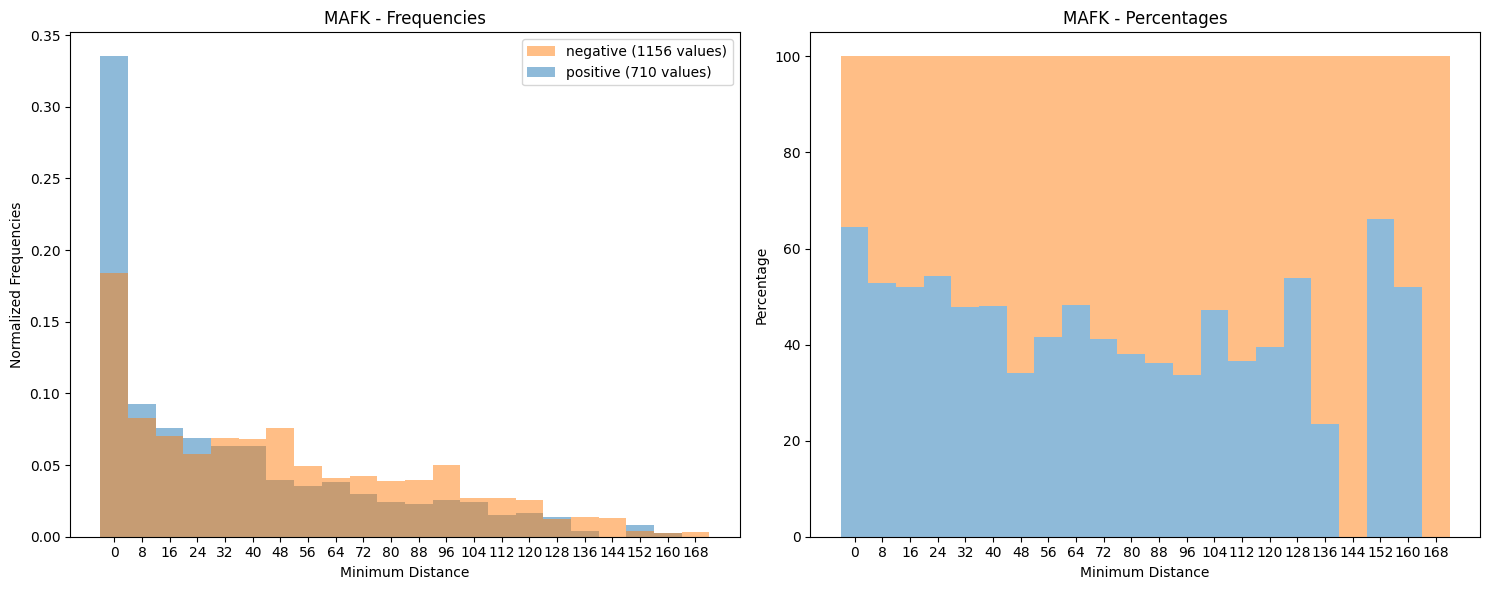

NFYB - Value Range: 167


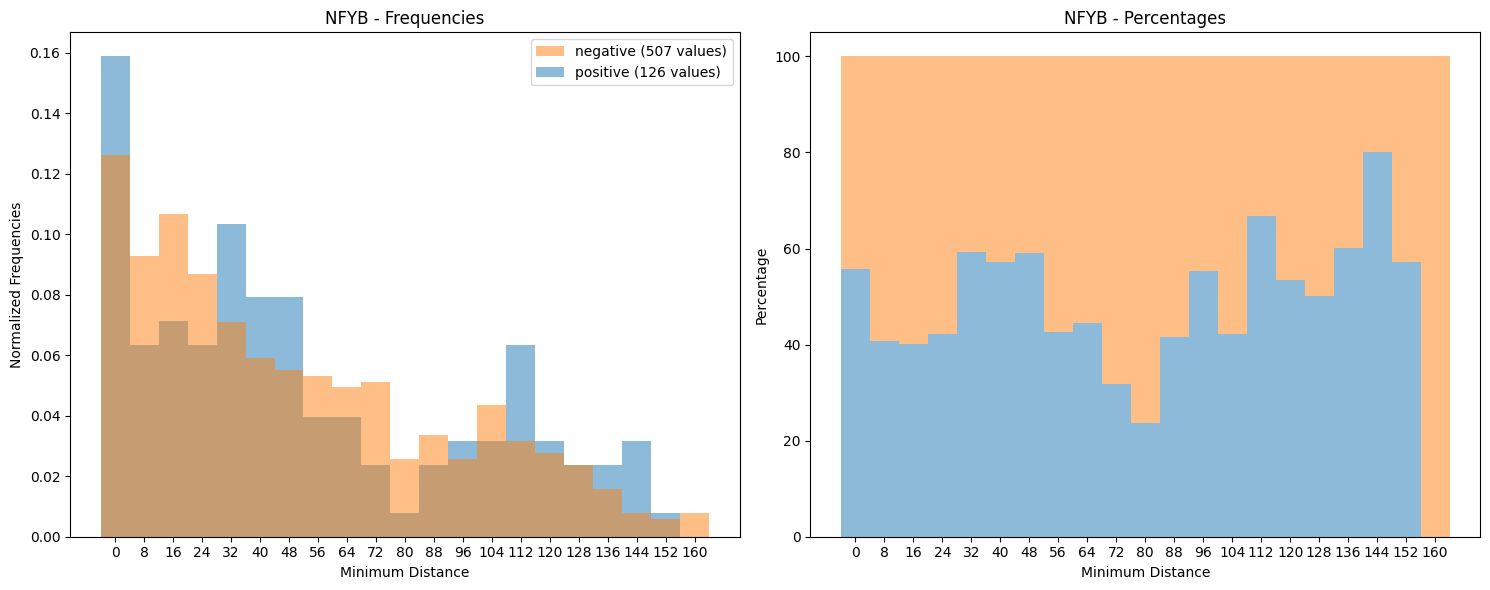

CEBPB - Value Range: 165


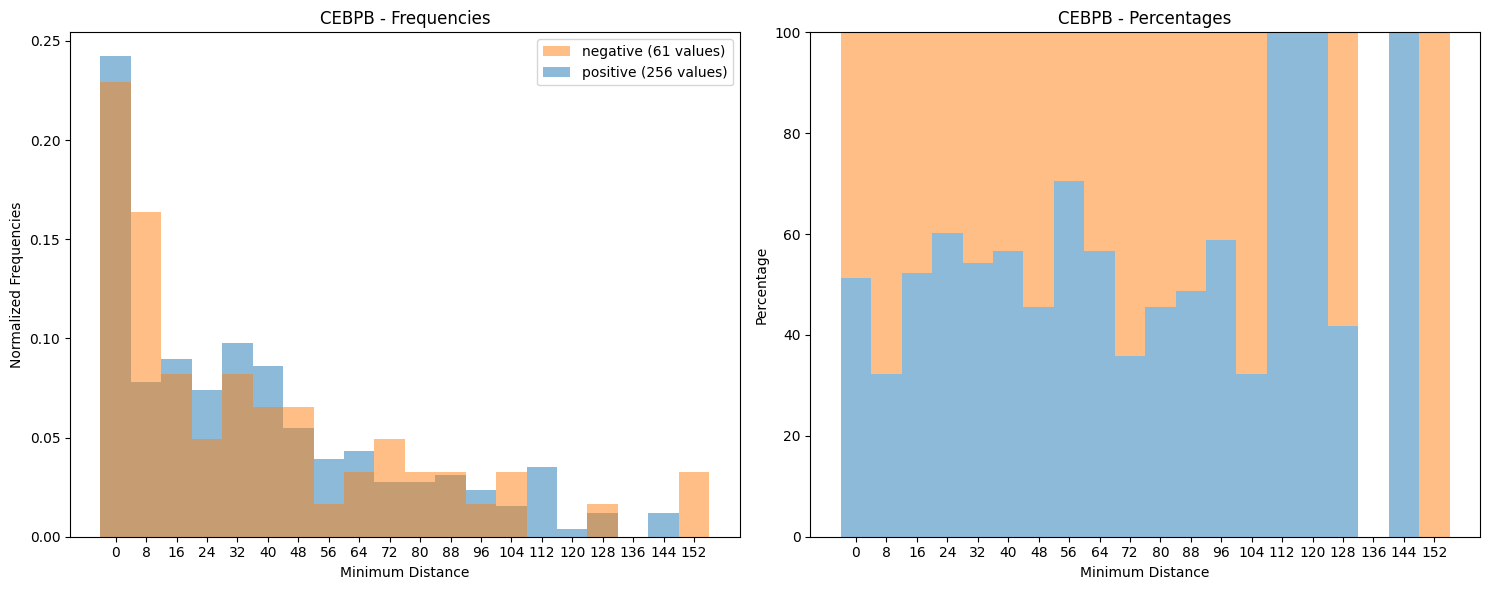

BATF - Value Range: 182


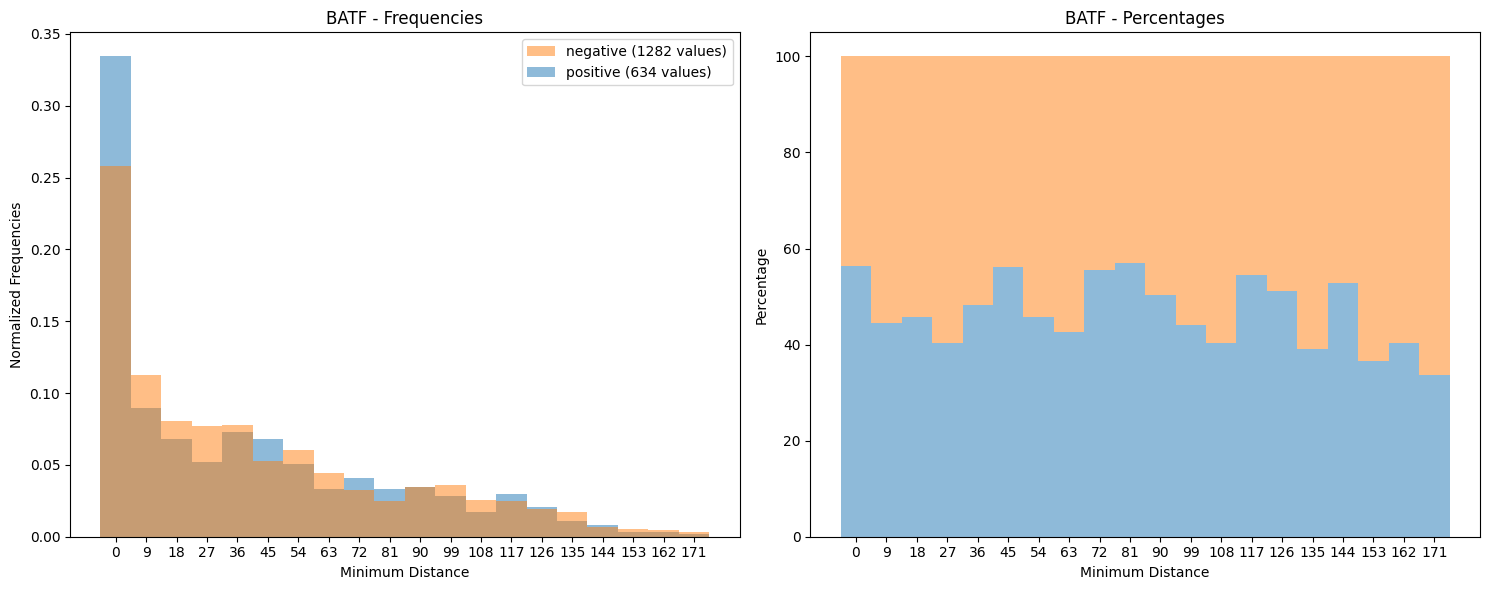

EBF1 - Value Range: 179


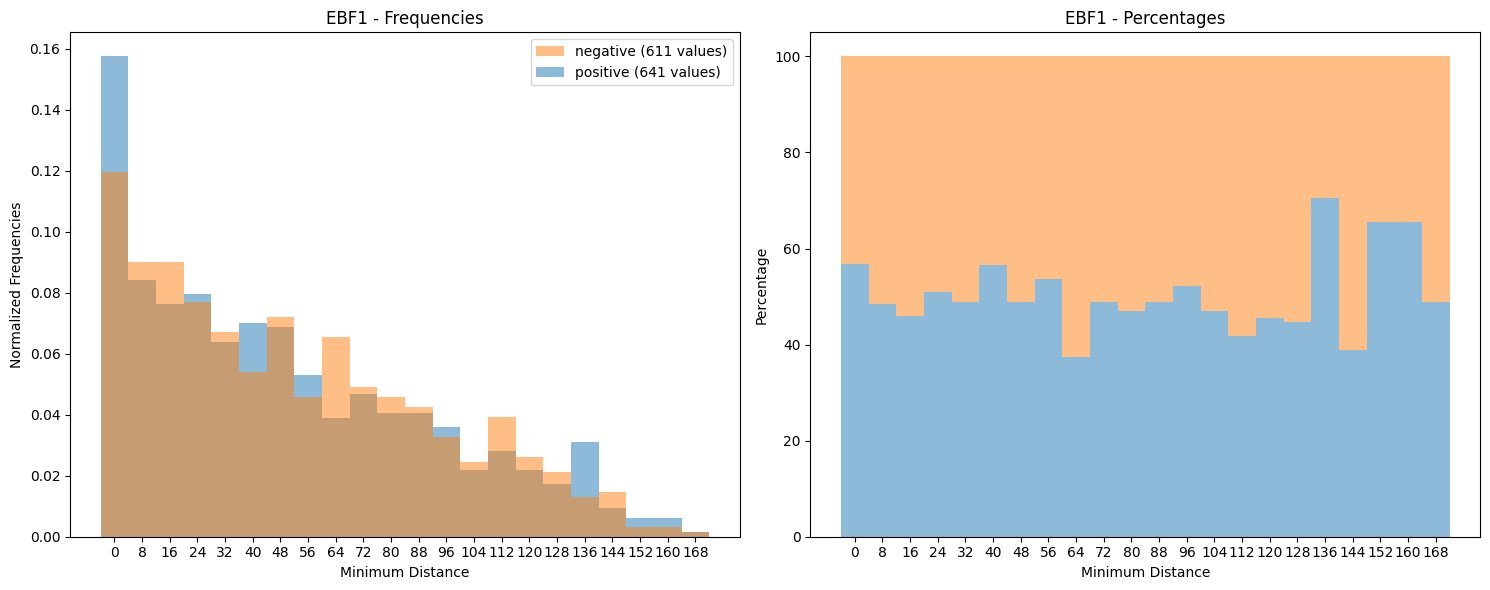

ZBTB7A - Value Range: 173


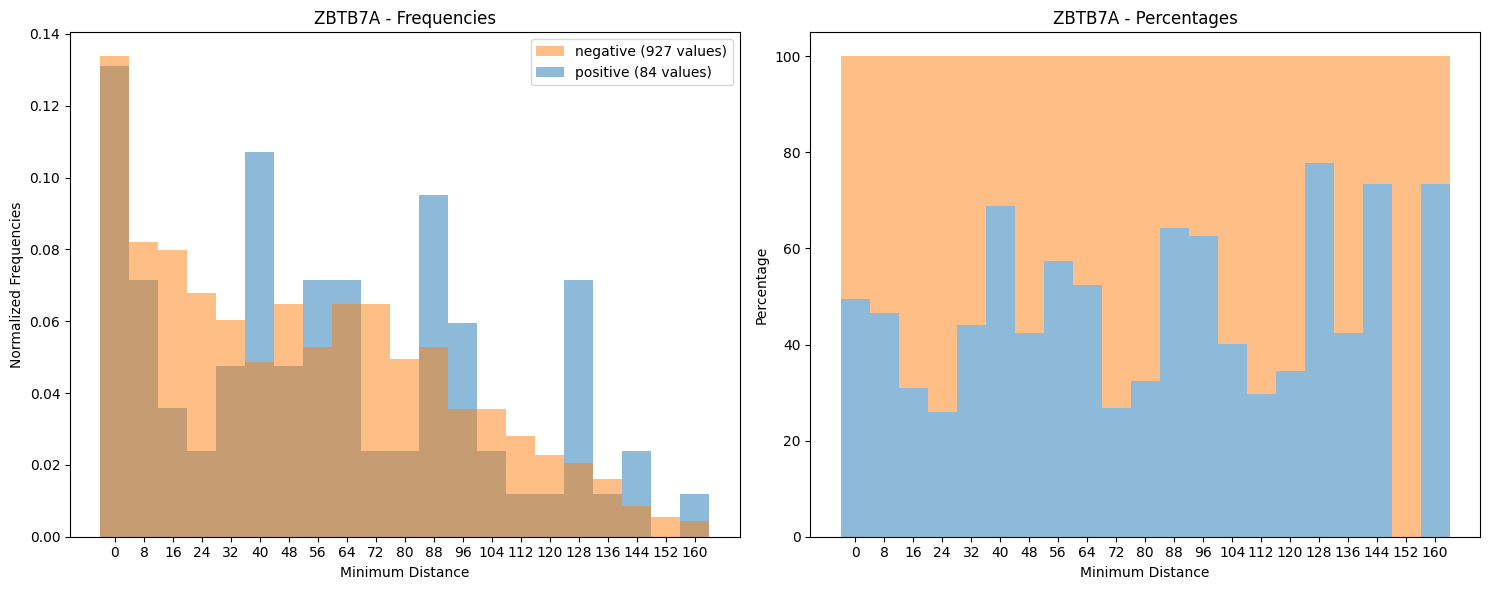

ETS1 - Value Range: 177


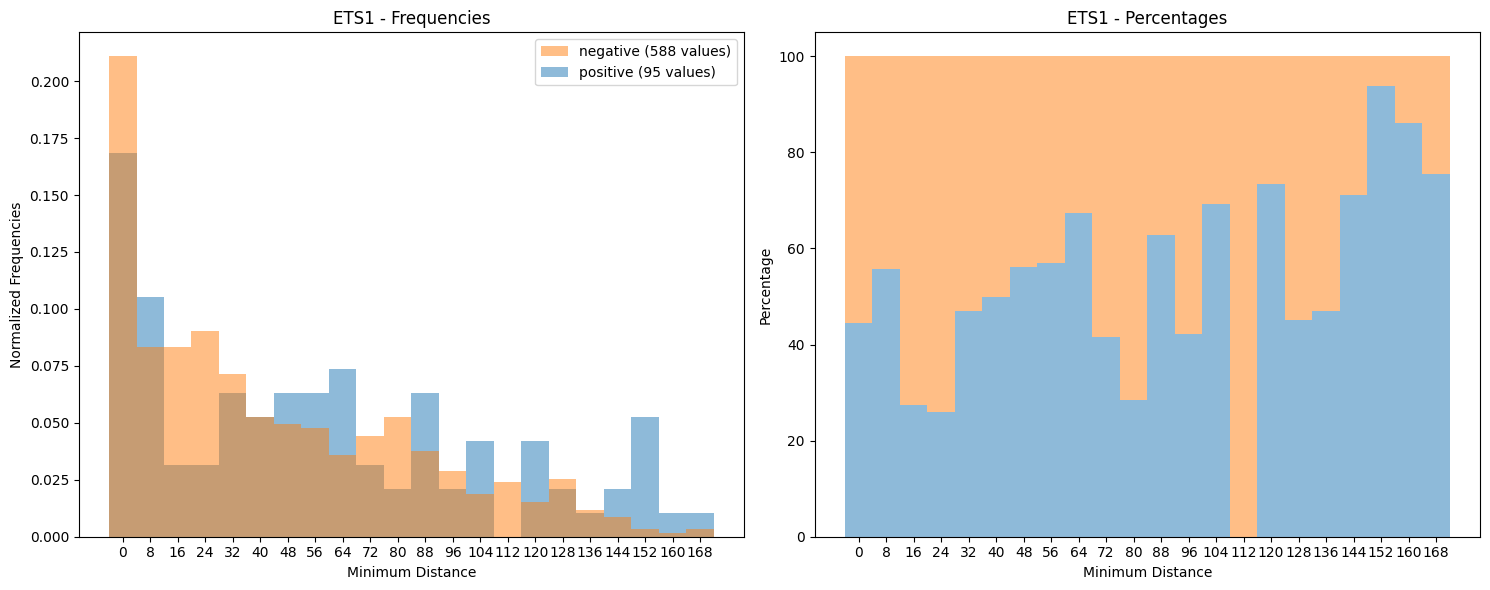

E2F6 - Value Range: 177


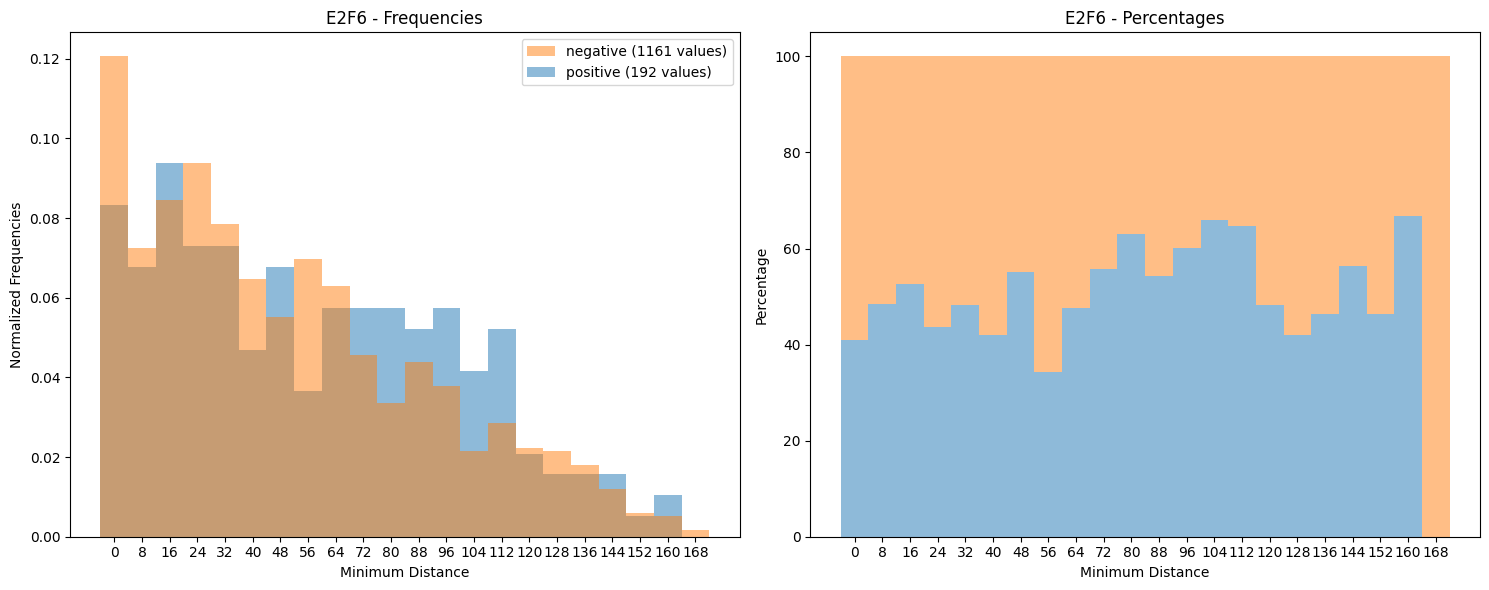

POU2F2 - Value Range: 168


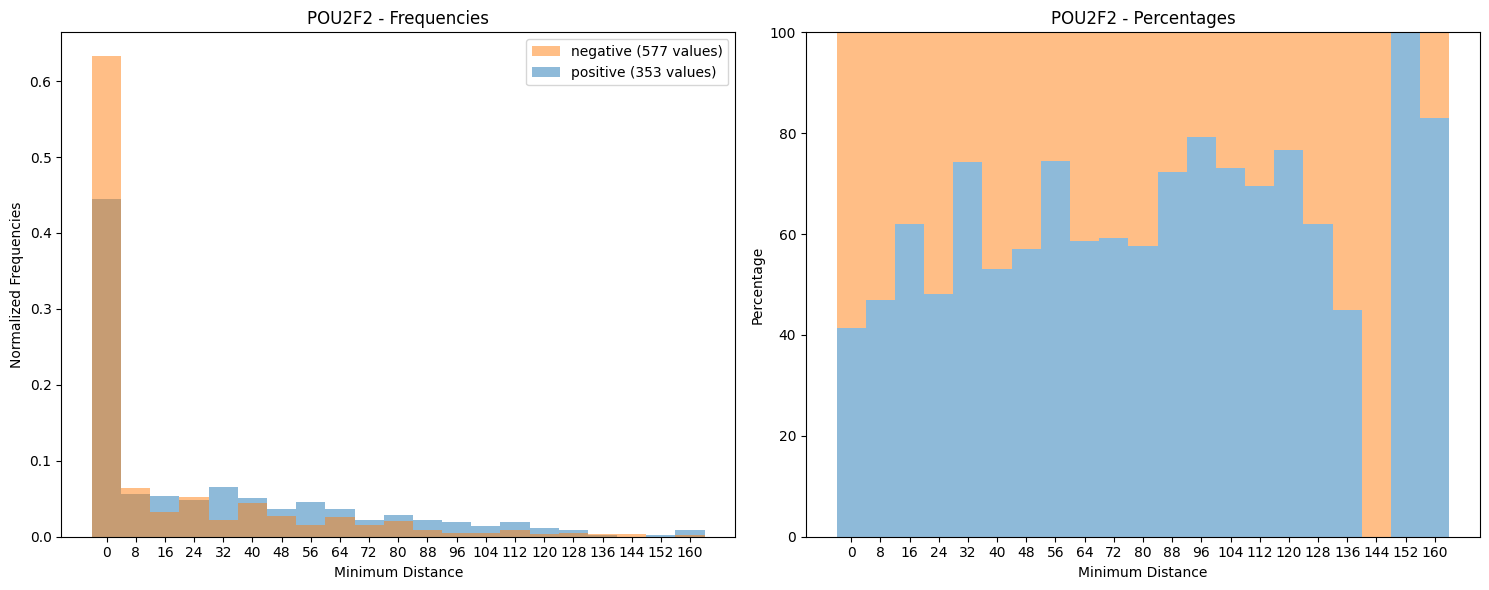

ELF1 - Value Range: 176


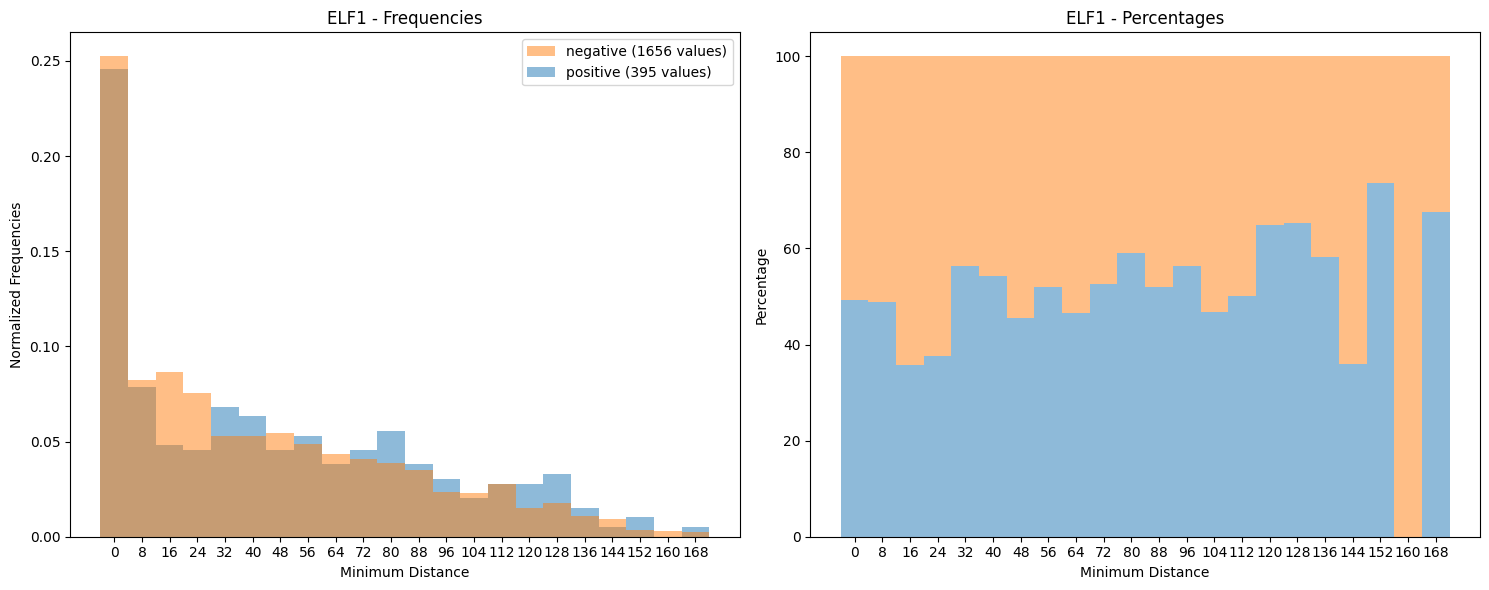

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `selected_tfs`, `positive_sequences`, `negative_sequences`, and `processed_features` are defined

for tf in selected_tfs:
    positive_distances = []
    negative_distances = []
    
    # Collect distances
    for seq_id_p in positive_sequences[tf]:
        if seq_id_p in processed_features:
            positive_distances.append(processed_features[seq_id_p][tf]['min_distance'])
            
    for seq_id_p in negative_sequences[tf]:
        if seq_id_p in processed_features:
            negative_distances.append(processed_features[seq_id_p][tf]['min_distance'])

    # Calculate the range of values and determine bin edges
    if len(positive_distances) == 0 and len(negative_distances) == 0:
        value_range = 0
    else:
        value_range = max(max(positive_distances, default=0), max(negative_distances, default=0)) + 1

    print(f'{tf} - Value Range: {value_range}')

    bin_edges = list(range(0, value_range + 2, max(1, value_range // 20)))  # Ensure at least one bin if value_range < 20

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Absolute frequencies
    ax = axs[0]
    neg_hist, _ = np.histogram(negative_distances, bins=bin_edges)
    pos_hist, _ = np.histogram(positive_distances, bins=bin_edges)
    pos_hist = pos_hist / len(positive_distances)
    neg_hist = neg_hist / len(negative_distances)
    pos_bars = ax.bar(bin_edges[:-1], pos_hist, width=np.diff(bin_edges), alpha=0.5, label='positive', color='tab:blue')
    neg_bars = ax.bar(bin_edges[:-1], neg_hist, width=np.diff(bin_edges), alpha=0.5, label='negative', color='tab:orange')
    total_pos = len(positive_distances)
    total_neg = len(negative_distances)
    ax.legend(handles=[neg_bars, pos_bars], labels=[f'negative ({total_neg} values)', f'positive ({total_pos} values)'])  # Reverse legend order
    ax.set_title(f'{tf} - Frequencies')
    ax.set_xlabel('Minimum Distance')
    ax.set_ylabel('Normalized Frequencies')

    # Plot 2: Percentages
    ax = axs[1]
    total = neg_hist + pos_hist
    neg_percent = np.zeros_like(neg_hist, dtype=float)
    pos_percent = np.zeros_like(pos_hist, dtype=float)
    non_zero_total = total > 0
    if np.any(non_zero_total):
        neg_percent[non_zero_total] = (neg_hist[non_zero_total] / total[non_zero_total]) * 100
        pos_percent[non_zero_total] = (pos_hist[non_zero_total] / total[non_zero_total]) * 100

    ax.bar(bin_edges[:-1], pos_percent, width=np.diff(bin_edges), alpha=0.5, label='positive', color='tab:blue')
    ax.bar(bin_edges[:-1], neg_percent, width=np.diff(bin_edges), alpha=0.5, bottom=pos_percent, label='negative', color='tab:orange')
    ax.set_title(f'{tf} - Percentages')
    ax.set_xlabel('Minimum Distance')
    ax.set_ylabel('Percentage')

    # Adjust x-axis
    for ax in axs:
        ax.set_xticks(bin_edges[:-1])
        ax.set_xticklabels([str(int(edge)) for edge in bin_edges[:-1]])

    plt.tight_layout()

    # Save the plot
    plt.savefig(f'{location}/figs/vanilla/{tf}_comparison.png')
    plt.show()

MAFK - Value Range: 179


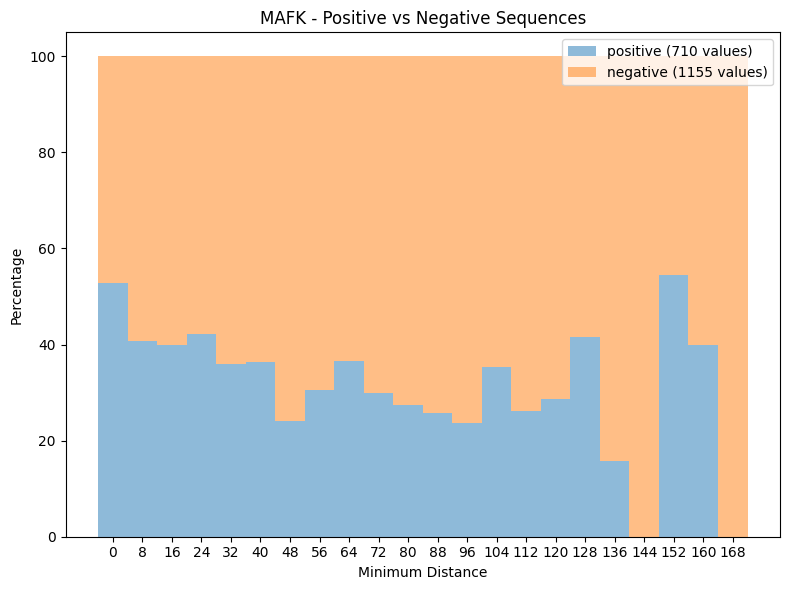

NFYB - Value Range: 167


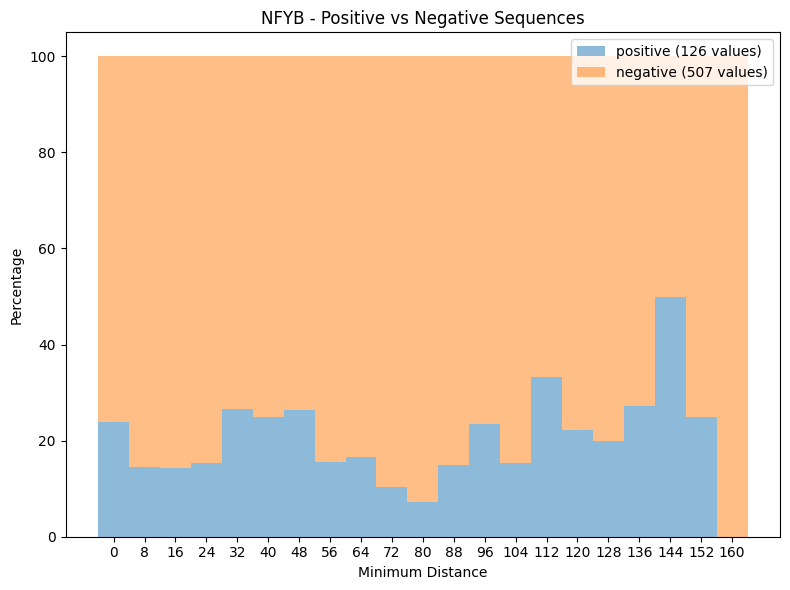

CEBPB - Value Range: 165


/home/waqaas/ipykernel_518475/3462197789.py:32: RuntimeWarning: invalid value encountered in divide
  neg_percent = (neg_hist / total) * 100
/home/waqaas/ipykernel_518475/3462197789.py:33: RuntimeWarning: invalid value encountered in divide
  pos_percent = (pos_hist / total) * 100


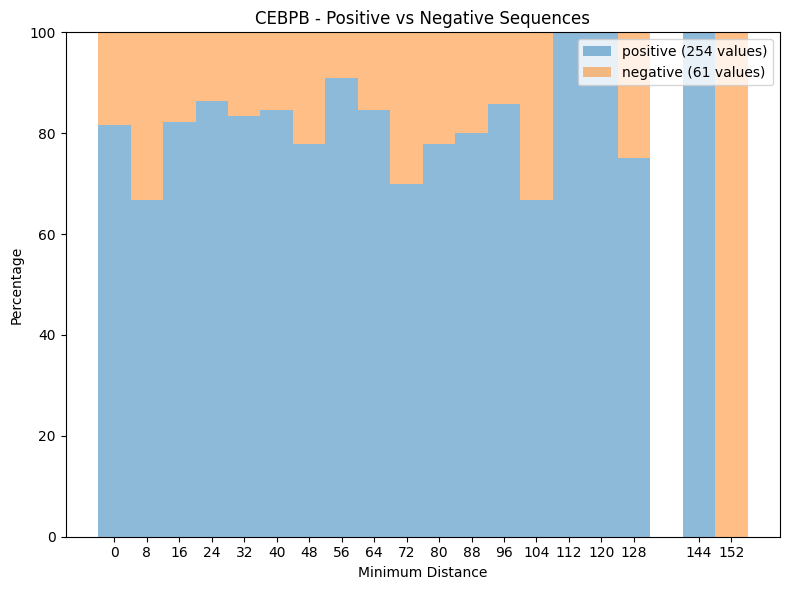

BATF - Value Range: 182


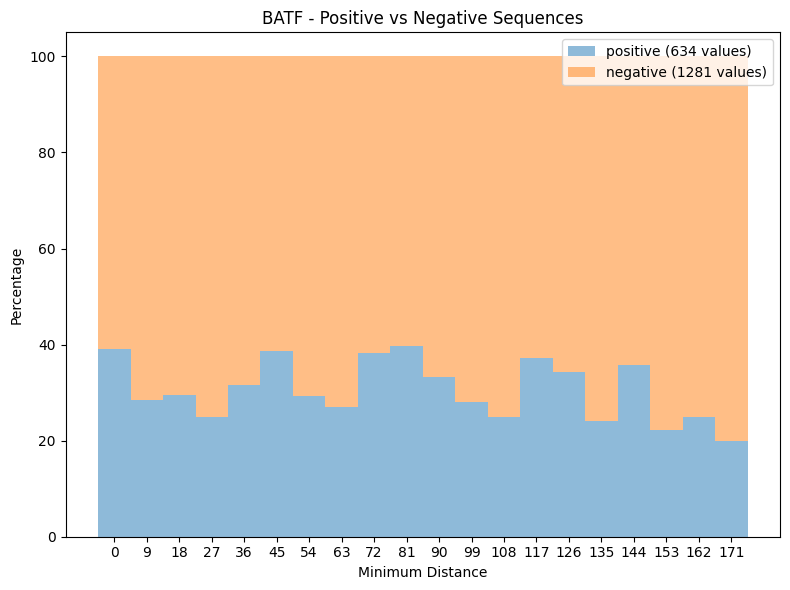

EBF1 - Value Range: 179


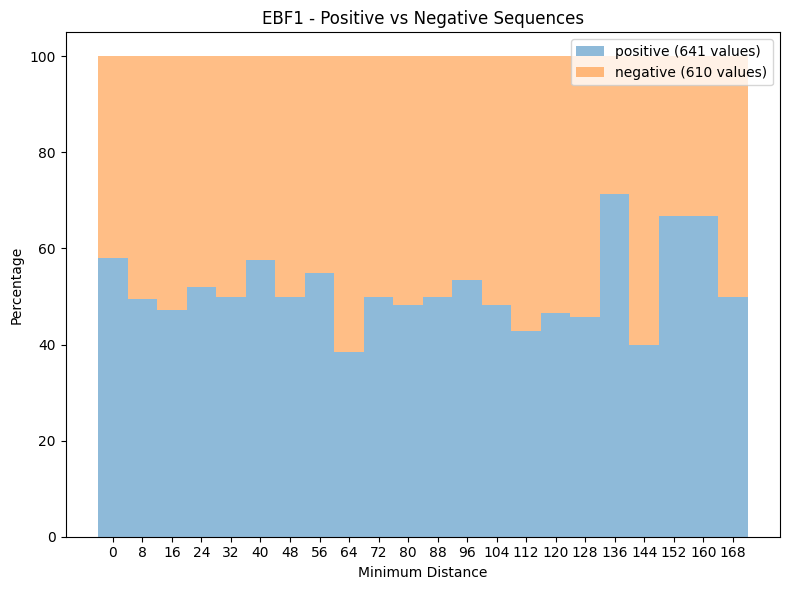

ZBTB7A - Value Range: 173


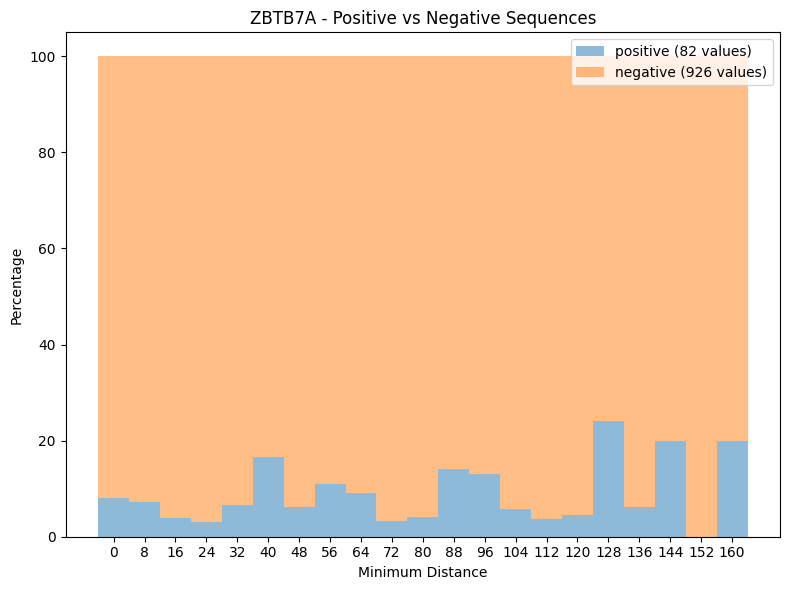

ETS1 - Value Range: 177


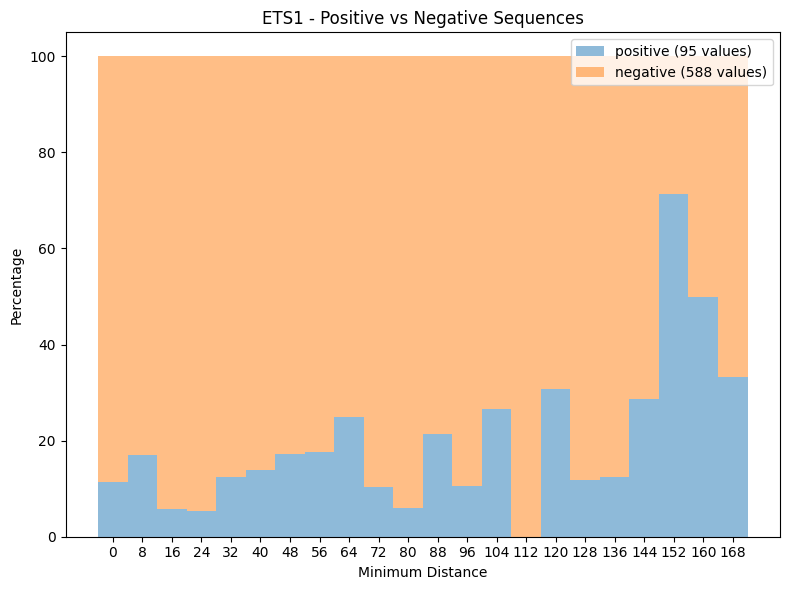

E2F6 - Value Range: 177


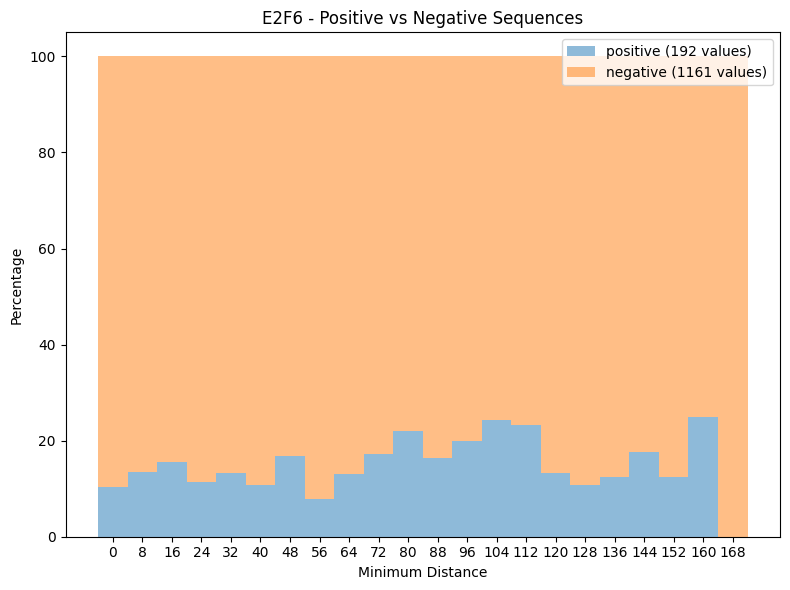

POU2F2 - Value Range: 168


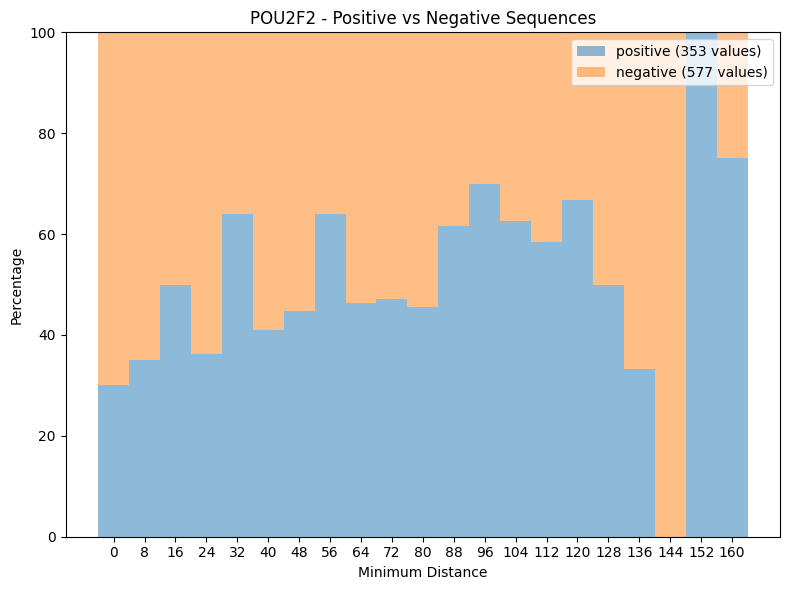

ELF1 - Value Range: 176


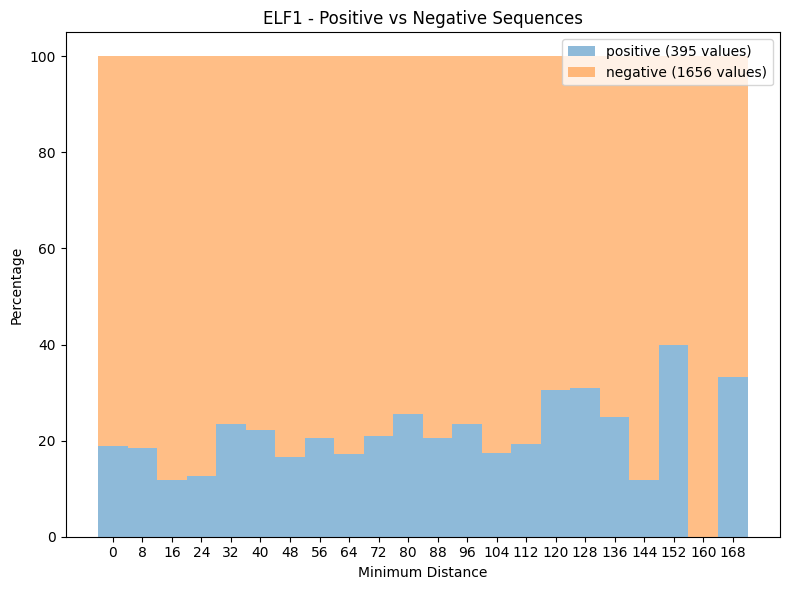

In [58]:
for tf in selected_tfs:
    positive_distances = []
    negative_distances = []
    for seq_id_p in positive_sequences[tf]:
        for seq_id in processed_features.keys():
            if seq_id == seq_id_p:
                positive_distances.append(processed_features[seq_id][tf]['min_distance'])
    for seq_id_p in negative_sequences[tf]:
        for seq_id in processed_features.keys():
            if seq_id == seq_id_p:
                negative_distances.append(processed_features[seq_id][tf]['min_distance'])

    # Calculate the range of values and determine bin edges
    if len(positive_distances) == 0 and len(negative_distances) == 0:
        value_range = 0
    else:
        value_range = max(max(positive_distances, default=0), max(negative_distances, default=0)) + 1

    print(f'{tf} - Value Range: {value_range}')

    bin_edges = list(range(0, value_range + 2, max(1, value_range // 20)))  # Ensure at least one bin if value_range < 20

    # Create a subplot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Create histograms for positive and negative distances on the same axes
    neg_hist, _ = np.histogram(negative_distances, bins=bin_edges)
    pos_hist, _ = np.histogram(positive_distances, bins=bin_edges)

    # Calculate percentages
    total = neg_hist + pos_hist
    neg_percent = (neg_hist / total) * 100
    pos_percent = (pos_hist / total) * 100

    # Handle potential division by zero in percentages
    neg_percent = np.nan_to_num(neg_percent)
    pos_percent = np.nan_to_num(pos_percent)

    # Filter out bins where both positive and negative frequencies are zero
    non_zero_bins = total > 0
    bin_centers = 0.5 * (np.array(bin_edges[:-1]) + np.array(bin_edges[1:]))[non_zero_bins]
    neg_percent = neg_percent[non_zero_bins]
    pos_percent = pos_percent[non_zero_bins]
    bin_width = np.diff(bin_edges)[non_zero_bins]  # Width of each bin

    # Plot stacked bar plots
    ax.bar(bin_centers, pos_percent, width=bin_width, alpha=0.5, label='positive')
    ax.bar(bin_centers, neg_percent, width=bin_width, alpha=0.5, bottom=pos_percent, label='negative')

    # Add legend with total count annotations
    total_pos = int(sum(pos_hist))
    total_neg = int(sum(neg_hist))
    ax.legend([f'positive ({total_pos} values)', f'negative ({total_neg} values)'])

    ax.set_title(f'{tf} - Positive vs Negative Sequences')
    ax.set_xlabel('Minimum Distance')
    ax.set_ylabel('Percentage')

    # Center-align xticks
    ax.set_xticks(bin_centers)
    ax.set_xticklabels([str(int(edge)) for edge in np.array(bin_edges[:-1])[non_zero_bins]])

    plt.tight_layout()
    # save the plot
    plt.savefig(f'{location}/figs/vanilla/{tf}.png')
    plt.show()


In [59]:
# run a wilcoxon rank sum test on the positive and negative distances
for tf in selected_tfs:
    positive_distances = []
    negative_distances = []
    for seq_id_p in positive_sequences[tf]:
        for seq_id in processed_features.keys():
            if seq_id == seq_id_p:
                positive_distances.append(processed_features[seq_id][tf]['min_distance'])
    for seq_id_p in negative_sequences[tf]:
        for seq_id in processed_features.keys():
            if seq_id == seq_id_p:
                negative_distances.append(processed_features[seq_id][tf]['min_distance'])
    # Perform Wilcoxon rank sum test
    stat, p_value = ranksums(positive_distances, negative_distances)
    
    # Print results
    print(f"TF: {tf}")
    print(f"Wilcoxon Rank Sum Test:")
    print(f"Statistic: {stat}")
    print(f"P-value: {p_value}\n")

TF: MAFK
Wilcoxon Rank Sum Test:
Statistic: -8.217885716974036
P-value: 2.0712219757603742e-16

TF: NFYB
Wilcoxon Rank Sum Test:
Statistic: 0.4814537559504108
P-value: 0.6301940389193877

TF: CEBPB
Wilcoxon Rank Sum Test:
Statistic: 0.48889186707705845
P-value: 0.6249182538741533

TF: BATF
Wilcoxon Rank Sum Test:
Statistic: -2.128854190570452
P-value: 0.03326632582629238

TF: EBF1
Wilcoxon Rank Sum Test:
Statistic: -1.1250351319888345
P-value: 0.26057414727190853

TF: ZBTB7A
Wilcoxon Rank Sum Test:
Statistic: 1.6953550264711543
P-value: 0.09000809201370077

TF: ETS1
Wilcoxon Rank Sum Test:
Statistic: 2.4285715740589824
P-value: 0.015158432795525626

TF: E2F6
Wilcoxon Rank Sum Test:
Statistic: 2.24518926550629
P-value: 0.024755984928858138

TF: POU2F2
Wilcoxon Rank Sum Test:
Statistic: 5.908375261146634
P-value: 3.4549827718880337e-09

TF: ELF1
Wilcoxon Rank Sum Test:
Statistic: 2.2525253202435924
P-value: 0.02428909447355641



In [60]:
thresholds = [2, 3, 4, 5, 10, 20, 40, 80]  # List of 'close' thresholds to test

# Create a dictionary to store p-values for each threshold
p_value_dict = {}
odds_ratio_dict = {}

for threshold in thresholds:
    p_value_dict[threshold] = []
    odds_ratio_dict[threshold] = []

    for tf in selected_tfs:
        positive_distances = []
        negative_distances = []

        for seq_id_p in positive_sequences[tf]:
            for seq_id in processed_features.keys():
                if seq_id == seq_id_p:
                    close = 0
                    if processed_features[seq_id][tf]['min_distance'] < threshold:
                        close = 1
                    positive_distances.append(close)

        for seq_id_p in negative_sequences[tf]:
            for seq_id in processed_features.keys():
                if seq_id == seq_id_p:
                    close = 0
                    if processed_features[seq_id][tf]['min_distance'] < threshold:
                        close = 1
                    negative_distances.append(close)

        # Contingency table
        contingency_table = [[sum(positive_distances), len(positive_distances) - sum(positive_distances)],
                             [sum(negative_distances), len(negative_distances) - sum(negative_distances)]]
        # print(f'{tf} - Contingency Table:')
        # print(f'         | Close | Not Close')
        # print(f'Positive |  {contingency_table[0][0]}   |   {contingency_table[0][1]}')
        # print(f'Negative |  {contingency_table[1][0]}   |   {contingency_table[1][1]}')

        # Perform Fisher's exact test
        odds_ratio, p_value = fisher_exact(contingency_table)

        p_value_dict[threshold].append(p_value)
        odds_ratio_dict[threshold].append(odds_ratio)

# Create a DataFrame to store the p-values for different thresholds, and add thresholds as the header column's name
p_value_df = pd.DataFrame.from_dict(p_value_dict, orient='index', columns=selected_tfs)
# make sure all items are float
p_value_df = p_value_df.astype(float)

odds_ratio_df = pd.DataFrame.from_dict(odds_ratio_dict, orient='index', columns=selected_tfs)
# make sure all items are float
odds_ratio_df = odds_ratio_df.astype(float)

for tf in selected_tfs:
    for row in odds_ratio_df.index:
        # add in the p-value in brackets, and if p-value is less than 0.05, add an asterisk
        if p_value_df.at[row, tf] < 0.05:
            odds_ratio_df.at[row, tf] = f"{odds_ratio_df.at[row, tf]:.2f} ({p_value_df.at[row, tf]:.6f}*)"
        else:
            odds_ratio_df.at[row, tf] = f"{odds_ratio_df.at[row, tf]:.2f} ({p_value_df.at[row, tf]:.6f})"

/home/waqaas/ipykernel_518475/2785806724.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.06 (0.000000*)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  odds_ratio_df.at[row, tf] = f"{odds_ratio_df.at[row, tf]:.2f} ({p_value_df.at[row, tf]:.6f}*)"
/home/waqaas/ipykernel_518475/2785806724.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.24 (0.487532)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  odds_ratio_df.at[row, tf] = f"{odds_ratio_df.at[row, tf]:.2f} ({p_value_df.at[row, tf]:.6f})"
/home/waqaas/ipykernel_518475/2785806724.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.94 (0.856865)' has dtype incompatible with float64, please ex

In [61]:
print(odds_ratio_df.to_markdown())

|    | MAFK             | NFYB            | CEBPB           | BATF             | EBF1             | ZBTB7A           | ETS1             | E2F6             | POU2F2           | ELF1             |
|---:|:-----------------|:----------------|:----------------|:-----------------|:-----------------|:-----------------|:-----------------|:-----------------|:-----------------|:-----------------|
|  2 | 2.06 (0.000000*) | 1.24 (0.487532) | 0.94 (0.856865) | 1.37 (0.007911*) | 1.45 (0.071207)  | 1.08 (0.831588)  | 0.74 (0.435747)  | 0.68 (0.292924)  | 0.46 (0.000000*) | 0.80 (0.168073)  |
|  3 | 2.05 (0.000000*) | 1.35 (0.316591) | 0.99 (1.000000) | 1.41 (0.002991*) | 1.47 (0.045767*) | 0.96 (1.000000)  | 0.80 (0.641321)  | 0.68 (0.309278)  | 0.47 (0.000000*) | 0.81 (0.154218)  |
|  4 | 2.15 (0.000000*) | 1.49 (0.190674) | 1.09 (0.862653) | 1.41 (0.002870*) | 1.52 (0.027915*) | 1.16 (0.696677)  | 0.71 (0.369675)  | 0.62 (0.162184)  | 0.46 (0.000000*) | 0.87 (0.365053)  |
|  5 | 2.23 (0.000000*) |

In [62]:
# lets check overall number of strong motifs, weak motifs, and no motifs, and see how many sequences have both strong motifs and weak motifs
motif_counts = pd.DataFrame(index=selected_tfs)
for tf in selected_tfs:
    strong_motifs = 0
    weak_motifs = 0
    no_motifs = 0
    both_motifs = 0
    for seq_id in processed_features.keys():
        if processed_features[seq_id][tf]['strong_motif_binary'] == 1 and processed_features[seq_id][tf]['weak_motif_binary'] == 1:
            both_motifs += 1
        elif processed_features[seq_id][tf]['strong_motif_binary'] == 1:
            strong_motifs += 1
        elif processed_features[seq_id][tf]['weak_motif_binary'] == 1:
            weak_motifs += 1
        elif processed_features[seq_id][tf]['strong_motif_binary'] == 0 and processed_features[seq_id][tf]['weak_motif_binary'] == 0:
            no_motifs += 1
    # organize results in a df with TFs as index and the counts as columns
    motif_counts.at[tf, 'Strong Motifs'] = strong_motifs
    motif_counts.at[tf, 'Weak Motifs'] = weak_motifs
    motif_counts.at[tf, 'Both Strong and Weak Motifs'] = both_motifs
    motif_counts.at[tf, 'No Motifs'] = no_motifs

print(motif_counts.to_markdown())

|        |   Strong Motifs |   Weak Motifs |   Both Strong and Weak Motifs |   No Motifs |
|:-------|----------------:|--------------:|------------------------------:|------------:|
| MAFK   |            2465 |          5491 |                          1752 |       25623 |
| NFYB   |            1828 |          5546 |                           754 |       27203 |
| CEBPB  |             456 |          4161 |                            99 |       30615 |
| BATF   |            1257 |          2240 |                          2617 |       29217 |
| EBF1   |            3249 |          2011 |                          1756 |       28315 |
| ZBTB7A |            3090 |          8576 |                          2662 |       21003 |
| ETS1   |            1616 |         11975 |                          1282 |       20458 |
| E2F6   |            5464 |          3449 |                          2588 |       23830 |
| POU2F2 |             922 |          5818 |                           487 |       28104 |

In [63]:
# create strong_motif_seq and weak_motif_seq for each sequence
for tf in selected_tfs:
    for seq_id in processed_features.keys():
        processed_features[seq_id][tf]['strong_motif_seq'] = np.zeros(200)
        processed_features[seq_id][tf]['weak_motif_seq'] = np.zeros(200)
        for i in range(200):
            if 0 < processed_features[seq_id][tf]['p-value_positive'][i] <= 0.0001 or 0 < processed_features[seq_id][tf]['p-value_negative'][i] <= 0.0001:
                processed_features[seq_id][tf]['strong_motif_seq'][i] = 1
            elif processed_features[seq_id][tf]['p-value_positive'][i] > 0.0001 or processed_features[seq_id][tf]['p-value_negative'][i] > 0.0001:
                processed_features[seq_id][tf]['weak_motif_seq'][i] = 1

In [64]:
models_no_strong = {}

for n, tf in enumerate(selected_tfs):
    data[tf] = []
    for seq_id in affinity[tf].keys():
        if seq_id in processed_features.keys() and processed_features[seq_id][tf]['strong_motif_binary'] == 0:
            data_point = {
                'bubble_binary': processed_features[seq_id]['bubble_binary'],
                'binding_affinity': processed_features[seq_id]['tf_label'][n]
            }

            # Append the data point to the appropriate list based on the presence of motif and bubble
            data[tf].append(data_point)

    # Create pandas DataFrame for each TF
    df = pd.DataFrame(data[tf])

    # Perform logistic regression for each case
    model_bubble = perform_logistic_regression(df, ['bubble_binary'], 'binding_affinity')

    # Store the models for each TF
    models_no_strong[tf] = {'bubble_only': model_bubble}


In [65]:
# Print summaries for models_no_strong
for tf in selected_tfs:
    print(f"\nTF = {tf}")

    print("\nLogistic Regression with Bubble Feature Only (No Strong Motifs):")
    bubble_summary = calculate_statistics(models_no_strong[tf]['bubble_only'], df[['bubble_binary']], df['binding_affinity'])
    bubble_summary.index = ['bubble']
    print(bubble_summary.to_markdown())


TF = MAFK

Logistic Regression with Bubble Feature Only (No Strong Motifs):
|        |    coef |   std err |       z |   P-value |   0.025 |   0.975 |   Pseudo R-squared |   Log-Likelihood |   LLR p-value |
|:-------|--------:|----------:|--------:|----------:|--------:|--------:|-------------------:|-----------------:|--------------:|
| bubble | 1.25343 | 0.0468174 | 26.7728 |         0 | 1.16167 |  1.3452 |            0.90732 |         -21382.6 |             0 |

TF = NFYB

Logistic Regression with Bubble Feature Only (No Strong Motifs):
|        |     coef |   std err |        z |   P-value |    0.025 |     0.975 |   Pseudo R-squared |   Log-Likelihood |   LLR p-value |
|:-------|---------:|----------:|---------:|----------:|---------:|----------:|-------------------:|-----------------:|--------------:|
| bubble | -0.96368 | 0.0566264 | -17.0182 |         0 | -1.07467 | -0.852693 |           0.922617 |         -17853.3 |             0 |

TF = CEBPB

Logistic Regression with Bubble 

In [66]:
for tf in selected_tfs:
    for seq_id in processed_features.keys():
        flip = []
        coord = []
        coordsq = []
        for i in range(200):
            if processed_features[seq_id][tf]['motif_seq'][i] == 1:
                flip.append(processed_features[seq_id]['flipping'][i])
                coord.append(processed_features[seq_id]['coords'][i])
                coordsq.append(processed_features[seq_id]['coordssquared'][i])
        # append the average feature value to the dictionary
        if len(flip) == 0:
            processed_features[seq_id][tf]['motif_flip'] = 0
            processed_features[seq_id][tf]['motif_coord'] = 0
            processed_features[seq_id][tf]['motif_coordsq'] = 0
        else:
            processed_features[seq_id][tf]['motif_flip'] = mean(flip)
            processed_features[seq_id][tf]['motif_coord'] = mean(coord)
            processed_features[seq_id][tf]['motif_coordsq'] = mean(coordsq)

In [67]:
correlation_results = {}

for n, tf in enumerate(selected_tfs):
    motif_flip = []
    motif_coord = []
    motif_coordsq = []
    binding_affinity = []  # Labels

    for seq_id in processed_features.keys():
        if processed_features[seq_id][tf]['strong_motif_binary'] == 1:
            motif_flip.append(processed_features[seq_id][tf]['motif_flip'])
            motif_coord.append(processed_features[seq_id][tf]['motif_coord'])
            motif_coordsq.append(processed_features[seq_id][tf]['motif_coordsq'])
            binding_affinity.append(processed_features[seq_id]['tf_label'][n])

    # Calculate point biserial correlation coefficient and p-value for each feature
    corr_flip, p_value_flip = pointbiserialr(motif_flip, binding_affinity)
    corr_coord, p_value_coord = pointbiserialr(motif_coord, binding_affinity)
    corr_coordsq, p_value_coordsq = pointbiserialr(motif_coordsq, binding_affinity)

    # round the correlation coefficients to 2 decimal places and the p-values to 6 decimal places
    corr_flip = round(corr_flip, 4)
    p_value_flip = round(p_value_flip, 6)
    corr_coord = round(corr_coord, 4)
    p_value_coord = round(p_value_coord, 6)
    corr_coordsq = round(corr_coordsq, 4)
    p_value_coordsq = round(p_value_coordsq, 6)

    correlation_results[tf] = {
        'motif_flip': (corr_flip, p_value_flip),
        'motif_coord': (corr_coord, p_value_coord),
        'motif_coordsq': (corr_coordsq, p_value_coordsq),
    }

    # display the correlation results in a df
    correlation_df = pd.DataFrame(correlation_results)

In [68]:
correlation_df = correlation_df.T
# rename the columns
correlation_df.columns = ['Motif Flip', 'Motif Coord', 'Motif Coord^2']
correlation_df

,Motif Flip,Motif Coord,Motif Coord^2
MAFK,"(0.1894, 0.0)","(0.2066, 0.0)","(0.1949, 0.0)"
NFYB,"(0.1115, 0.0)","(0.1156, 0.0)","(0.0998, 0.0)"
CEBPB,"(0.0343, 0.420079)","(0.0349, 0.412036)","(0.0287, 0.499722)"
BATF,"(0.1551, 0.0)","(0.1552, 0.0)","(0.147, 0.0)"
EBF1,"(0.1665, 0.0)","(0.1548, 0.0)","(0.1661, 0.0)"
ZBTB7A,"(-0.2546, 0.0)","(-0.2611, 0.0)","(-0.2573, 0.0)"
ETS1,"(-0.3069, 0.0)","(-0.3095, 0.0)","(-0.3136, 0.0)"
E2F6,"(-0.3194, 0.0)","(-0.3077, 0.0)","(-0.3222, 0.0)"
POU2F2,"(-0.3188, 0.0)","(-0.3109, 0.0)","(-0.3265, 0.0)"
ELF1,"(-0.2986, 0.0)","(-0.2987, 0.0)","(-0.3059, 0.0)"


In [69]:
# if the p-value is less than 0.05, then add an asterisk in the df
for tf in selected_tfs:
    for feature in correlation_df.columns:
        if correlation_df.at[tf, feature][1] < 0.05:
            correlation_df.at[tf, feature] = f"{correlation_df.at[tf, feature][0]:.2f} ({correlation_df.at[tf, feature][1]:.6f}*)"
        else:
            correlation_df.at[tf, feature] = f"{correlation_df.at[tf, feature][0]:.2f} ({correlation_df.at[tf, feature][1]:.6f})"

In [70]:
print(correlation_df.to_markdown())

|        | Motif Flip        | Motif Coord       | Motif Coord^2     |
|:-------|:------------------|:------------------|:------------------|
| MAFK   | 0.19 (0.000000*)  | 0.21 (0.000000*)  | 0.19 (0.000000*)  |
| NFYB   | 0.11 (0.000000*)  | 0.12 (0.000000*)  | 0.10 (0.000000*)  |
| CEBPB  | 0.03 (0.420079)   | 0.03 (0.412036)   | 0.03 (0.499722)   |
| BATF   | 0.16 (0.000000*)  | 0.16 (0.000000*)  | 0.15 (0.000000*)  |
| EBF1   | 0.17 (0.000000*)  | 0.15 (0.000000*)  | 0.17 (0.000000*)  |
| ZBTB7A | -0.25 (0.000000*) | -0.26 (0.000000*) | -0.26 (0.000000*) |
| ETS1   | -0.31 (0.000000*) | -0.31 (0.000000*) | -0.31 (0.000000*) |
| E2F6   | -0.32 (0.000000*) | -0.31 (0.000000*) | -0.32 (0.000000*) |
| POU2F2 | -0.32 (0.000000*) | -0.31 (0.000000*) | -0.33 (0.000000*) |
| ELF1   | -0.30 (0.000000*) | -0.30 (0.000000*) | -0.31 (0.000000*) |


In [71]:
for tf in selected_tfs:
    count = []
    for seq_id in processed_features.keys():
        count.append(sum(processed_features[seq_id][tf]['motif_seq']))
    # display unique counts and their frequencies
    unique, counts = np.unique(count, return_counts=True)
    print(tf)
    print(dict(zip(unique, counts)))

MAFK
{0.0: 25623, 14.0: 5798, 16.0: 2400, 18.0: 7, 19.0: 1, 20.0: 8, 21.0: 11, 22.0: 3, 23.0: 20, 24.0: 5, 25.0: 13, 26.0: 17, 27.0: 18, 28.0: 629, 29.0: 8, 30.0: 496, 31.0: 2, 32.0: 97, 33.0: 1, 34.0: 2, 35.0: 2, 36.0: 6, 37.0: 2, 38.0: 3, 39.0: 7, 40.0: 6, 41.0: 5, 42.0: 41, 43.0: 3, 44.0: 57, 45.0: 3, 46.0: 20, 48.0: 3, 54.0: 4, 55.0: 2, 56.0: 4, 58.0: 2, 60.0: 1, 62.0: 1}
NFYB
{0.0: 27203, 11.0: 6485, 14.0: 101, 15.0: 177, 16.0: 10, 17.0: 2, 18.0: 19, 19.0: 9, 20.0: 10, 21.0: 3, 22.0: 1041, 23.0: 1, 24.0: 1, 25.0: 22, 26.0: 38, 27.0: 3, 28.0: 1, 29.0: 10, 31.0: 6, 32.0: 4, 33.0: 133, 34.0: 1, 35.0: 2, 36.0: 8, 37.0: 9, 40.0: 3, 41.0: 1, 42.0: 3, 44.0: 17, 47.0: 5, 53.0: 1, 55.0: 2}
CEBPB
{0.0: 30615, 11.0: 4329, 17.0: 1, 18.0: 2, 19.0: 4, 20.0: 1, 21.0: 12, 22.0: 345, 27.0: 1, 32.0: 1, 33.0: 20}
BATF
{0.0: 29217, 10.0: 5330, 14.0: 4, 17.0: 7, 18.0: 5, 19.0: 5, 20.0: 698, 27.0: 1, 28.0: 2, 29.0: 1, 30.0: 56, 40.0: 3, 50.0: 2}
EBF1
{0.0: 28315, 14.0: 5432, 15.0: 538, 16.0: 1, 22.0: 7

In [72]:
models_only_weak = {}

for n, tf in enumerate(selected_tfs):
    data[tf] = []
    for seq_id in affinity[tf].keys():
        if seq_id in processed_features.keys() and processed_features[seq_id][tf]['weak_motif_binary'] == 1:
            data_point = {
                'bubble_binary': processed_features[seq_id]['bubble_binary'],
                'binding_affinity': processed_features[seq_id]['tf_label'][n]
            }
            data[tf].append(data_point)

    # Create pandas DataFrame for each TF
    df = pd.DataFrame(data[tf])

    # Perform logistic regression for each case
    model_bubble = perform_logistic_regression(df, ['bubble_binary'], 'binding_affinity')

    # Store the models for each TF
    models_only_weak[tf] = {'bubble_only': model_bubble}

In [73]:
# Print summaries for models_only_weak
for tf in selected_tfs:
    print(f"\nTF = {tf}")

    print("\nLogistic Regression with Bubble Feature Only (Only Weak Motifs):")
    bubble_summary = calculate_statistics(models_only_weak[tf]['bubble_only'], df[['bubble_binary']], df['binding_affinity'])
    bubble_summary.index = ['bubble']
    print(bubble_summary.to_markdown())



TF = MAFK

Logistic Regression with Bubble Feature Only (Only Weak Motifs):
|        |    coef |   std err |       z |   P-value |    0.025 |   0.975 |   Pseudo R-squared |   Log-Likelihood |   LLR p-value |
|:-------|--------:|----------:|--------:|----------:|---------:|--------:|-------------------:|-----------------:|--------------:|
| bubble | 1.03591 | 0.0580292 | 17.8516 |         0 | 0.922176 | 1.14965 |           0.929297 |         -8241.56 |             0 |

TF = NFYB

Logistic Regression with Bubble Feature Only (Only Weak Motifs):
|        |      coef |   std err |        z |   P-value |    0.025 |    0.975 |   Pseudo R-squared |   Log-Likelihood |   LLR p-value |
|:-------|----------:|----------:|---------:|----------:|---------:|---------:|-------------------:|-----------------:|--------------:|
| bubble | -0.947916 | 0.0695081 | -13.6375 |         0 | -1.08415 | -0.81168 |           0.942217 |         -6735.45 |             0 |

TF = CEBPB

Logistic Regression with Bubb

In [74]:
# Initialize an empty DataFrame to store the merged results
merged_results = pd.DataFrame()

# Merge and format results
for tf in selected_tfs:
    # Calculate summaries for each dataset
    summary_all = calculate_statistics(models[tf]['bubble_only'], df[['bubble_binary']], df['binding_affinity'])
    summary_no_strong = calculate_statistics(models_no_strong[tf]['bubble_only'], df[['bubble_binary']], df['binding_affinity'])
    summary_only_weak = calculate_statistics(models_only_weak[tf]['bubble_only'], df[['bubble_binary']], df['binding_affinity'])

    # Concatenate summaries into a single DataFrame with MultiIndex
    summaries = pd.concat([summary_all, summary_no_strong, summary_only_weak], keys=[(tf, 'All sequences'), (tf, 'No strong motif matches'), (tf, 'Only weak motif matches')], names=['TF', 'Dataset'])

    # Append to the merged results
    merged_results = pd.concat([merged_results, summaries])

In [75]:
# Reset index to separate out TF and Dataset from the MultiIndex
merged_results.reset_index(inplace=True)

# delete column level_2
del merged_results['level_2']

# Rename columns for better clarity
merged_results.columns = ['TF', 'Selection Criteria', 'Bubble coefficient', 'std err', 'z', 'P-value', '0.025', '0.975', 'Pseudo R-squared', 'Log-Likelihood', 'LLR p-value']

# if the p-value in a row is less than 0.05, add an asterisk to the Selection Criteria column
merged_results['Selection Criteria'] = merged_results.apply(lambda row: f"{row['Selection Criteria']}*" if row['P-value'] < 0.05 else row['Selection Criteria'], axis=1)

# Display the merged results in Markdown format
print(merged_results.to_markdown(index=False))

| TF     | Selection Criteria       |   Bubble coefficient |   std err |          z |     P-value |      0.025 |      0.975 |   Pseudo R-squared |   Log-Likelihood |   LLR p-value |
|:-------|:-------------------------|---------------------:|----------:|-----------:|------------:|-----------:|-----------:|-------------------:|-----------------:|--------------:|
| MAFK   | All sequences*           |            1.13032   | 0.0698291 |  16.1869   | 0           |  0.993454  |  1.26718   |           0.919493 |         -9384.28 |             0 |
| MAFK   | No strong motif matches* |            1.25343   | 0.0802162 |  15.6257   | 0           |  1.09621   |  1.41066   |           0.911458 |        -10321    |             0 |
| MAFK   | Only weak motif matches* |            1.03591   | 0.0580292 |  17.8516   | 0           |  0.922176  |  1.14965   |           0.929297 |         -8241.56 |             0 |
| NFYB   | All sequences*           |           -1.11979   | 0.0941713 | -11.891    | 0   

# Count regressions and distance analyses

In [76]:
# a logistic regression to see if the number of bubbles in a sequence correlates with the binding affinity
models_bubble_count = {}

for n, tf in enumerate(selected_tfs):
    data[tf] = []
    for seq_id in processed_features.keys():
        if processed_features[seq_id][tf]['weak_motif_binary'] == 1 and processed_features[seq_id][tf]['strong_motif_binary'] == 0:
            data_point = {
                'bubble_count': processed_features[seq_id]['bubble_count'],
                'binding_affinity': processed_features[seq_id]['tf_label'][n]
            }

            # Append the data point to the appropriate list based on the presence of motif and bubble
            data[tf].append(data_point)

    # Create pandas DataFrame for each TF
    df = pd.DataFrame(data[tf])

    # Perform logistic regression for each case
    model_bubble = perform_logistic_regression(df, ['bubble_count'], 'binding_affinity')

    # Store the models for each TF
    models_bubble_count[tf] = {'bubble_count': model_bubble}

In [77]:
# Access the models for each TF as needed
for tf in selected_tfs:
    print(f"\nTF = {tf}")
    print("\nLogistic Regression with Bubble Count Feature:")
    summary_bubble_count = calculate_statistics(models_bubble_count[tf]['bubble_count'], df[['bubble_count']], df['binding_affinity'])
    print(summary_bubble_count.to_markdown())


TF = MAFK

Logistic Regression with Bubble Count Feature:
|    |     coef |   std err |       z |   P-value |    0.025 |    0.975 |   Pseudo R-squared |   Log-Likelihood |   LLR p-value |
|---:|---------:|----------:|--------:|----------:|---------:|---------:|-------------------:|-----------------:|--------------:|
|  0 | 0.495345 |  0.027744 | 17.8541 |         0 | 0.440966 | 0.549723 |           0.921186 |         -6616.08 |             0 |

TF = NFYB

Logistic Regression with Bubble Count Feature:
|    |     coef |   std err |        z |   P-value |     0.025 |   0.975 |   Pseudo R-squared |   Log-Likelihood |   LLR p-value |
|---:|---------:|----------:|---------:|----------:|----------:|--------:|-------------------:|-----------------:|--------------:|
|  0 | -0.55051 | 0.0539844 | -10.1976 |         0 | -0.656319 | -0.4447 |           0.936317 |         -5345.91 |             0 |

TF = CEBPB

Logistic Regression with Bubble Count Feature:
|    |      coef |   std err |        z

In [78]:
# a logistic regression to see if the number of bubbles in a sequence correlates with the binding affinity
models_bubble_count_no_motif = {}

for n, tf in enumerate(selected_tfs):
    data[tf] = []
    for seq_id in processed_features.keys():
        if processed_features[seq_id][tf]['weak_motif_binary'] == 0 and processed_features[seq_id][tf]['strong_motif_binary'] == 0:
            data_point = {
                'bubble_count': processed_features[seq_id]['bubble_count'],
                'binding_affinity': processed_features[seq_id]['tf_label'][n]
            }

            # Append the data point to the appropriate list based on the presence of motif and bubble
            data[tf].append(data_point)

    # Create pandas DataFrame for each TF
    df = pd.DataFrame(data[tf])

    # Perform logistic regression for each case
    model_bubble = perform_logistic_regression(df, ['bubble_count'], 'binding_affinity')

    # Store the models for each TF
    models_bubble_count_no_motif[tf] = {'bubble_count': model_bubble}

In [79]:
# Access the models for each TF as needed
for tf in selected_tfs:
    print(f"\nTF = {tf}")
    print("\nLogistic Regression with Bubble Count Feature:")
    summary_bubble_count = calculate_statistics(models_bubble_count_no_motif[tf]['bubble_count'], df[['bubble_count']], df['binding_affinity'])
    print(summary_bubble_count.to_markdown())


TF = MAFK

Logistic Regression with Bubble Count Feature:
|    |     coef |   std err |       z |   P-value |    0.025 |    0.975 |   Pseudo R-squared |   Log-Likelihood |   LLR p-value |
|---:|---------:|----------:|--------:|----------:|---------:|---------:|-------------------:|-----------------:|--------------:|
|  0 | 0.523514 | 0.0166922 | 31.3629 |         0 | 0.490798 | 0.556231 |           0.903299 |         -14192.8 |             0 |

TF = NFYB

Logistic Regression with Bubble Count Feature:
|    |      coef |   std err |        z |   P-value |    0.025 |     0.975 |   Pseudo R-squared |   Log-Likelihood |   LLR p-value |
|---:|----------:|----------:|---------:|----------:|---------:|----------:|-------------------:|-----------------:|--------------:|
|  0 | -0.520877 |  0.040716 | -12.7929 |         0 | -0.60068 | -0.441073 |           0.918282 |         -11993.7 |             0 |

TF = CEBPB

Logistic Regression with Bubble Count Feature:
|    |        coef |   std err | 

In [80]:
# p-value sorter and distance calculator
pvalue_dict = {}
for tf in selected_tfs:
    pvalue_dict[tf] = {}
    for seq_id in processed_features.keys():
        pvalue_dict[tf][seq_id] = set(processed_features[seq_id][tf]['p-value_positive']).union(set(processed_features[seq_id][tf]['p-value_negative']))
        # sort in ascending order
        pvalue_dict[tf][seq_id] = sorted(pvalue_dict[tf][seq_id])

pvalue_df_dict = {}
for tf in selected_tfs:
    n = 0
    pvalue_df_dict[tf] = {}
    for seq_id in processed_features.keys():
        for pvalue in pvalue_dict[tf][seq_id]:
            if pvalue == 0:
                continue
            pvalue_df_dict[tf][n] = {'seq_id': seq_id, 'pvalue': pvalue}
            n += 1

In [81]:
pvalue_strongestperseq_dict = {}
for tf in selected_tfs:
    pvalue_strongestperseq_dict[tf] = {}
    for seq_id in processed_features.keys():
        pvalue_strongestperseq_dict[tf][seq_id] = set(processed_features[seq_id][tf]['p-value_positive']).union(set(processed_features[seq_id][tf]['p-value_negative']))
        # sort in ascending order
        pvalue_strongestperseq_dict[tf][seq_id] = sorted(pvalue_strongestperseq_dict[tf][seq_id])
        # only chose the strongest p-value that isn't 0
        if pvalue_strongestperseq_dict[tf][seq_id][0] == 0 and len(pvalue_strongestperseq_dict[tf][seq_id]) > 1:
            pvalue_strongestperseq_dict[tf][seq_id] = pvalue_strongestperseq_dict[tf][seq_id][1]
        else:
            pvalue_strongestperseq_dict[tf][seq_id] = pvalue_strongestperseq_dict[tf][seq_id][0]

In [82]:
pvalue_df = {}
for tf in selected_tfs:
    pvalue_df[tf] = pd.DataFrame(pvalue_df_dict[tf])
    pvalue_df[tf] = pvalue_df[tf].T
    pvalue_df[tf] = pvalue_df[tf].sort_values(by=['pvalue'])

In [83]:
# distance calculator
distance_dict = {}
for tf in selected_tfs:
    distance_dict[tf] = []
    pos_count = 0
    neg_count = 0
    for index in pvalue_df[tf].index:
        if min(pos_count, neg_count) == 300:
            break
        seq_id = pvalue_df[tf].at[index, 'seq_id']
        pvalue = pvalue_df[tf].at[index, 'pvalue']
        motif = np.zeros(200)
        # turn indices where p-value_positive or p-value_negative is equal to pvalue to 1
        for i in range(200):
            if processed_features[seq_id][tf]['p-value_positive'][i] == pvalue or processed_features[seq_id][tf]['p-value_negative'][i] == pvalue:
                motif[i] = 1
        bubble_seq = processed_features[seq_id]['bubble_seq']
        label = processed_features[seq_id]['tf_label'][selected_tfs.index(tf)]

        # calculate starts and ends
        starts = []
        ends = []
        flip = 0
        for i in range(200):
            if flip == 0:
                if motif[i] == 1:
                    starts.append(i)
                    flip = 1
            elif flip == 1:
                if motif[i] == 0:
                    ends.append(i)
                    flip = 0
                elif i == 199:
                    ends.append(i)

        for start, end in zip(starts, ends):
            distances = [200]
            # if there is a 0 between start and stop, raise an error
            if 0 in motif[start:end]:
                print(f'Error: {seq_id} {tf}')
                print(motif)
            # first check if the motif is in the bubble
            if sum(bubble_seq[start:end]) != 0:
                distance = 0
                distances.append(distance)
            elif sum(bubble_seq[start:end]) == 0:
                # if not, calculate the distance
                # check backwards from the start of the motif
                for i in range(start-1, -1, -1):
                    distance += 1
                    if bubble_seq[i] == 1:
                        distances.append(distance)
                        break
                # check forwards from the end of the motif
                for i in range(end+1, 200):
                    distance += 1
                    if bubble_seq[i] == 1:
                        distances.append(distance)
                        break
            min_distance = min(distances)
            distance_dict[tf].append((min_distance, label))
            if label == 1:
                pos_count += 1
            elif label == 0:
                neg_count += 1

In [84]:
# alternate implementation using pvalue_strongestperseq_dict[tf][seq_id]
distance_dict_alt = {}
for tf in selected_tfs:
    distance_dict_alt[tf] = {'both': [], 'strong': [], 'weak': []}
    for seq_id in tqdm(processed_features.keys()):
        pvalue = pvalue_strongestperseq_dict[tf][seq_id]
        if pvalue == 0:
            continue
        motif = np.zeros(200)
        # turn indices where p-value_positive or p-value_negative is equal to pvalue to 1
        for i in range(200):
            if processed_features[seq_id][tf]['p-value_positive'][i] == pvalue or processed_features[seq_id][tf]['p-value_negative'][i] == pvalue:
                motif[i] = 1
        bubble_seq = processed_features[seq_id]['bubble_seq']
        label = processed_features[seq_id]['tf_label'][selected_tfs.index(tf)]

        # calculate starts and ends
        starts = []
        ends = []
        flip = 0
        for i in range(200):
            if flip == 0:
                if motif[i] == 1:
                    starts.append(i)
                    flip = 1
            elif flip == 1:
                if motif[i] == 0:
                    ends.append(i)
                    flip = 0
                elif i == 199:
                    ends.append(i)

        for start, end in zip(starts, ends):
            distances = [200]
            # if there is a 0 between start and stop, raise an error
            if 0 in motif[start:end]:
                print(f'Error: {seq_id} {tf}')
                print(motif)
            # first check if the motif is in the bubble
            if sum(bubble_seq[start:end]) != 0:
                distance = 0
                distances.append(distance)
            elif sum(bubble_seq[start:end]) == 0:
                # if not, calculate the distance
                # check backwards from the start of the motif
                for i in range(start-1, -1, -1):
                    distance += 1
                    if bubble_seq[i] == 1:
                        distances.append(distance)
                        break
                # check forwards from the end of the motif
                for i in range(end+1, 200):
                    distance += 1
                    if bubble_seq[i] == 1:
                        distances.append(distance)
                        break
            min_distance = min(distances)
            if pvalue < 0.0001:
                distance_dict_alt[tf]['strong'].append((min_distance, label))
            elif pvalue > 0.0001:
                distance_dict_alt[tf]['weak'].append((min_distance, label))
            distance_dict_alt[tf]['both'].append((min_distance, label))

100%|██████████| 35331/35331 [00:01<00:00, 17824.59it/s]


In [85]:
# # histogram of the distances of positive label sequences vs negative label sequences
# for tf in selected_tfs:
#     positive_distances = []
#     negative_distances = []
#     for distance, label in distance_dict[tf]:
#         if label == 1:
#             positive_distances.append(distance)
#         elif label == 0:
#             negative_distances.append(distance)

#     # Calculate the range of values and determine bin edges
#     value_range = 201
#     bin_edges = range(0, value_range, value_range // 25)

#     # Create a subplot
#     fig, ax = plt.subplots(figsize=(12, 9))

#     # Create histograms for positive and negative distances on the same axes
#     neg_hist, neg_edges, _ = ax.hist(negative_distances, bins=bin_edges, alpha=0.5, label='negative')
#     pos_hist, pos_edges, _ = ax.hist(positive_distances, bins=bin_edges, alpha=0.5, label='positive')

#     # Calculate total count of positive and negative data values
#     total_pos = int(sum(pos_hist))
#     total_neg = int(sum(neg_hist))

#     # Add legend with total count annotations
#     ax.legend([f'positive ({total_pos} values)', f'negative ({total_neg} values)'])

#     ax.set_title(f'{tf} - Positive vs Negative Sequences')
#     ax.set_xlabel('Distance')
#     ax.set_ylabel('Frequency')

#     # Center-align xticks
#     ax.set_xticks([edge + 0.5 for edge in bin_edges[:-1]])
#     ax.set_xticklabels([str(int(edge)) for edge in bin_edges[:-1]])

#     plt.tight_layout()
#     # plt.savefig(f'{location}figs/phase4_new/strong_motif_distances/{tf}_positive_vs_negative_sequences.png')
#     plt.show()

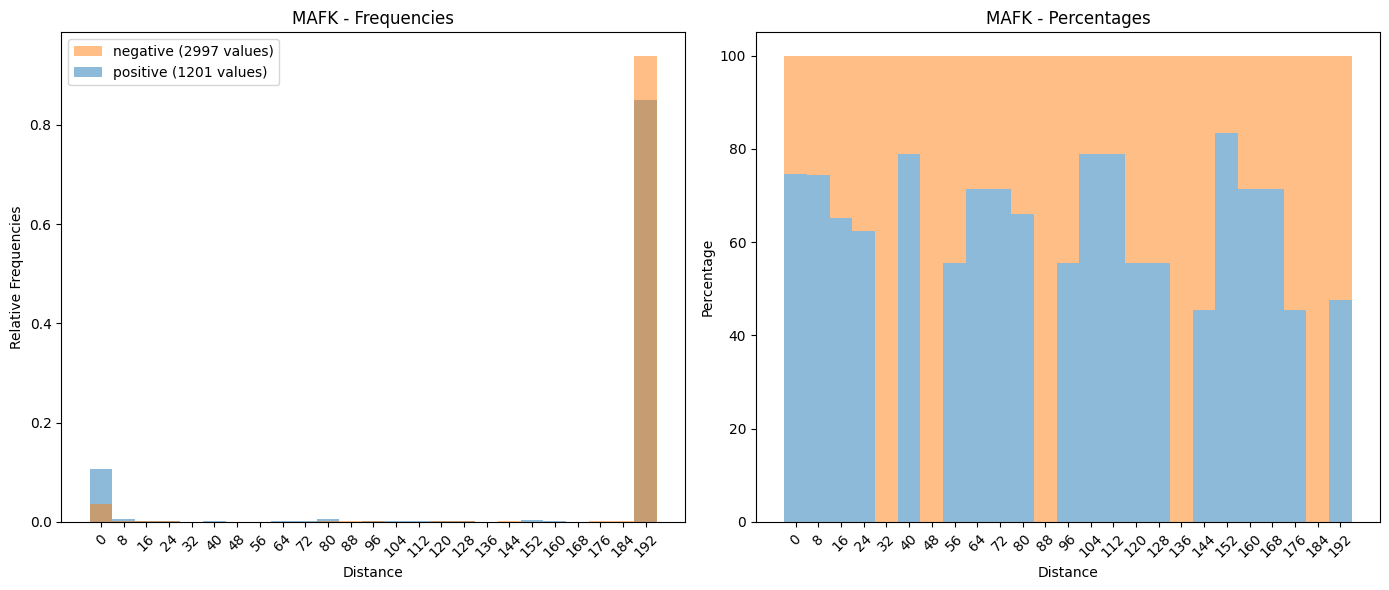

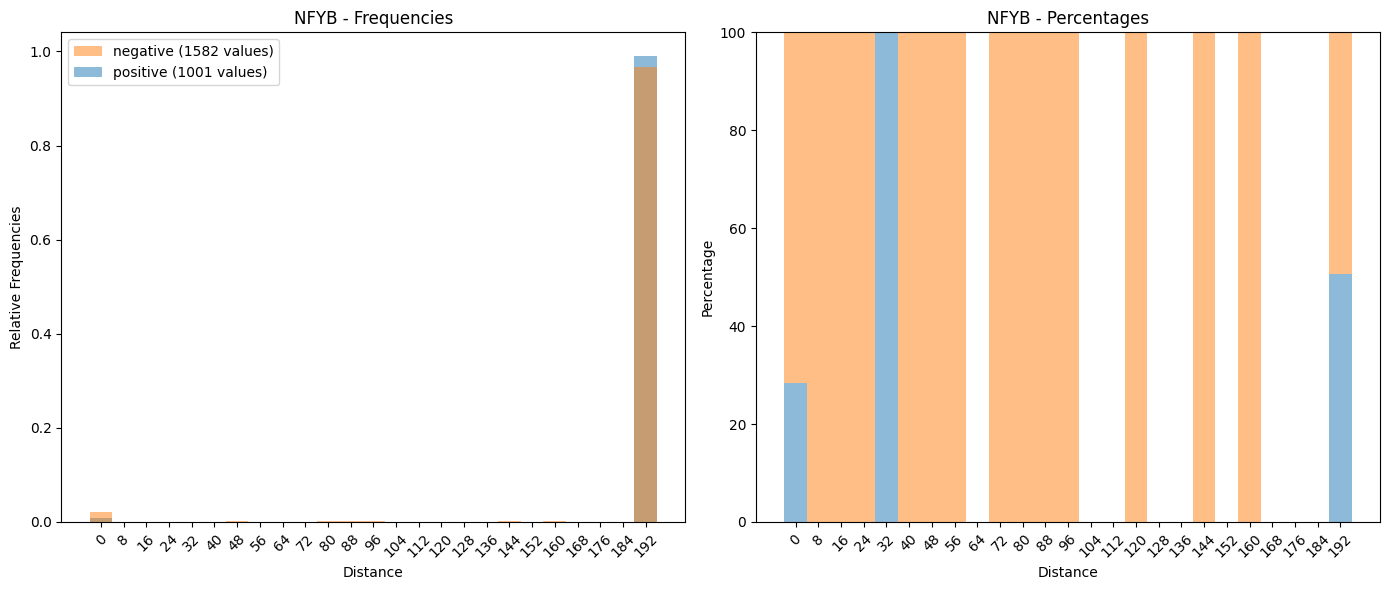

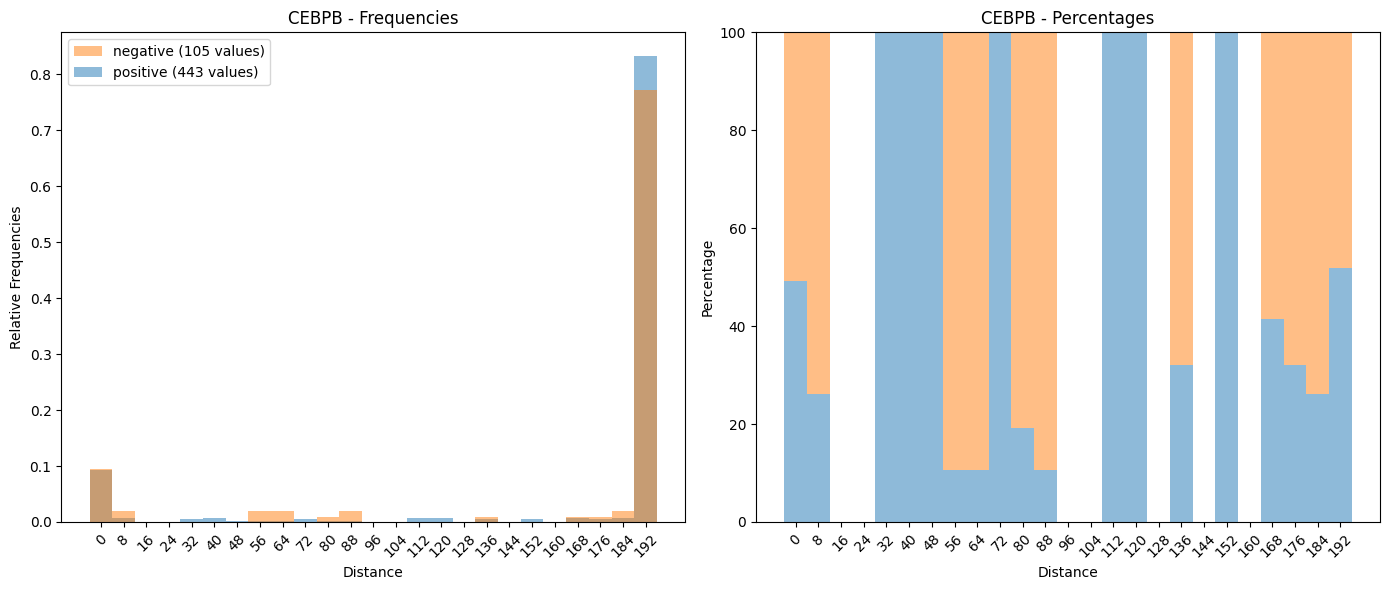

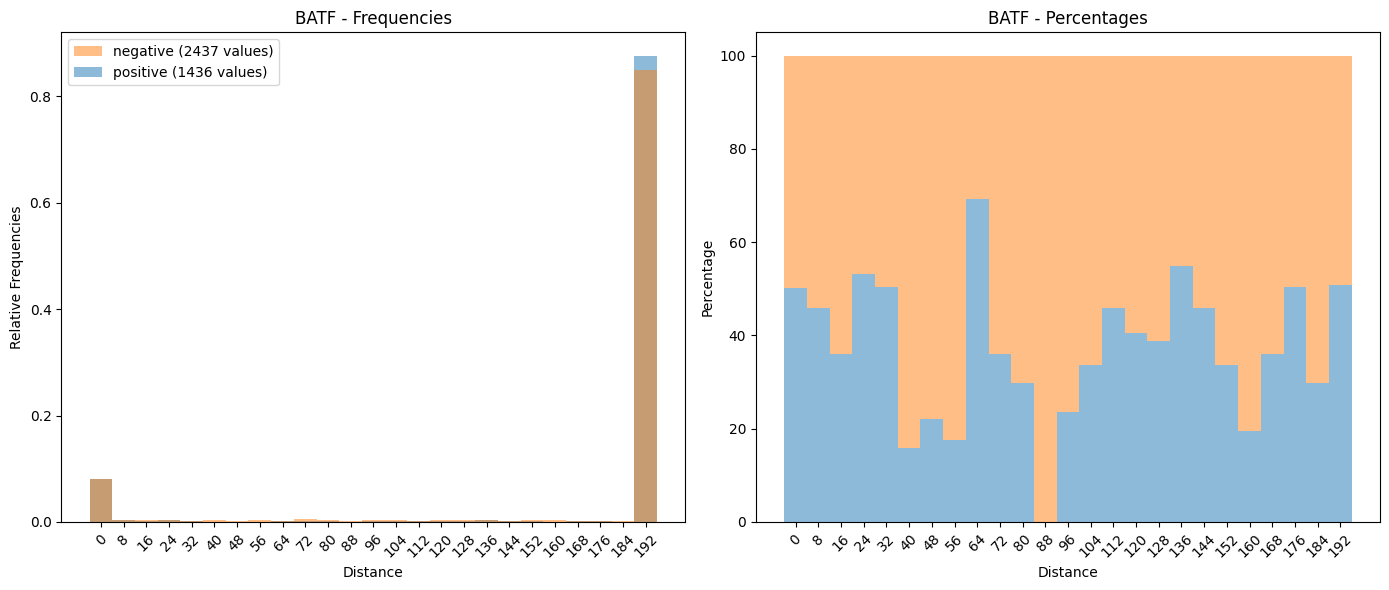

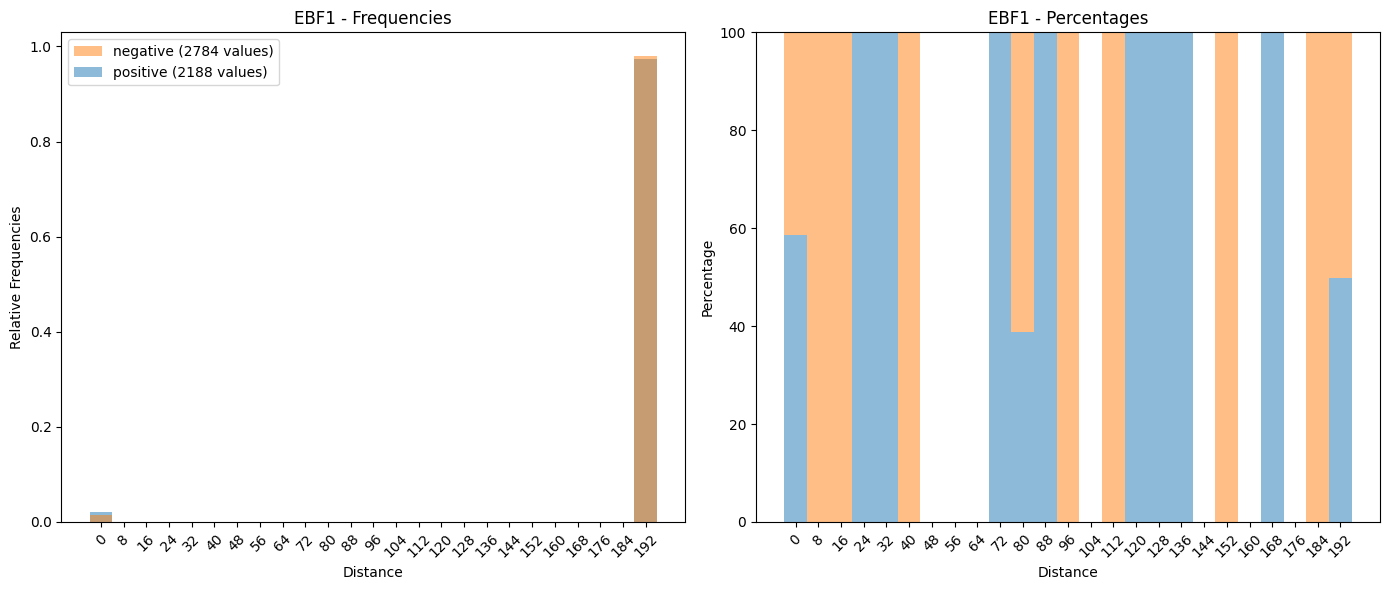

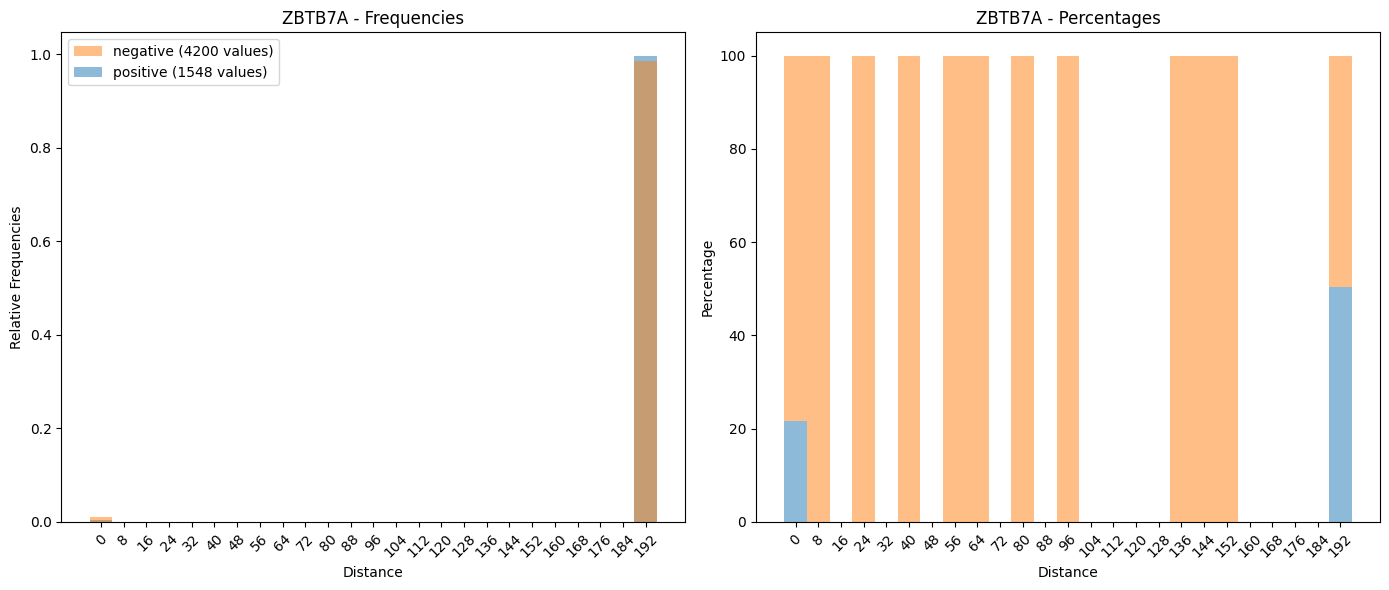

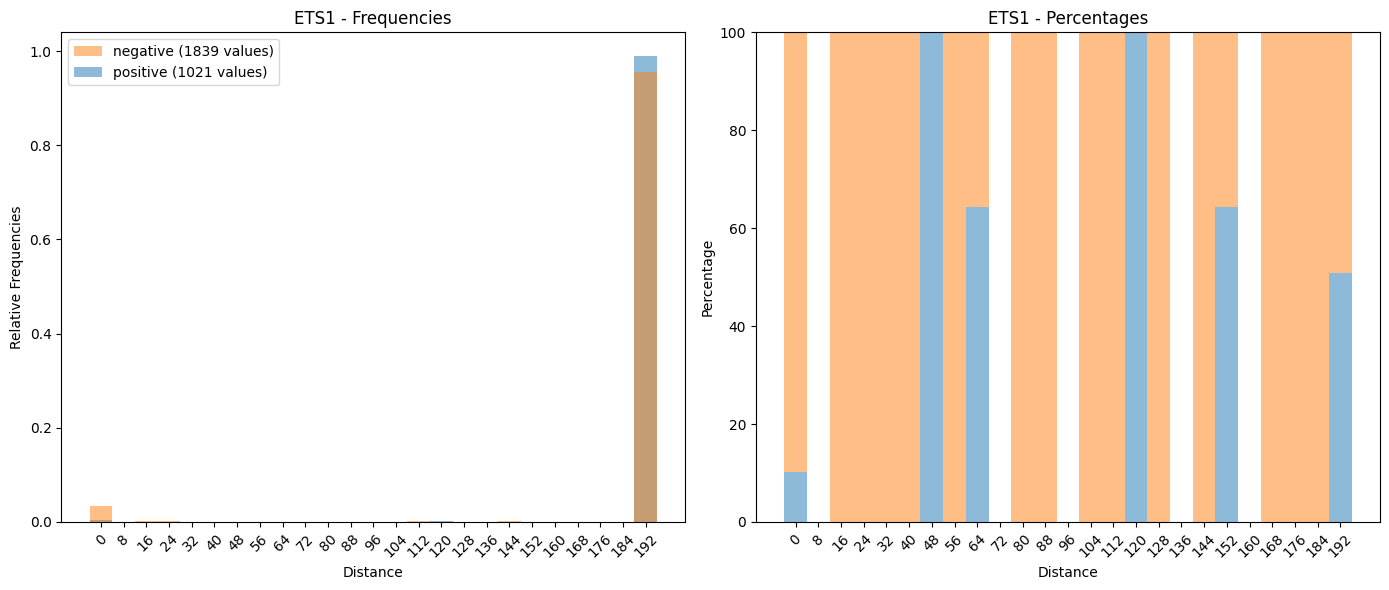

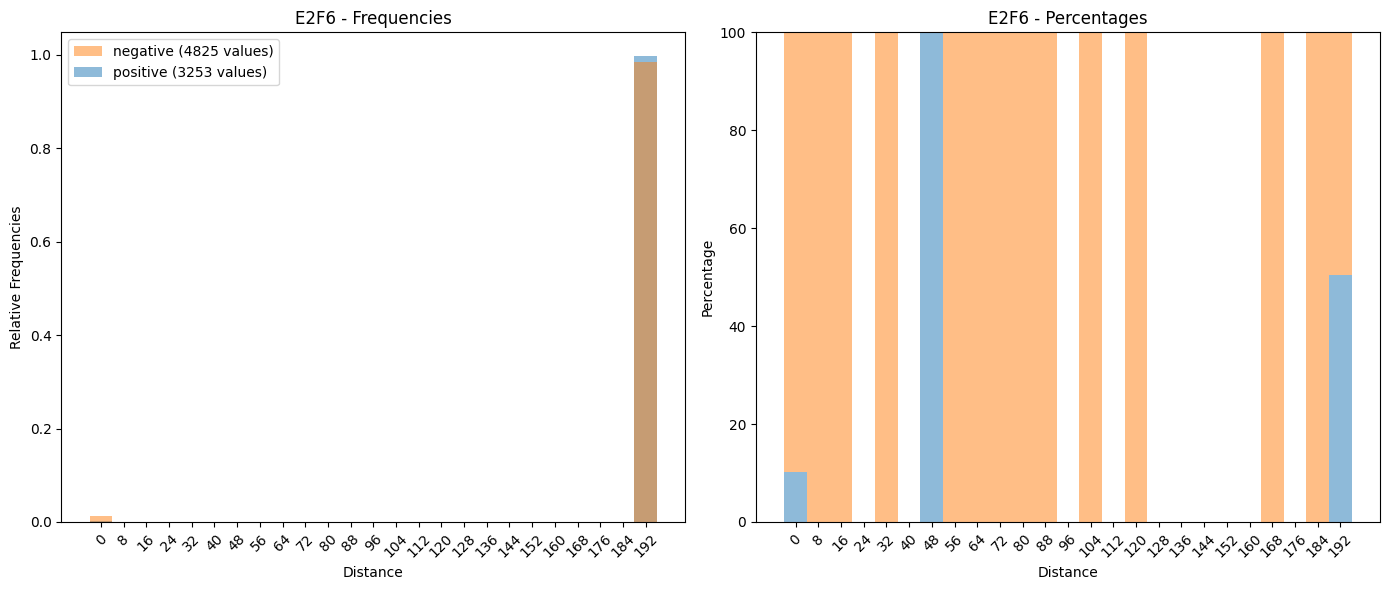

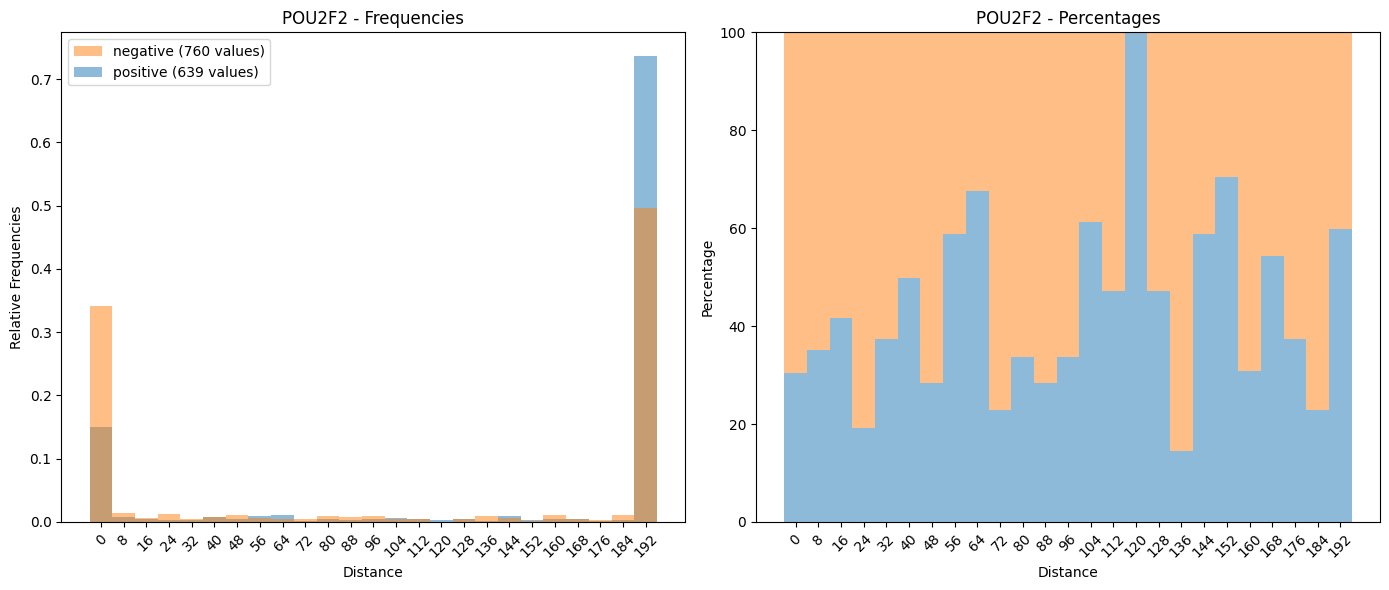

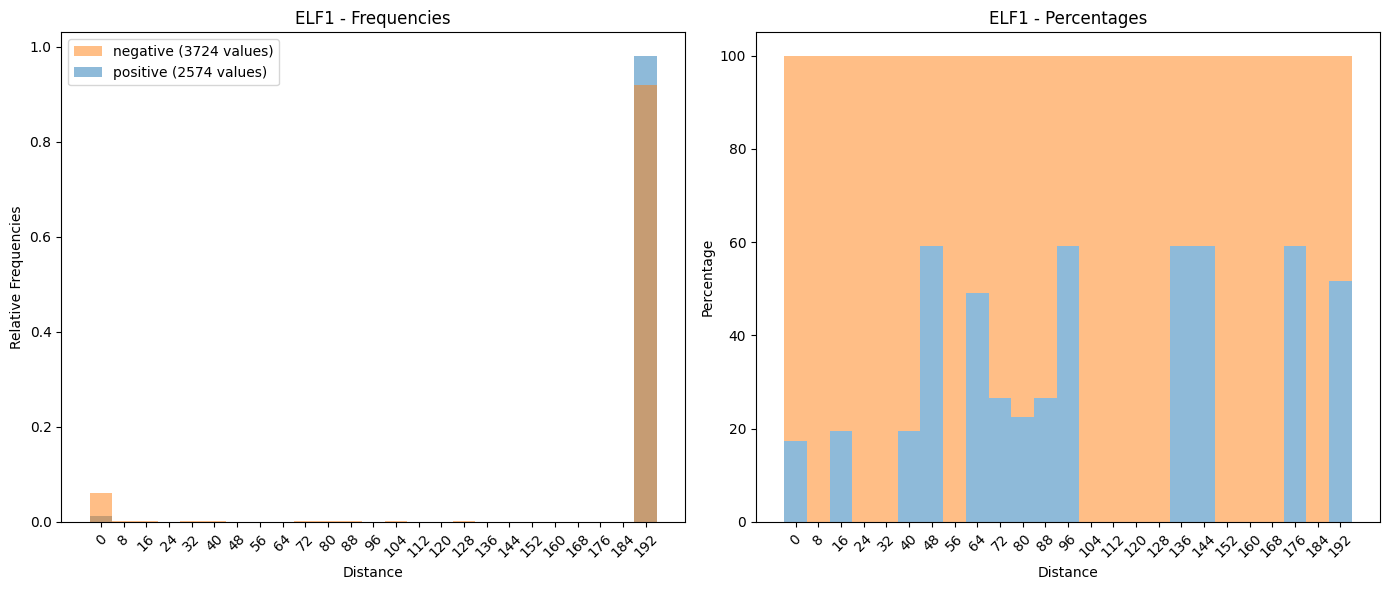

In [86]:
for tf in selected_tfs:
    positive_distances = []
    negative_distances = []

    for distance, label in distance_dict_alt[tf]['strong']:
        if label == 1:
            positive_distances.append(distance)
        elif label == 0:
            negative_distances.append(distance)

    # Calculate the range of values and determine bin edges
    value_range = 201
    bin_edges = list(range(0, value_range, value_range // 25))

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 1: Relative frequencies
    ax = axs[0]

    neg_hist, _ = np.histogram(negative_distances, bins=bin_edges)
    pos_hist, _ = np.histogram(positive_distances, bins=bin_edges)

    neg_hist = neg_hist/len(negative_distances)
    pos_hist = pos_hist/len(positive_distances)

    pos_bars = ax.bar(bin_edges[:-1], pos_hist, width=np.diff(bin_edges), alpha=0.5, label='positive', color='tab:blue')
    neg_bars = ax.bar(bin_edges[:-1], neg_hist, width=np.diff(bin_edges), alpha=0.5, label='negative', color='tab:orange')

    total_pos = len(positive_distances)
    total_neg = len(negative_distances)
    ax.legend(handles=[neg_bars, pos_bars], labels=[f'negative ({total_neg} values)', f'positive ({total_pos} values)'])
    ax.set_title(f'{tf} - Frequencies')
    ax.set_xlabel('Distance')
    ax.set_ylabel('Relative Frequencies')

    # Plot 2: Percentages
    ax = axs[1]

    total = neg_hist + pos_hist
    neg_percent = np.zeros_like(neg_hist, dtype=float)
    pos_percent = np.zeros_like(pos_hist, dtype=float)
    non_zero_total = total > 0
    if np.any(non_zero_total):
        neg_percent[non_zero_total] = (neg_hist[non_zero_total] / total[non_zero_total]) * 100
        pos_percent[non_zero_total] = (pos_hist[non_zero_total] / total[non_zero_total]) * 100

    ax.bar(bin_edges[:-1], pos_percent, width=np.diff(bin_edges), alpha=0.5, label='positive', color='tab:blue')
    ax.bar(bin_edges[:-1], neg_percent, width=np.diff(bin_edges), alpha=0.5, bottom=pos_percent, label='negative', color='tab:orange')

    ax.set_title(f'{tf} - Percentages')
    ax.set_xlabel('Distance')
    ax.set_ylabel('Percentage')

    # Adjust x-axis and rotate labels
    for ax in axs:
        ax.set_xticks(bin_edges[:-1])
        ax.set_xticklabels([str(int(edge)) for edge in bin_edges[:-1]], rotation=45)

    plt.tight_layout()

    # Save the plot
    plt.savefig(f'{location}/figs/pvalue/{tf}_comparison.png')
    plt.show()


/home/waqaas/ipykernel_518475/2253451653.py:24: RuntimeWarning: invalid value encountered in divide
  neg_percent = (neg_hist / total) * 100
/home/waqaas/ipykernel_518475/2253451653.py:25: RuntimeWarning: invalid value encountered in divide
  pos_percent = (pos_hist / total) * 100


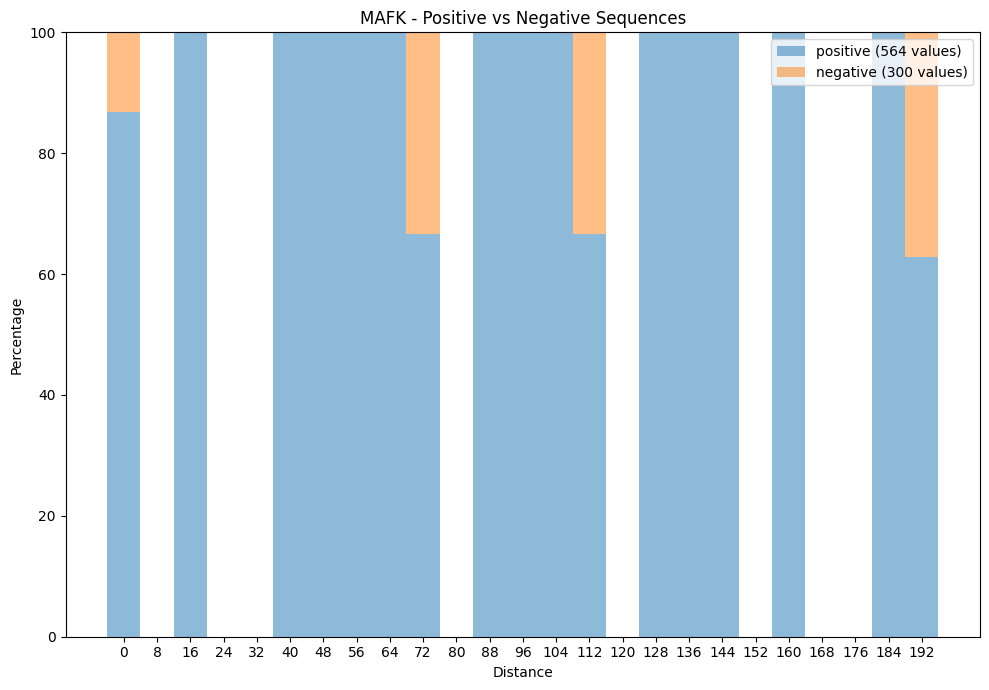

/home/waqaas/ipykernel_518475/2253451653.py:24: RuntimeWarning: invalid value encountered in divide
  neg_percent = (neg_hist / total) * 100
/home/waqaas/ipykernel_518475/2253451653.py:25: RuntimeWarning: invalid value encountered in divide
  pos_percent = (pos_hist / total) * 100


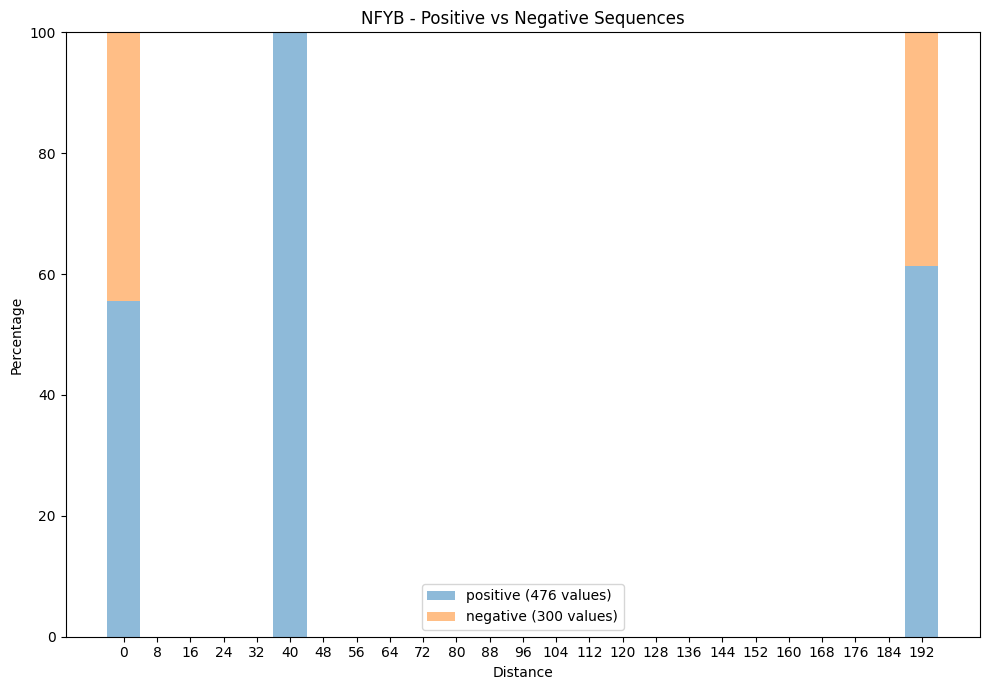

/home/waqaas/ipykernel_518475/2253451653.py:24: RuntimeWarning: invalid value encountered in divide
  neg_percent = (neg_hist / total) * 100
/home/waqaas/ipykernel_518475/2253451653.py:25: RuntimeWarning: invalid value encountered in divide
  pos_percent = (pos_hist / total) * 100


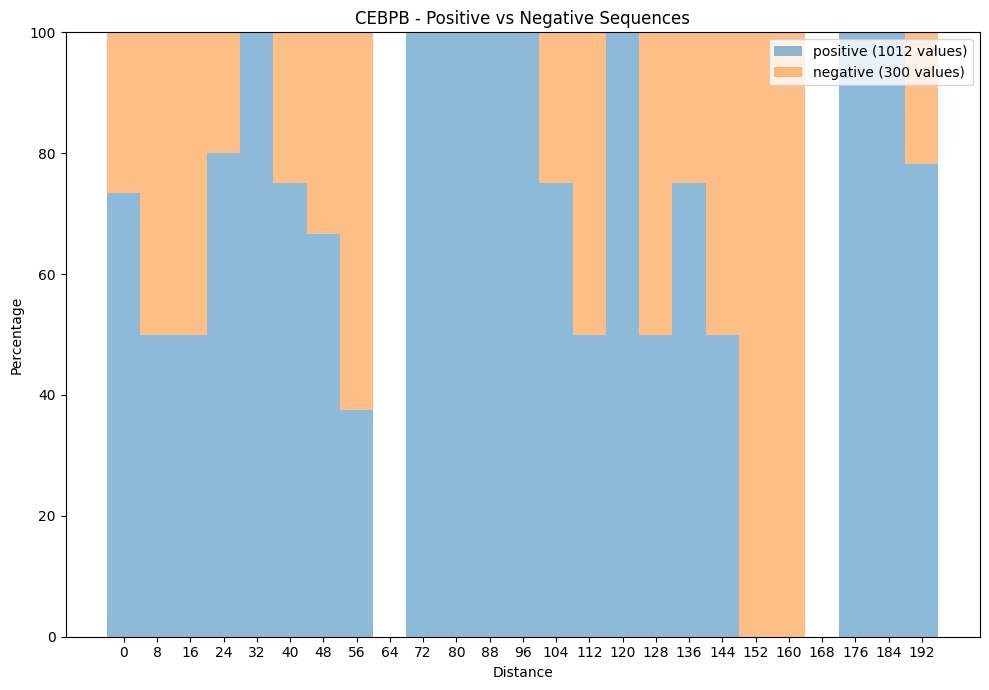

/home/waqaas/ipykernel_518475/2253451653.py:24: RuntimeWarning: invalid value encountered in divide
  neg_percent = (neg_hist / total) * 100
/home/waqaas/ipykernel_518475/2253451653.py:25: RuntimeWarning: invalid value encountered in divide
  pos_percent = (pos_hist / total) * 100


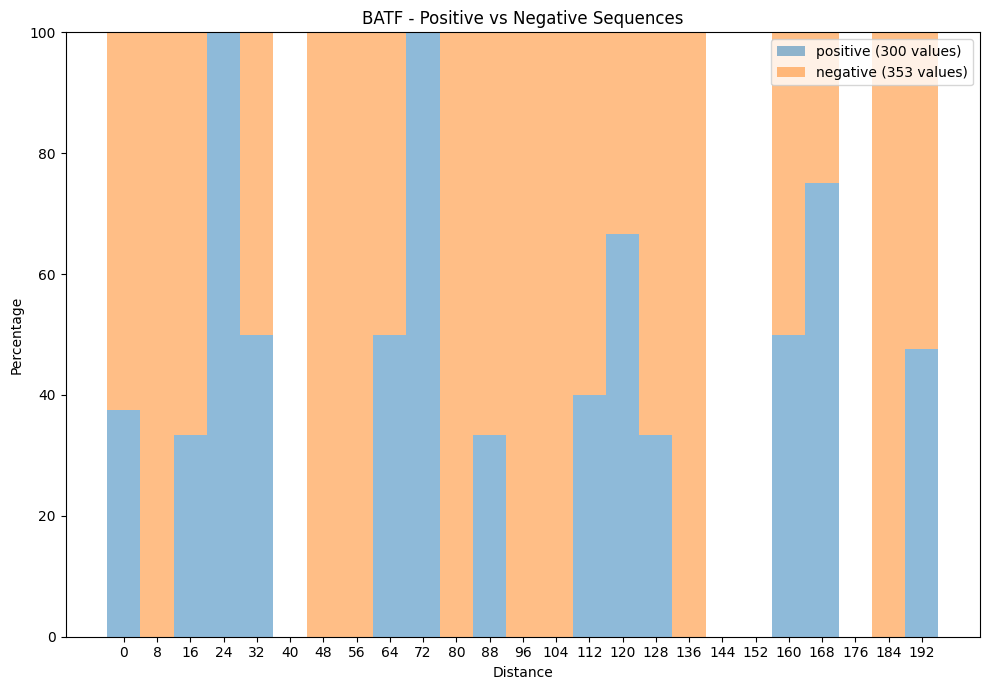

/home/waqaas/ipykernel_518475/2253451653.py:24: RuntimeWarning: invalid value encountered in divide
  neg_percent = (neg_hist / total) * 100
/home/waqaas/ipykernel_518475/2253451653.py:25: RuntimeWarning: invalid value encountered in divide
  pos_percent = (pos_hist / total) * 100


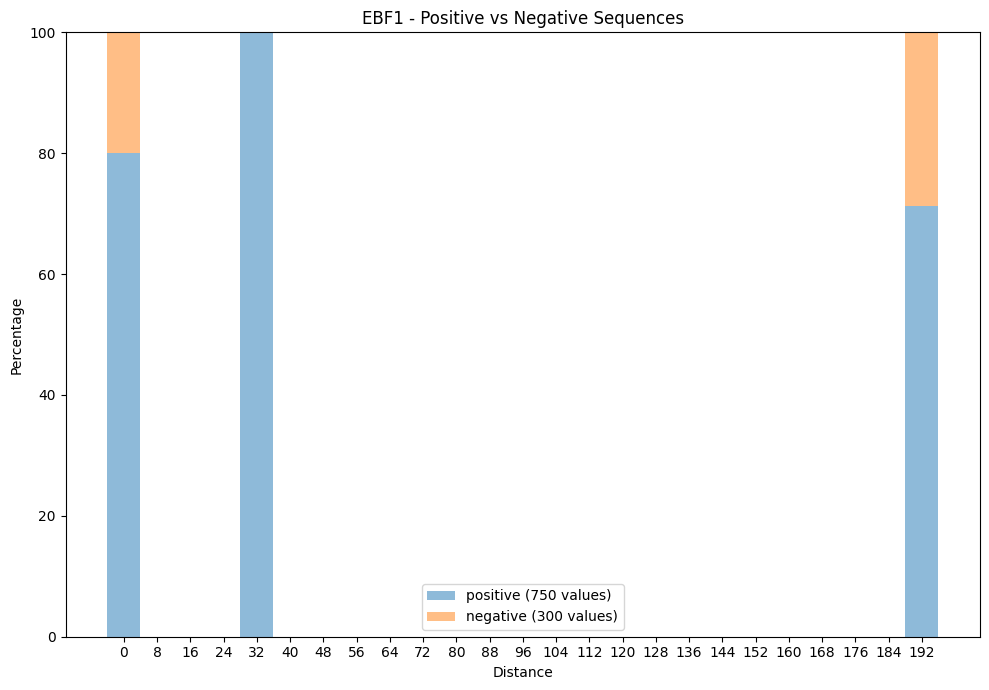

/home/waqaas/ipykernel_518475/2253451653.py:24: RuntimeWarning: invalid value encountered in divide
  neg_percent = (neg_hist / total) * 100
/home/waqaas/ipykernel_518475/2253451653.py:25: RuntimeWarning: invalid value encountered in divide
  pos_percent = (pos_hist / total) * 100


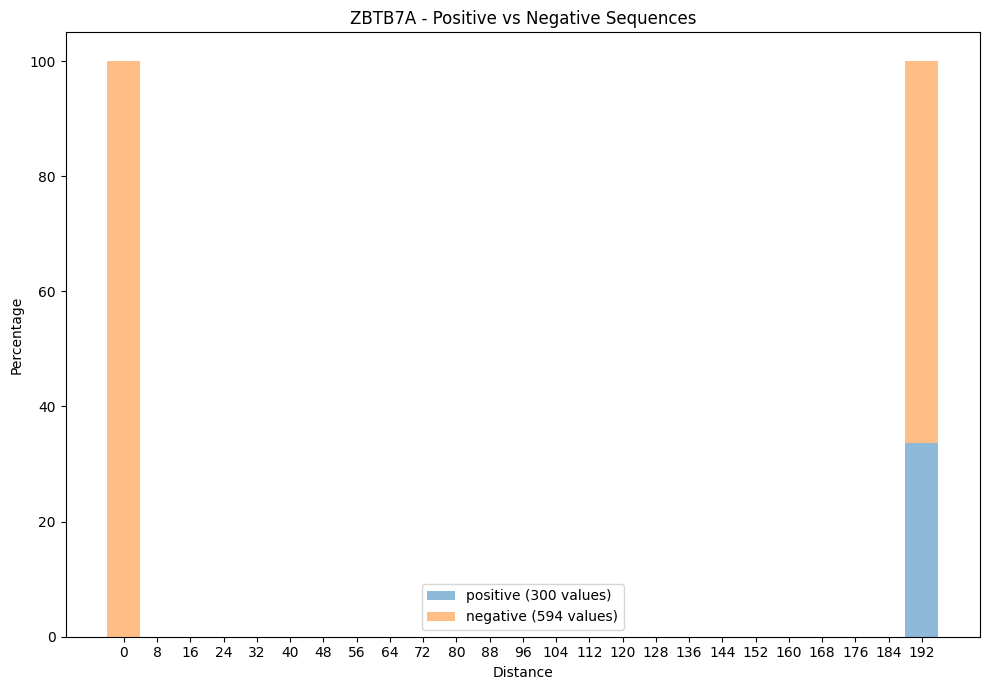

/home/waqaas/ipykernel_518475/2253451653.py:24: RuntimeWarning: invalid value encountered in divide
  neg_percent = (neg_hist / total) * 100
/home/waqaas/ipykernel_518475/2253451653.py:25: RuntimeWarning: invalid value encountered in divide
  pos_percent = (pos_hist / total) * 100


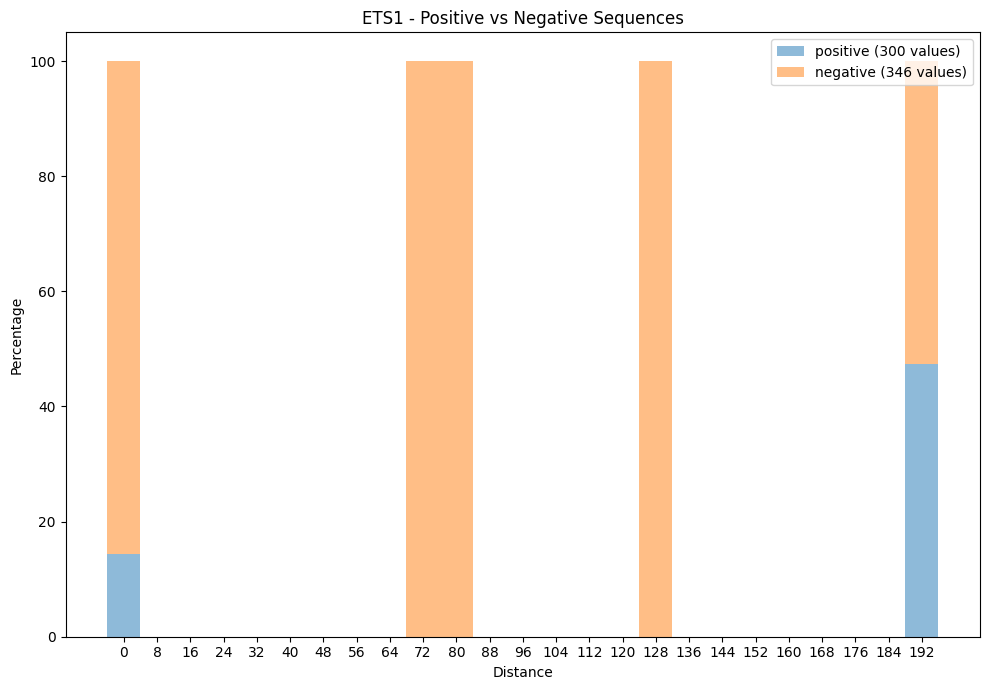

/home/waqaas/ipykernel_518475/2253451653.py:24: RuntimeWarning: invalid value encountered in divide
  neg_percent = (neg_hist / total) * 100
/home/waqaas/ipykernel_518475/2253451653.py:25: RuntimeWarning: invalid value encountered in divide
  pos_percent = (pos_hist / total) * 100


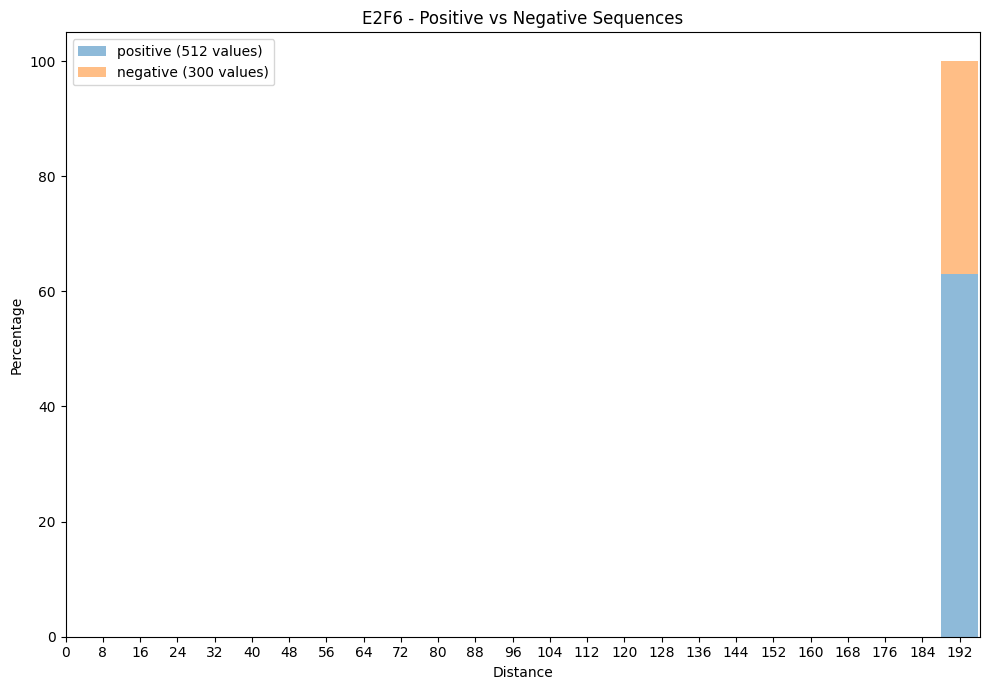

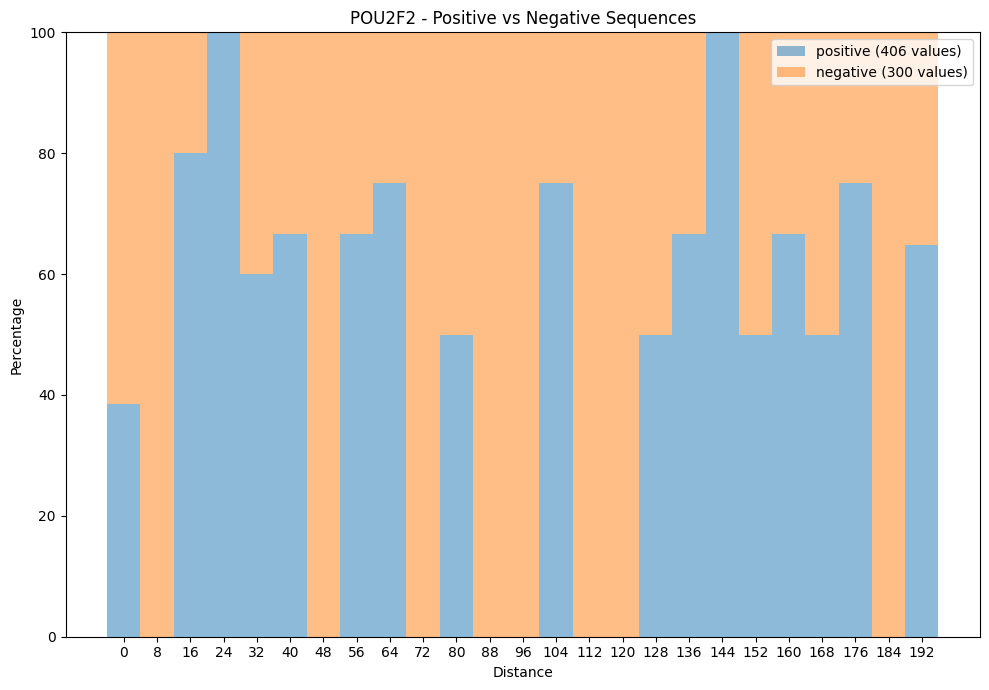

/home/waqaas/ipykernel_518475/2253451653.py:24: RuntimeWarning: invalid value encountered in divide
  neg_percent = (neg_hist / total) * 100
/home/waqaas/ipykernel_518475/2253451653.py:25: RuntimeWarning: invalid value encountered in divide
  pos_percent = (pos_hist / total) * 100


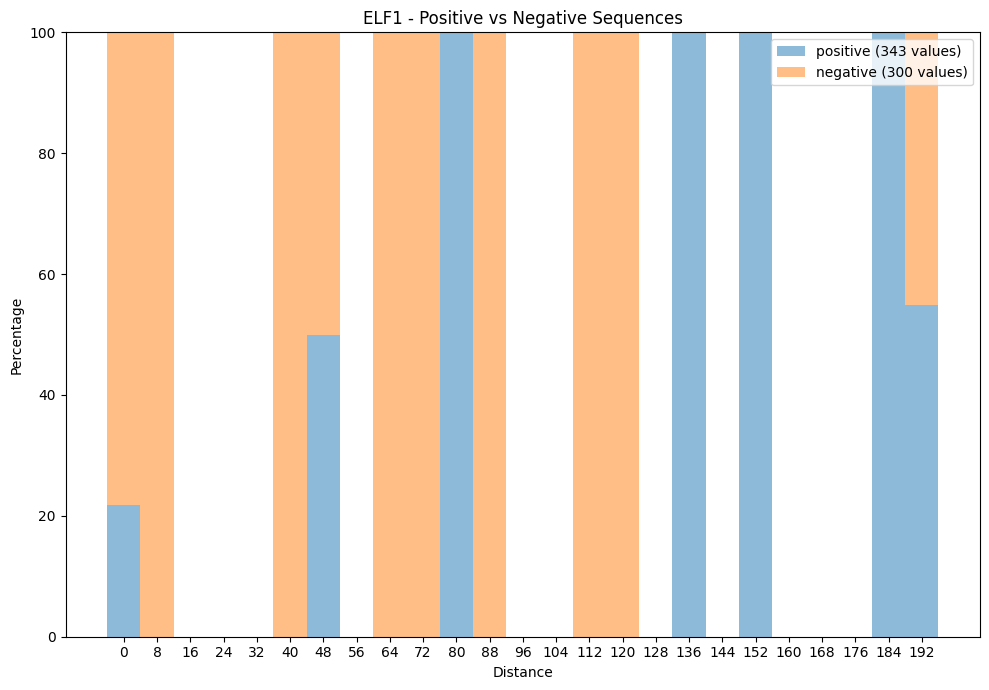

In [87]:
for tf in selected_tfs:
    positive_distances = []
    negative_distances = []

    for distance, label in distance_dict[tf]:
        if label == 1:
            positive_distances.append(distance)
        elif label == 0:
            negative_distances.append(distance)

    # Calculate the range of values and determine bin edges
    value_range = 201
    bin_edges = list(range(0, value_range, value_range // 25))

    # Create a subplot
    fig, ax = plt.subplots(figsize=(10, 7))

    # Create histograms for positive and negative distances on the same axes
    neg_hist, _ = np.histogram(negative_distances, bins=bin_edges)
    pos_hist, _ = np.histogram(positive_distances, bins=bin_edges)

    # Calculate percentages
    total = neg_hist + pos_hist
    neg_percent = (neg_hist / total) * 100
    pos_percent = (pos_hist / total) * 100

    # Handle potential division by zero in percentages
    neg_percent = np.nan_to_num(neg_percent)
    pos_percent = np.nan_to_num(pos_percent)

    # Filter out bins where both positive and negative frequencies are zero for plotting
    non_zero_bins = total > 0
    filtered_bin_centers = 0.5 * (np.array(bin_edges[:-1]) + np.array(bin_edges[1:]))[non_zero_bins]
    filtered_neg_percent = neg_percent[non_zero_bins]
    filtered_pos_percent = pos_percent[non_zero_bins]
    filtered_bin_width = np.diff(bin_edges)[non_zero_bins]  # Width of each bin

    # Plot stacked bar plots
    ax.bar(filtered_bin_centers, filtered_pos_percent, width=filtered_bin_width, alpha=0.5, label='positive')
    ax.bar(filtered_bin_centers, filtered_neg_percent, width=filtered_bin_width, alpha=0.5, bottom=filtered_pos_percent, label='negative')

    # Calculate total count of positive and negative data values
    total_pos = int(sum(pos_hist))
    total_neg = int(sum(neg_hist))

    # Add legend with total count annotations
    ax.legend([f'positive ({total_pos} values)', f'negative ({total_neg} values)'])

    ax.set_title(f'{tf} - Positive vs Negative Sequences')
    ax.set_xlabel('Distance')
    ax.set_ylabel('Percentage')

    # Center-align xticks with original bin centers
    original_bin_centers = 0.5 * (np.array(bin_edges[:-1]) + np.array(bin_edges[1:]))
    ax.set_xticks(original_bin_centers)
    ax.set_xticklabels([str(int(edge)) for edge in bin_edges[:-1]])

    plt.tight_layout()
    plt.savefig(f'{location}figs/pvalue/{tf}.png')
    plt.show()


In [88]:
# set 200 as a distance threshold, and perform fisher exact test
threshold = 200

# use a dataframe to store the odds ratio and p-value
odds_ratio_df = pd.DataFrame(index=selected_tfs, columns=['Odds Ratio', 'P-value'])

for tf in selected_tfs:
    positive_distances = []
    negative_distances = []
    for distance, label in distance_dict[tf]:
        if label == 1:
            positive_distances.append(distance)
        elif label == 0:
            negative_distances.append(distance)

    # Perform Fisher's exact test
    contingency_table = [[sum([1 for distance in positive_distances if distance < threshold]), sum([1 for distance in positive_distances if distance >= threshold])],
                         [sum([1 for distance in negative_distances if distance < threshold]), sum([1 for distance in negative_distances if distance >= threshold])]]

    odds_ratio, p_value = fisher_exact(contingency_table)
    odds_ratio_df.at[tf, 'Odds Ratio'] = odds_ratio
    odds_ratio_df.at[tf, 'P-value'] = p_value

In [89]:
# display the df as markdown
print(odds_ratio_df.to_markdown())

|        |   Odds Ratio |     P-value |
|:-------|-------------:|------------:|
| MAFK   |     4.73171  | 5.82458e-07 |
| NFYB   |     0.944681 | 1           |
| CEBPB  |     0.633909 | 0.0111072   |
| BATF   |     0.682746 | 0.07218     |
| EBF1   |     1.80972  | 0.737906    |
| ZBTB7A |     0        | 0.554826    |
| ETS1   |     0.148098 | 0.0050296   |
| E2F6   |   nan        | 1           |
| POU2F2 |     0.404736 | 3.4226e-08  |
| ELF1   |     0.303637 | 0.0010826   |


In [90]:
# Assuming perform_logistic_regression is a predefined function

models_distance = {}
thresholds = ['No threshold', 5, 10, 20, 40, 80]
motif_strength = ['both', 'strong', 'weak']

for tf in selected_tfs:
    data[tf] = {}
    for threshold in thresholds:
        data[tf][threshold] = {motif: [] for motif in motif_strength}
        for motif in motif_strength:
            for distance, label in distance_dict_alt[tf][motif]:
                if threshold == 'No threshold':
                    data_point = {
                        'distance': distance,
                        'binding_affinity': label
                    }
                elif distance < threshold:
                    data_point = {
                        'distance': 1,
                        'binding_affinity': label
                    }
                else:
                    data_point = {
                        'distance': 0,
                        'binding_affinity': label
                    }
                data[tf][threshold][motif].append(data_point)

        # Create pandas DataFrame for each TF
        df_both = pd.DataFrame(data[tf][threshold]['both'])
        df_strong = pd.DataFrame(data[tf][threshold]['strong'])
        df_weak = pd.DataFrame(data[tf][threshold]['weak'])

        # Perform logistic regression for each case if DataFrame is not empty
        models_distance[tf] = models_distance.get(tf, {})
        models_distance[tf][threshold] = {}

        if not df_both.empty:
            model_both = perform_logistic_regression(df_both, ['distance'], 'binding_affinity')
            models_distance[tf][threshold]['both'] = model_both
        if not df_strong.empty:
            model_strong = perform_logistic_regression(df_strong, ['distance'], 'binding_affinity')
            models_distance[tf][threshold]['strong'] = model_strong
        if not df_weak.empty:
            model_weak = perform_logistic_regression(df_weak, ['distance'], 'binding_affinity')
            models_distance[tf][threshold]['weak'] = model_weak

In [91]:
# Access the models for each TF as needed
for tf in selected_tfs:
    print(f"\nTF = {tf}")
    for threshold in thresholds[1:]:  # Skip 'No threshold'
        print(f"\nThreshold = {threshold}")
        
        print("\nAll Motifs:")
        if 'both' in models_distance[tf][threshold]:
            df_both = pd.DataFrame(data[tf][threshold]['both'])
            summary_both = calculate_statistics(models_distance[tf][threshold]['both'], df_both[['distance']], df_both['binding_affinity'])
            print(summary_both.to_markdown())
        else:
            print("No model available for both motifs")

        print("\nStrong Motifs:")
        if 'strong' in models_distance[tf][threshold]:
            df_strong = pd.DataFrame(data[tf][threshold]['strong'])
            summary_strong = calculate_statistics(models_distance[tf][threshold]['strong'], df_strong[['distance']], df_strong['binding_affinity'])
            print(summary_strong.to_markdown())
        else:
            print("No model available for strong motifs")

        print("\nWeak Motifs:")
        if 'weak' in models_distance[tf][threshold]:
            df_weak = pd.DataFrame(data[tf][threshold]['weak'])
            summary_weak = calculate_statistics(models_distance[tf][threshold]['weak'], df_weak[['distance']], df_weak['binding_affinity'])
            print(summary_weak.to_markdown())
        else:
            print("No model available for weak motifs")


TF = MAFK

Threshold = 5

All Motifs:
|    |    coef |   std err |       z |   P-value |    0.025 |   0.975 |   Pseudo R-squared |   Log-Likelihood |   LLR p-value |
|---:|--------:|----------:|--------:|----------:|---------:|--------:|-------------------:|-----------------:|--------------:|
|  0 | 1.07423 | 0.0929594 | 11.5559 |         0 | 0.892031 | 1.25643 |           0.929583 |         -4634.53 |             0 |

Strong Motifs:
|    |    coef |   std err |       z |     P-value |    0.025 |   0.975 |   Pseudo R-squared |   Log-Likelihood |   LLR p-value |
|---:|--------:|----------:|--------:|------------:|---------:|--------:|-------------------:|-----------------:|--------------:|
|  0 | 1.11299 |  0.135517 | 8.21293 | 2.22045e-16 | 0.847375 |  1.3786 |            0.94274 |         -2478.69 |             0 |

Weak Motifs:
|    |    coef |   std err |       z |     P-value |    0.025 |   0.975 |   Pseudo R-squared |   Log-Likelihood |   LLR p-value |
|---:|--------:|----------:

In [92]:
# Initialize an empty DataFrame to store the merged results
merged_results = {}

# Merge and format results
for tf in selected_tfs:
    merged_results[tf] = pd.DataFrame()
    for threshold in thresholds[1:]:
        # Calculate summaries for each dataset
        df_both = pd.DataFrame(data[tf][threshold]['both'])
        summary_both = calculate_statistics(models_distance[tf][threshold]['both'], df_both[['distance']], df_both['binding_affinity'])
        df_strong = pd.DataFrame(data[tf][threshold]['strong'])
        summary_strong = calculate_statistics(models_distance[tf][threshold]['strong'], df_strong[['distance']], df_strong['binding_affinity'])
        df_weak = pd.DataFrame(data[tf][threshold]['weak'])
        summary_weak = calculate_statistics(models_distance[tf][threshold]['weak'], df_weak[['distance']], df_weak['binding_affinity'])

        # Concatenate summaries into a single DataFrame with MultiIndex
        summaries = pd.concat([summary_both, summary_strong, summary_weak], keys=[(threshold, 'All Motifs'), (threshold, 'Strong Motifs'), (threshold, 'Weak Motifs')], names=['thresholds', 'Dataset'])

        # Append to the merged results
        merged_results[tf] = pd.concat([merged_results[tf], summaries])

    # Reset index to separate out TF and Dataset from the MultiIndex
    merged_results[tf].reset_index(inplace=True)

    # delete column level_2
    del merged_results[tf]['level_2']

    # Rename columns for better clarity
    merged_results[tf].columns = ['Threshold', 'Motif Type', 'Distance coefficient', 'std err', 'z', 'P-value', '0.025', '0.975', 'Pseudo R-squared', 'Log-Likelihood', 'LLR p-value']

    # if the p-value in a row is less than 0.05, add an asterisk to the Selection Criteria column
    merged_results[tf]['Motif Type'] = merged_results[tf].apply(lambda row: f"{row['Motif Type']}*" if row['P-value'] < 0.05 else row['Motif Type'], axis=1)

    # Display the merged results in Markdown format
    print(f"\nTF = {tf}")
    print(merged_results[tf].to_markdown(index=False))


TF = MAFK
|   Threshold | Motif Type     |   Distance coefficient |   std err |        z |     P-value |    0.025 |   0.975 |   Pseudo R-squared |   Log-Likelihood |   LLR p-value |
|------------:|:---------------|-----------------------:|----------:|---------:|------------:|---------:|--------:|-------------------:|-----------------:|--------------:|
|           5 | All Motifs*    |                1.07423 | 0.0929594 | 11.5559  | 0           | 0.892031 | 1.25643 |           0.929583 |         -4634.53 |             0 |
|           5 | Strong Motifs* |                1.11299 | 0.135517  |  8.21293 | 2.22045e-16 | 0.847375 | 1.3786  |           0.94274  |         -2478.69 |             0 |
|           5 | Weak Motifs*   |                1.12901 | 0.138983  |  8.12333 | 4.44089e-16 | 0.856601 | 1.40142 |           0.91465  |         -1907.32 |             0 |
|          10 | All Motifs*    |                1.0778  | 0.0923941 | 11.6652  | 0           | 0.896706 | 1.25889 |           0.9

In [93]:
# move the asterisk from the Motif Type column to the coefficient column
for tf in selected_tfs:
    merged_results[tf]['Distance coefficient'] = merged_results[tf].apply(lambda row: f"{round(row['Distance coefficient'], 6)}*" if row['P-value'] < 0.05 else round(row['Distance coefficient'], 6), axis=1)
    # remove the asterisk from the Motif Type column
    merged_results[tf]['Motif Type'] = merged_results[tf]['Motif Type'].str.replace('*', '')

In [94]:
# Display the merged results in Markdown format
for tf in selected_tfs:
    print(f"\nTF = {tf}")
    print(merged_results[tf].to_markdown(index=False))


TF = MAFK
|   Threshold | Motif Type    | Distance coefficient   |   std err |        z |     P-value |    0.025 |   0.975 |   Pseudo R-squared |   Log-Likelihood |   LLR p-value |
|------------:|:--------------|:-----------------------|----------:|---------:|------------:|---------:|--------:|-------------------:|-----------------:|--------------:|
|           5 | All Motifs    | 1.074231*              | 0.0929594 | 11.5559  | 0           | 0.892031 | 1.25643 |           0.929583 |         -4634.53 |             0 |
|           5 | Strong Motifs | 1.112988*              | 0.135517  |  8.21293 | 2.22045e-16 | 0.847375 | 1.3786  |           0.94274  |         -2478.69 |             0 |
|           5 | Weak Motifs   | 1.129009*              | 0.138983  |  8.12333 | 4.44089e-16 | 0.856601 | 1.40142 |           0.91465  |         -1907.32 |             0 |
|          10 | All Motifs    | 1.077798*              | 0.0923941 | 11.6652  | 0           | 0.896706 | 1.25889 |           0.929601 

In [95]:
# Initialize an empty DataFrame to store coefficients
coefficients_summary = pd.DataFrame(index=pd.MultiIndex.from_product([thresholds[1:], ['All Motifs', 'Strong Motifs', 'Weak Motifs']], names=['Threshold', 'Motif Type']), columns=selected_tfs)

# Populate the coefficients_summary DataFrame
for tf in selected_tfs:
    tf_df = merged_results[tf]
    
    for threshold in thresholds[1:]:
        for motif_type in ['All Motifs', 'Strong Motifs', 'Weak Motifs']:
            # Extract the coefficient for the given threshold and motif type
            coefficient = tf_df[(tf_df['Threshold'] == threshold) & (tf_df['Motif Type'] == motif_type)]['Distance coefficient'].values[0]
            coefficients_summary.at[(threshold, motif_type), tf] = coefficient


In [96]:
# reset the index
coefficients_summary.reset_index(inplace=True)

In [97]:
# print the coefficients_summary DataFrame
print(coefficients_summary.to_markdown(index=False))

|   Threshold | Motif Type    | MAFK      | NFYB       | CEBPB      | BATF       |      EBF1 | ZBTB7A     | ETS1       | E2F6       | POU2F2     | ELF1       |
|------------:|:--------------|:----------|:-----------|:-----------|:-----------|----------:|:-----------|:-----------|:-----------|:-----------|:-----------|
|           5 | All Motifs    | 1.074231* | -1.049905* | -0.421158* | -0.244136* |  0.190861 | -1.537699* | -1.672718* | -1.598163* | -0.719263* | -1.570869* |
|           5 | Strong Motifs | 1.112988* | -0.808831* | 0.025118   | 0.021337   |  0.323285 | -1.077431* | -1.795505* | -1.822468* | -1.096709* | -1.541113* |
|           5 | Weak Motifs   | 1.129009* | -1.042947* | -0.459902* | -0.355736* | -0.49827  | -1.579333* | -1.480547* | -0.855325  | -0.572136* | -1.574067* |
|          10 | All Motifs    | 1.077798* | -1.007442* | -0.411022* | -0.250198* |  0.213089 | -1.537699* | -1.646512* | -1.598163* | -0.713507* | -1.579989* |
|          10 | Strong Motifs | 1.13906*

In [98]:
# # build another instance of coefficients summary, but with Motif Type as the first index and Threshold the second
# # Initialize an empty DataFrame to store coefficients
# coefficients_summary_reversed = pd.DataFrame(index=pd.MultiIndex.from_product(['All Motifs', 'Strong Motifs', 'Weak Motifs'], thresholds[1:]), columns=selected_tfs)

# # Populate the coefficients_summary DataFrame

# for tf in selected_tfs:
#     tf_df = merged_results[tf]
    
#     for motif_type in ['All Motifs', 'Strong Motifs', 'Weak Motifs']:
#         for threshold in thresholds[1:]:
#             # Extract the coefficient for the given threshold and motif type
#             coefficient = tf_df[(tf_df['Threshold'] == threshold) & (tf_df['Motif Type'] == motif_type)]['Distance coefficient'].values[0]
#             coefficients_summary_reversed.at[(motif_type, threshold), tf] = coefficient

# # reset the index
# coefficients_summary_reversed.reset_index(inplace=True)

# # print the coefficients_summary DataFrame
# print(coefficients_summary_reversed.to_markdown(index=False))

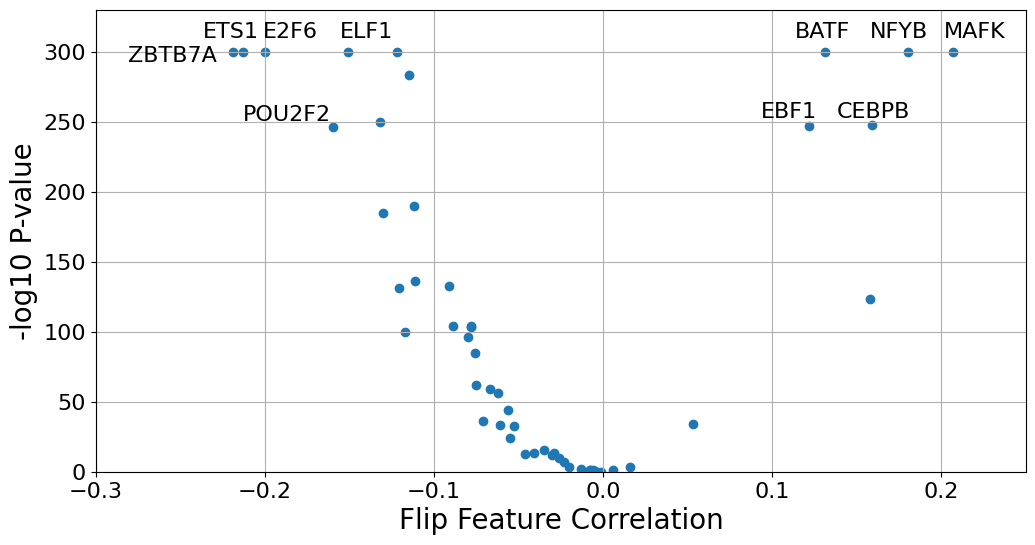

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming correlation_results_df is already defined somewhere above

plt.figure(figsize=(12, 6))
plt.scatter(correlation_results_df['motif_flip_corr'], 
            -np.log10(correlation_results_df['motif_flip_pval'].astype(float) + 1e-300), 
            label='Level 0')

# Manually adjust positions for all annotations
zbtb7a_pos = (-0.255, 290)
ets1_pos = (-0.22, 307)
e2f6_pos = (-0.185, 307)
elf1_pos = (-0.14, 307)
pou2f2_pos = (-0.187, 248)
ebf1_pos = (0.11, 250)
batf_pos = (0.13, 307)
cebpb_pos = (0.16, 250)
nfyb_pos = (0.175, 307)
mafk_pos = (0.22, 307)


plt.annotate('ZBTB7A', xy=zbtb7a_pos, xytext=zbtb7a_pos, textcoords='data', fontsize=16, ha='center', va='bottom')
plt.annotate('ETS1', xy=ets1_pos, xytext=ets1_pos, textcoords='data', fontsize=16, ha='center', va='bottom')
plt.annotate('E2F6', xy=e2f6_pos, xytext=e2f6_pos, textcoords='data', fontsize=16, ha='center', va='bottom')
plt.annotate('ELF1', xy=elf1_pos, xytext=elf1_pos, textcoords='data', fontsize=16, ha='center', va='bottom')
plt.annotate('POU2F2', xy=pou2f2_pos, xytext=pou2f2_pos, textcoords='data', fontsize=16, ha='center', va='bottom')
plt.annotate('EBF1', xy=ebf1_pos, xytext=ebf1_pos, textcoords='data', fontsize=16, ha='center', va='bottom')
plt.annotate('BATF', xy=batf_pos, xytext=batf_pos, textcoords='data', fontsize=16, ha='center', va='bottom')
plt.annotate('CEBPB', xy=cebpb_pos, xytext=cebpb_pos, textcoords='data', fontsize=16, ha='center', va='bottom')
plt.annotate('NFYB', xy=nfyb_pos, xytext=nfyb_pos, textcoords='data', fontsize=16, ha='center', va='bottom')
plt.annotate('MAFK', xy=mafk_pos, xytext=mafk_pos, textcoords='data', fontsize=16, ha='center', va='bottom')

plt.xlabel('Flip Feature Correlation', fontsize=20)
plt.ylabel('-log10 P-value', fontsize=20)
# set tick font size to 16
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(-0.3, 0.25)
plt.ylim(0, 330)
plt.grid(True)
plt.show()

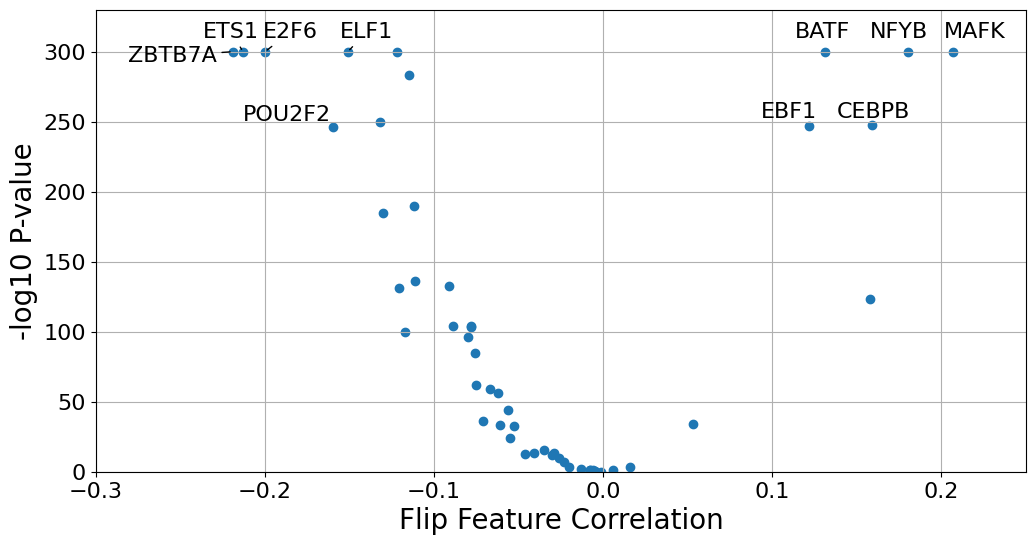

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming correlation_results_df is already defined somewhere above

plt.figure(figsize=(12, 6))
plt.scatter(correlation_results_df['motif_flip_corr'], 
            -np.log10(correlation_results_df['motif_flip_pval'].astype(float) + 1e-300), 
            label='Level 0')

# Manually adjust positions for all annotations
annotations = {
    'ZBTB7A': (-0.255, 290),
    'ETS1': (-0.22, 307),
    'E2F6': (-0.185, 307),
    'ELF1': (-0.14, 307),
    'POU2F2': (-0.187, 248),
    'EBF1': (0.11, 250),
    'BATF': (0.13, 307),
    'CEBPB': (0.16, 250),
    'NFYB': (0.175, 307),
    'MAFK': (0.22, 307)
}

# get the original data points from the df for the annotations
original_points = {}
for label, pos in annotations.items():
    for i, row in correlation_results_df.iterrows():
        if i[0] == label:
            original_points[label] = (row['motif_flip_corr'], -np.log10(float(row['motif_flip_pval']) + 1e-300))

for label, pos in annotations.items():
    x_pos, y_pos = pos
    if label in ['ZBTB7A', 'ETS1', 'E2F6', 'ELF1']:
        x_orig, y_orig = original_points[label]
        plt.annotate(label, xy=(x_orig, y_orig), xytext=pos, textcoords='data',
                     fontsize=16, ha='center', va='bottom', arrowprops=dict(arrowstyle='-', color='black'))
    else:
        plt.annotate(label, xy=pos, xytext=pos, textcoords='data',
                     fontsize=16, ha='center', va='bottom')

plt.xlabel('Flip Feature Correlation', fontsize=20)
plt.ylabel('-log10 P-value', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(-0.3, 0.25)
plt.ylim(0, 330)
plt.grid(True)
plt.show()

In [133]:
dfs = []

for tf in selected_tfs:
    df = merged_results[tf][(merged_results[tf]['Threshold'] == 80) & (merged_results[tf]['Motif Type'] == 'All Motifs')][['Distance coefficient', 'P-value']]
    df['TF'] = tf
    dfs.append(df)

tf_data = pd.concat(dfs).reset_index(drop=True)

In [134]:
tf_data['Distance coefficient'] = tf_data['Distance coefficient'].astype(str).str.replace('*', '', regex=False).astype(float)

In [135]:
tf_data

,Distance coefficient,P-value,TF
0,1.040023,0.000000e+00,MAFK
1,-1.130053,4.615696e-06,NFYB
2,-0.400023,3.332916e-05,CEBPB
3,-0.274217,8.095738e-04,BATF
4,0.204280,2.417731e-01,EBF1
5,-1.517645,2.266138e-08,ZBTB7A
6,-1.611988,0.000000e+00,ETS1
7,-1.545465,5.765466e-08,E2F6
8,-0.751110,0.000000e+00,POU2F2
9,-1.537355,0.000000e+00,ELF1


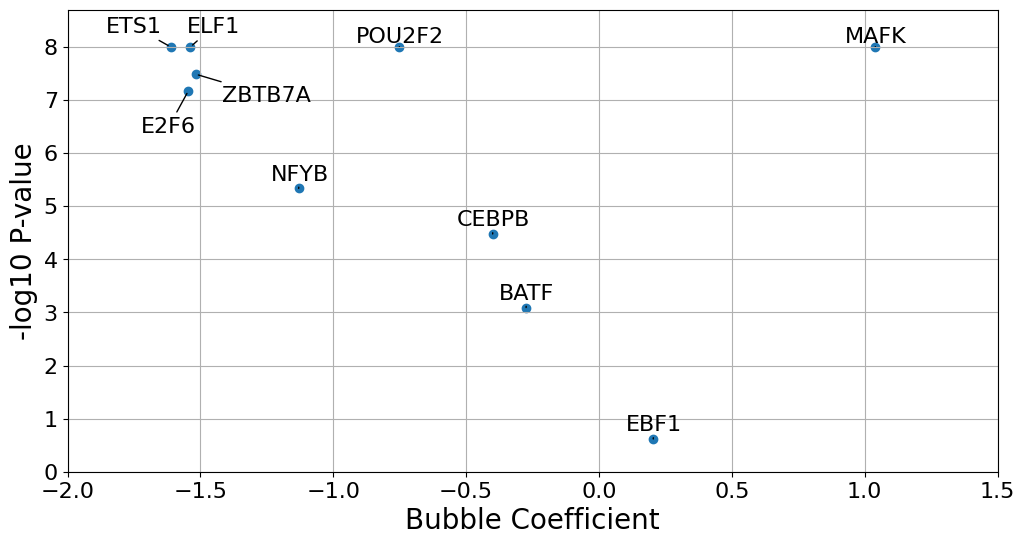

In [139]:
from adjustText import adjust_text

plt.figure(figsize=(12, 6))

# Plot the data points
plt.scatter(tf_data['Distance coefficient'].astype(float), 
            -np.log10(tf_data['P-value'].astype(float) + 1e-8))

# Manually adjusted positions for specific TFs
manual_annotations = {
    'ZBTB7A': (-1.25, 6.9),
    'ETS1': (-1.75, 8.2),
    'E2F6': (-1.62, 6.3),
    'ELF1': (-1.45, 8.2),
}

# Add manual annotations
for tf, pos in manual_annotations.items():
    row = tf_data[tf_data['TF'] == tf].iloc[0]
    plt.annotate(tf, xy=(row['Distance coefficient'], -np.log10(float(row['P-value']) + 1e-8)), 
                 xytext=pos, textcoords='data', fontsize=16, ha='center', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='black'))

# Get the original data points from the df for the annotations
texts = []
for i, row in tf_data.iterrows():
    if row['TF'] not in manual_annotations:
        texts.append(plt.text(row['Distance coefficient'], -np.log10(float(row['P-value']) + 1e-8), 
                              row['TF'], ha='center', va='bottom', fontsize=16))

# Use adjust_text to automatically adjust the remaining annotations
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'), force_text=(1.4, 1))

plt.xlabel('Bubble Coefficient', fontsize=20)
plt.ylabel('-log10 P-value', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(-2, 1.5)
plt.ylim(0, 8.7)
plt.grid(True)
plt.show()

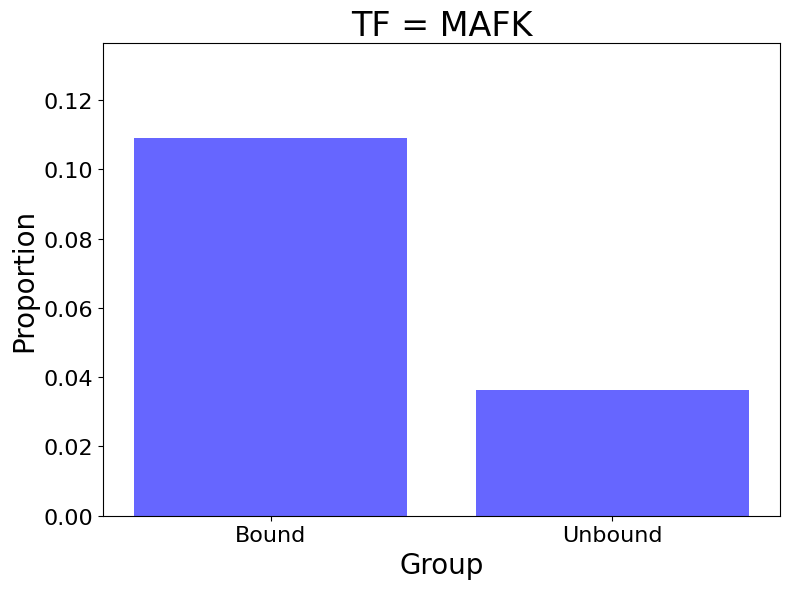

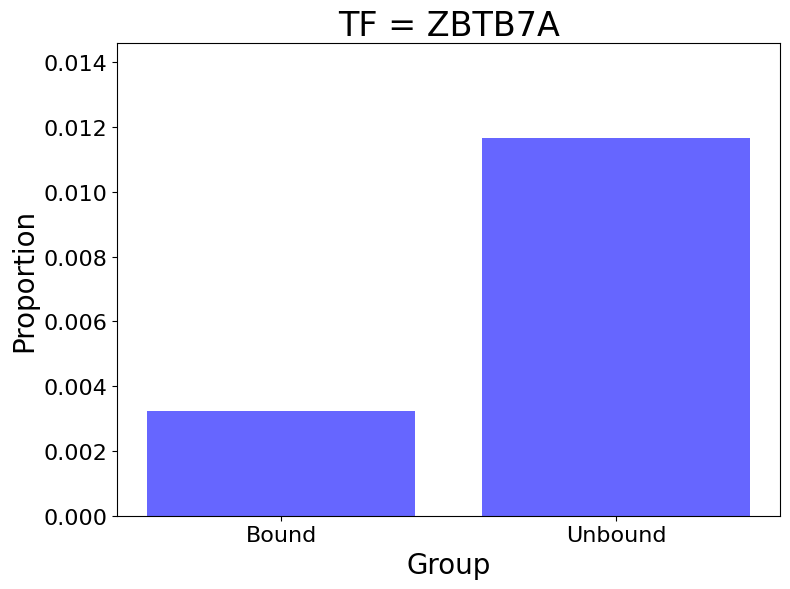

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ranksums

# Assuming distance_dict_alt is defined

threshold = 10

for tf in ['MAFK', 'ZBTB7A']:
    label_flip_pos = []
    label_flip_neg = []

    # Set font size factors
    a = 1.6
    title_fontsize = 24
    label_fontsize = 20
    tick_fontsize = 16  # Adjust tick font size

    for distance, label in distance_dict_alt[tf]['strong']:
        if distance <= threshold:
            if label == 1:
                label_flip_pos.append(0)
            elif label == 0:
                label_flip_neg.append(0)
        elif distance > threshold:
            if label == 1:
                label_flip_pos.append(1)
            elif label == 0:
                label_flip_neg.append(1)
    
    # Calculate proportions
    pos_zeros = label_flip_pos.count(0) / len(label_flip_pos) if label_flip_pos else 0
    neg_zeros = label_flip_neg.count(0) / len(label_flip_neg) if label_flip_neg else 0

    # Data for bar graph
    proportions = {
        'Bound': [pos_zeros],
        'Unbound': [neg_zeros]
    }

    # Plot the bar graph
    fig, ax = plt.subplots(figsize=(8, 6))
    categories = list(proportions.keys())
    zeros = [proportions[cat][0] for cat in categories]

    ax.bar(categories, zeros, color='blue', alpha=0.6)

    ax.set_title('TF = ' + f"{tf}".upper(), fontsize=title_fontsize)
    ax.set_xlabel("Group", fontsize=label_fontsize)
    ax.set_ylabel("Proportion", fontsize=label_fontsize)
    ax.tick_params(axis='x', labelsize=tick_fontsize)
    ax.tick_params(axis='y', labelsize=tick_fontsize)

    # Set y-axis maximum based on the heights of the bars
    ax.set_ylim(0, max(zeros) * 1.25 if zeros else 1)

    plt.tight_layout()
    plt.savefig(f'/scratch/midway3/waqaas/DNA-breathing/figs/paper/{tf}_bubble_presence_bar.png')
    plt.show()

In [ ]:
from adjustText import adjust_text

plt.figure(figsize=(12, 6))

# Plot the data points
plt.scatter(tf_data['Distance coefficient'].astype(float), 
            -np.log10(tf_data['P-value'].astype(float) + 1e-8))

# Manually adjusted positions for specific TFs
manual_annotations = {
    'ZBTB7A': (-0.255, 7),
    'ETS1': (-0.22, 7),
    'E2F6': (-0.175, 6.7),
    'ELF1': (-0.14, 7),
}

# Add manual annotations
for tf, pos in manual_annotations.items():
    row = tf_data[tf_data['TF'] == tf].iloc[0]
    plt.annotate(tf, xy=(row['Distance coefficient'], -np.log10(float(row['P-value']) + 1e-8)), 
                 xytext=pos, textcoords='data', fontsize=16, ha='center', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='black'))

# Get the original data points from the df for the annotations
texts = []
for i, row in tf_data.iterrows():
    if row['TF'] not in manual_annotations:
        texts.append(plt.text(row['Distance coefficient'], -np.log10(float(row['P-value']) + 1e-8), 
                              row['TF'], ha='center', va='bottom', fontsize=16))

# Use adjust_text to automatically adjust the remaining annotations
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'), force_text=(1.4, 1))

plt.xlabel('Distance Coefficient', fontsize=20)
plt.ylabel('-log10 P-value', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(-2, 1.5)
plt.ylim(0, 8.7)
plt.grid(True)
plt.show()